# Org the data 

In [125]:
import torch
import platform
import sys

# Check if running on macOS
if platform.system() == 'Darwin':
    # Check for MPS (Metal Performance Shaders) availability on Mac
    print(f"Running on macOS {platform.mac_ver()[0]}")
    print(f"MPS is built: {torch.backends.mps.is_built()}")
    print(f"MPS is available: {torch.backends.mps.is_available()}")
else:
    print(f"Running on {platform.system()} {platform.release()}")
    if platform.system() == 'Windows':
        # Check for CUDA availability on Windows
        print(f"CUDA is available: {torch.cuda.is_available()}")
        if torch.cuda.is_available():
            print(f"CUDA version: {torch.version.cuda}")
            print(f"Number of CUDA devices: {torch.cuda.device_count()}")
            print(f"Current CUDA device: {torch.cuda.current_device()}")
            print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    else:
        print("MPS is only available on macOS devices")

Running on Windows 11
CUDA is available: True
CUDA version: 12.6
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3060


## Splite the RAW

In [126]:
# 
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns

def extract_action_samples(csv_file, plot_stats=False):
    """
    Extract action samples from a CSV file according to specific rules.
    
    Args:
        csv_file (str): Full path to the CSV file
        plot_stats (bool): If True, plot statistics about the extracted samples
    
    Returns:
        pandas.DataFrame: Processed data with action groups and group indices
        list: Group start times
        datetime: Start time of the whole process (timestamp of first record)
    """
    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Ensure timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Get the start time of the whole process (first record)
    process_start_time = df['timestamp'].iloc[0] if not df.empty else None
    
    # Initialize variables
    action_groups = []
    group_start_times = []
    current_idx = 0
    all_extracted_records = []
    
    # Iterate through dataframe to find action groups
    while current_idx < len(df) - 60:  # Need at least 60 records for a complete group
        # Look for a cross button press
        if df.loc[current_idx + 10, 'button_press'] == 'cross':
            # Check if we have 10 'none' records before the press
            pre_press = df.iloc[current_idx:current_idx + 10]
            if all(pre_press['button_press'] == 'none'):
                # Extract the group: 10 records before press + 50 records starting from press
                action_group = df.iloc[current_idx:current_idx + 60]
                
                # Calculate duration
                start_time = action_group.iloc[0]['timestamp']
                end_time = action_group.iloc[-1]['timestamp']
                duration = (end_time - start_time).total_seconds()
                
                # Store group and start time
                action_groups.append({
                    'group': action_group,
                    'duration': duration
                })
                group_start_times.append(start_time)
                
                # Add group_index to records
                group_index = len(action_groups) - 1
                group_with_index = action_group.copy()
                group_with_index['group_index'] = group_index
                
                # Add to collection
                all_extracted_records.append(group_with_index)
                
                # Move to position after this group
                current_idx += 60
            else:
                # Pre-press condition not met, move forward by 1
                current_idx += 1
        else:
            # No press at expected position, move forward by 1
            current_idx += 1
    
    # Combine all extracted records
    if all_extracted_records:
        extracted_df = pd.concat(all_extracted_records)
        print(f"Extracted {len(action_groups)} action groups from {csv_file}")
        
        # Print the shape of the sample and count of how many samples
        print(f"Shape of extracted data: {extracted_df.shape}")
        print(f"Total number of samples: {len(extracted_df)}")
        print(f"Number of unique groups: {extracted_df['group_index'].nunique()}")
        
        # Print the shape of each individual sample (group)
        print("\nShape of each sample (group):")
        for i, group in enumerate(action_groups):
            group_df = group['group']
            print(f"Group {i}: {group_df.shape} - Duration: {group['duration']:.2f}s")
        
        # If plot_stats is True, visualize detailed statistics about the samples
        if plot_stats:
            # Create a figure with multiple subplots
            fig, axes = plt.subplots(len(action_groups), 3, figsize=(18, 4*len(action_groups)))
            
            # If only one group, make axes indexable
            if len(action_groups) == 1:
                axes = np.array([axes])
                
            for i, group in enumerate(action_groups):
                group_df = group['group']
                
                # Count statistics
                pre_press_count = sum(group_df.iloc[:10]['button_press'] == 'none')
                press_events = group_df.iloc[10:]['button_press'].value_counts()
                press_count = sum(group_df.iloc[10:]['button_press'] != 'none')
                post_press_none_count = sum(group_df.iloc[10:]['button_press'] == 'none')
                
                # Plot 1: Button press distribution
                press_events_df = pd.DataFrame(press_events).reset_index()
                press_events_df.columns = ['Button', 'Count']
                sns.barplot(x='Button', y='Count', data=press_events_df, ax=axes[i, 0])
                axes[i, 0].set_title(f'Group {i}: Button Press Distribution')
                axes[i, 0].set_ylabel('Count')
                axes[i, 0].tick_params(axis='x', rotation=45)
                
                # Plot 2: Gyro data over time
                time_indices = range(len(group_df))
                axes[i, 1].plot(time_indices, group_df['gyro_pitch'], label='Pitch')
                axes[i, 1].plot(time_indices, group_df['gyro_yaw'], label='Yaw')
                axes[i, 1].plot(time_indices, group_df['gyro_roll'], label='Roll')
                axes[i, 1].axvline(x=10, color='r', linestyle='--', label='First Press')
                axes[i, 1].set_title(f'Group {i}: Gyro Data')
                axes[i, 1].set_xlabel('Time Index')
                axes[i, 1].set_ylabel('Gyro Values')
                axes[i, 1].legend()
                
                # Plot 3: Accelerometer data over time
                axes[i, 2].plot(time_indices, group_df['acc_x'], label='X')
                axes[i, 2].plot(time_indices, group_df['acc_y'], label='Y')
                axes[i, 2].plot(time_indices, group_df['acc_z'], label='Z')
                axes[i, 2].axvline(x=10, color='r', linestyle='--', label='First Press')
                axes[i, 2].set_title(f'Group {i}: Accelerometer Data')
                axes[i, 2].set_xlabel('Time Index')
                axes[i, 2].set_ylabel('Accel Values')
                axes[i, 2].legend()
                
                # Add text annotation with statistics
                stats_text = (f"Duration: {group['duration']:.2f}s\n"
                             f"Pre-press none: {pre_press_count}\n"
                             f"Button presses: {press_count}\n"
                             f"Post-press none: {post_press_none_count}")
                axes[i, 0].annotate(stats_text, xy=(0.5, -0.4), xycoords='axes fraction', 
                                   ha='center', va='center', fontsize=10,
                                   bbox=dict(boxstyle='round', fc='lightyellow', alpha=0.7))
            
            plt.tight_layout()
            plt.show()
            
            # Create a summary plot
            plt.figure(figsize=(12, 8))
            
            # Plot 1: Group durations
            plt.subplot(2, 2, 1)
            durations = [group['duration'] for group in action_groups]
            plt.bar(range(len(durations)), durations)
            plt.xlabel('Group Index')
            plt.ylabel('Duration (seconds)')
            plt.title('Duration of Each Action Group')
            
            # Plot 2: Button press distribution across all groups
            plt.subplot(2, 2, 2)
            sns.countplot(x='button_press', data=extracted_df)
            plt.title('Button Press Distribution')
            plt.xlabel('Button Type')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            
            # Plot 3: Gyro data distribution
            plt.subplot(2, 2, 3)
            sns.boxplot(data=extracted_df[['gyro_pitch', 'gyro_yaw', 'gyro_roll']])
            plt.title('Gyro Data Distribution')
            plt.ylabel('Values')
            
            # Plot 4: Accelerometer data distribution
            plt.subplot(2, 2, 4)
            sns.boxplot(data=extracted_df[['acc_x', 'acc_y', 'acc_z']])
            plt.title('Accelerometer Data Distribution')
            plt.ylabel('Values')
            
            plt.tight_layout()
            plt.show()

        # Print basic information about the extracted data
        print("\nExtracted Data Overview:")
        print(f"Total records: {len(extracted_df)}")
        print(f"Number of groups: {len(action_groups)}")
        print(f"Columns: {extracted_df.columns.tolist()}")
        print("\nSample data (first 5 rows):")
        print(extracted_df.head())
        print("\nButton press distribution:")
        print(extracted_df['button_press'].value_counts())
            
        return extracted_df, group_start_times, process_start_time
    else:
        print(f"No action groups found in {csv_file}")
        return pd.DataFrame(), [], process_start_time

In [127]:
import numpy as np
import soundfile as sf
from scipy import signal
import librosa
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os

def split_audio_by_timestamps(wav_file, group_start_times, process_start_time, segment_duration=0.3, 
                            half_peak_duration=0.03, plot_spectrograms=False):
    """
    Split audio file into segments based on group start times from action samples.
    
    Args:
        wav_file (str): Path to the WAV file
        group_start_times (list): List of timestamps for each group start
        process_start_time (datetime): Start time of the whole process
        segment_duration (float): Duration of each segment in seconds (default: 0.3)
        half_peak_duration (float): Half duration of peak window in seconds (default: 0.03)
        plot_spectrograms (bool): Whether to plot spectrograms (default: False)
    
    Returns:
        dict: Contains processed audio data with following keys:
            - 'audio_segments': List of raw audio segments
            - 'peak_segments': List of peak audio segments
            - 'spectrograms': List of spectrogram data
            - 'mfccs': List of MFCC features
            - 'low_power_peaks': List of indices of low power peak segments
    """
    # Load the audio file
    audio, sr = sf.read(wav_file)
    
    # Initialize storage for results
    audio_segments = []
    peak_segments = []
    spectrograms = []
    mfccs = []
    low_power_peaks = []
    off_center_peaks = []
    
    # Process each group start time
    for i, start_time in enumerate(group_start_times):
        # Calculate the start index in audio samples
        relative_seconds = (start_time - process_start_time).total_seconds()
        start_idx = int(relative_seconds * sr)
        end_idx = start_idx + int(segment_duration * sr)
        
        # Ensure indices are within bounds
        if start_idx >= 0 and end_idx <= len(audio):
            # Extract the segment
            segment = audio[start_idx:end_idx]
            audio_segments.append(segment)
            
            # Convert to mono if stereo
            if len(segment.shape) > 1 and segment.shape[1] > 1:
                segment_mono = np.mean(segment, axis=1)
            else:
                segment_mono = segment
            
            # Apply Wiener filter for denoising
            noise_samples = int(0.03 * sr)
            noise = segment_mono[:noise_samples]
            noise_psd = 0.0005 * np.mean(np.abs(np.fft.rfft(noise))**2)
            denoised_segment = signal.wiener(segment_mono, mysize=1024, noise=noise_psd)
            
            # Find peak in the middle section
            start_exclude_idx = int(0.01 * sr)
            end_exclude_idx = len(denoised_segment) - int(0.01 * sr)
            valid_segment = denoised_segment[start_exclude_idx:end_exclude_idx]
            
            # Peak detection
            abs_segment = np.abs(valid_segment)
            max_amplitude = np.max(abs_segment)
            peaks, peak_properties = signal.find_peaks(abs_segment,
                                                     prominence=0.2*max_amplitude,  # Lowered prominence threshold
                                                     distance=int(0.01*sr))
            
            # If no peaks found, use maximum value
            if len(peaks) == 0:
                peak_index = np.argmax(abs_segment) + start_exclude_idx
                peak_properties = {'prominences': [0]}
            else:
                highest_peak_idx = np.argmax(peak_properties['prominences'])
                peak_index = peaks[highest_peak_idx] + start_exclude_idx
            
            peak_time = peak_index / sr
            
            # Calculate peak window
            peak_start_time = max(0.0, peak_time - half_peak_duration)
            peak_end_time = min(segment_duration, peak_time + half_peak_duration)
            peak_start_idx = int(peak_start_time * sr)
            peak_end_idx = int(peak_end_time * sr)
            
            # Extract peak window
            peak_segment = denoised_segment[peak_start_idx:peak_end_idx]
            
            # New low power peak detection logic
            peak_absolute_value = np.abs(denoised_segment[peak_index])
            is_low_power = peak_absolute_value < 0.05  # Mark as low power if absolute peak value < 0.05
            
            if is_low_power:
                low_power_peaks.append(i)
            
            # Check if peak is centered
            window_duration = peak_end_time - peak_start_time
            middle_time = peak_start_time + window_duration / 2
            tolerance = window_duration * 0.1
            is_off_center = abs(peak_time - middle_time) > tolerance
            if is_off_center:
                off_center_peaks.append(i)
            
            # Compute spectrogram
            n_fft = 512
            hop_length = 64
            frequencies, times, Sxx = signal.spectrogram(peak_segment, sr,
                                                       nperseg=n_fft,
                                                       noverlap=n_fft-hop_length,
                                                       scaling='density')
            
            Sxx_db = 10 * np.log10(Sxx + 1e-10)
            
            # Only save the spectrogram data
            spectrograms.append(Sxx_db)
            
            # Compute MFCC
            stft = librosa.stft(peak_segment, n_fft=n_fft, hop_length=hop_length)
            mel_spec = librosa.feature.melspectrogram(S=np.abs(stft)**2, sr=sr, n_mels=40)
            mfcc_features = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec), 
                                               n_mfcc=13, fmax=12000, fmin=0)
            
            # Only save the MFCC data
            mfccs.append(mfcc_features)
            
            peak_segments.append(peak_segment)
    
    # Print statistics with more detail
    print(f"Processed {len(audio_segments)} segments")
    print(f"Groups with off-center peaks: {off_center_peaks}")
    print(f"Number of low power peaks (abs peak < 0.05): {len(low_power_peaks)}")
    print(f"Low power peak group indices: {low_power_peaks}")
    
    # Calculate percentage of low power peaks
    low_power_percentage = (len(low_power_peaks) / len(audio_segments)) * 100 if audio_segments else 0
    print(f"Percentage of low power peaks: {low_power_percentage:.2f}%")
    
    peak_values = [np.max(np.abs(peak_seg)) for peak_seg in peak_segments]
    print(f"\nPeak amplitude statistics:")
    print(f"Min peak amplitude: {min(peak_values):.3f}")
    print(f"Max peak amplitude: {max(peak_values):.3f}")
    print(f"Mean peak amplitude: {np.mean(peak_values):.3f}")
    
    # Print sample shapes
    if spectrograms and mfccs:
        print(f"\nSample spectrogram shape frequency bins , number of time slices: {spectrograms[0].shape[0]} , {spectrograms[0].shape[1 ]}")
        print(f"Sample MFCC shape number of mfcc coefficients , number of time slices: {mfccs[0].shape[0]} , {mfccs[0].shape[1 ]}")
        print('\n')
    
    if plot_spectrograms and spectrograms:
        # Plot configuration
        num_specs = len(spectrograms)
        cols = 10
        rows = (num_specs + cols - 1) // cols
        
        fig = plt.figure(figsize=(20, 2 * rows))
        gs = GridSpec(rows, cols, figure=fig)
        
        for i in range(len(spectrograms)):
            row = i // cols
            col = i % cols
            
            ax = fig.add_subplot(gs[row, col])
            denoised_segment_to_plot = audio_segments[i]
            if len(denoised_segment_to_plot.shape) > 1:
                denoised_segment_to_plot = np.mean(denoised_segment_to_plot, axis=1)
            
            time_axis = np.linspace(0, segment_duration, len(denoised_segment_to_plot))
            ax.plot(time_axis, denoised_segment_to_plot)
            
            # Simplified title
            title_color = 'red' if i in low_power_peaks else 'black'
            ax.set_title(f'Group {i}', color=title_color)
            
            if row < rows - 1:
                ax.set_xlabel('')
            if col > 0:
                ax.set_ylabel('')
            else:
                ax.set_ylabel('Amplitude')
        
        plt.suptitle('Denoised audio segments (Y-axis: normalized amplitude [-1, 1])', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
    
    return {
        'audio_segments': audio_segments,
        'peak_segments': peak_segments,
        'spectrograms': spectrograms,
        'mfccs': mfccs,
        'low_power_peaks': low_power_peaks
    }

In [128]:
### read the data 

user1_offh_csv="../data/fuse_one/controller_data_user1_non-haptic_20250328_181856.csv"
user2_offh_csv="../data/fuse_one/controller_data_user2_non-haptic_20250327_152659.csv"
user3_offh_csv='../data/fuse_one/controller_data_user3_non-haptic_20250327_160855.csv'
user4_offh_csv='../data/fuse_one/controller_data_user4_non-haptic_20250327_165510.csv'

user1_offh_wav="../data/fuse_one/audio_user1_non-haptic_20250328_181856.wav"
user2_offh_wav="../data/fuse_one/audio_user2_non-haptic_20250327_152659.wav"
user3_offh_wav='../data/fuse_one/audio_user3_non-haptic_20250327_160855.wav'
user4_offh_wav='../data/fuse_one/audio_user4_non-haptic_20250327_165510.wav'

In [129]:
u1_df,u1_g_time,u1_pro_time= extract_action_samples(user1_offh_csv)
u2_df,u2_g_time,u2_pro_time=extract_action_samples(user2_offh_csv)
u3_df,u3_g_time,u3_pro_time=extract_action_samples(user3_offh_csv)
u4_df,u4_g_time,u4_pro_time=extract_action_samples(user4_offh_csv)

Extracted 126 action groups from ../data/fuse_one/controller_data_user1_non-haptic_20250328_181856.csv
Shape of extracted data: (7560, 11)
Total number of samples: 7560
Number of unique groups: 126

Shape of each sample (group):
Group 0: (60, 10) - Duration: 0.29s
Group 1: (60, 10) - Duration: 0.30s
Group 2: (60, 10) - Duration: 0.30s
Group 3: (60, 10) - Duration: 0.29s
Group 4: (60, 10) - Duration: 0.30s
Group 5: (60, 10) - Duration: 0.30s
Group 6: (60, 10) - Duration: 0.30s
Group 7: (60, 10) - Duration: 0.30s
Group 8: (60, 10) - Duration: 0.29s
Group 9: (60, 10) - Duration: 0.30s
Group 10: (60, 10) - Duration: 0.30s
Group 11: (60, 10) - Duration: 0.30s
Group 12: (60, 10) - Duration: 0.30s
Group 13: (60, 10) - Duration: 0.30s
Group 14: (60, 10) - Duration: 0.30s
Group 15: (60, 10) - Duration: 0.29s
Group 16: (60, 10) - Duration: 0.30s
Group 17: (60, 10) - Duration: 0.29s
Group 18: (60, 10) - Duration: 0.29s
Group 19: (60, 10) - Duration: 0.29s
Group 20: (60, 10) - Duration: 0.30s
Grou

In [130]:
u1_audio_splited=split_audio_by_timestamps(user1_offh_wav,u1_g_time,u1_pro_time,plot_spectrograms=False)
u2_audio_splited=split_audio_by_timestamps(user2_offh_wav,u2_g_time,u2_pro_time,plot_spectrograms=False)
u3_audio_splited=split_audio_by_timestamps(user3_offh_wav,u3_g_time,u3_pro_time,plot_spectrograms=False)
u4_audio_splited=split_audio_by_timestamps(user4_offh_wav,u4_g_time,u4_pro_time,plot_spectrograms=False)

Processed 126 segments
Groups with off-center peaks: [47, 49, 95, 117, 123]
Number of low power peaks (abs peak < 0.05): 64
Low power peak group indices: [0, 1, 3, 5, 10, 11, 13, 14, 17, 19, 21, 24, 27, 32, 34, 35, 37, 40, 42, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 58, 61, 71, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 94, 95, 96, 98, 99, 102, 106, 107, 108, 109, 110, 115, 116, 117, 121, 122, 123, 124, 125]
Percentage of low power peaks: 50.79%

Peak amplitude statistics:
Min peak amplitude: 0.003
Max peak amplitude: 0.475
Mean peak amplitude: 0.089

Sample spectrogram shape frequency bins , number of time slices: 257 , 38
Sample MFCC shape number of mfcc coefficients , number of time slices: 13 , 46


Processed 98 segments
Groups with off-center peaks: [49]
Number of low power peaks (abs peak < 0.05): 98
Low power peak group indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 

## Data set perape 

In [131]:
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

class MultiModalDataset(Dataset):
    def __init__(self, inertial_features, derivative_rms_features, audio_features, labels):
        """
        Initialize the dataset with aligned inertial, derivative RMS, and audio features
        
        Args:
            inertial_features (list): List of inertial data sequences
            derivative_rms_features (list): List of derivative RMS features
            audio_features (dict): Dictionary containing different audio features
            labels (list): List of labels/user IDs
        """
        self.inertial_features = inertial_features
        self.derivative_rms_features = derivative_rms_features
        self.audio_features = audio_features
        
        # Remap labels to be consecutive integers (0, 1, 2, ...)
        unique_labels = sorted(set(labels))
        self.label_map = {original: new for new, original in enumerate(unique_labels)}
        self.labels = np.array([self.label_map[label] for label in labels])
        self.original_labels = np.array(labels)  # Keep original labels for reference
        
    def __len__(self):
        return len(self.inertial_features)
    
    def __getitem__(self, idx):
        return {
            'inertial': self.inertial_features[idx],
            'derivative_rms': self.derivative_rms_features[idx],
            'audio_segment': self.audio_features['audio_segments'][idx],
            'peak_segment': self.audio_features['peak_segments'][idx],
            'spectrogram': self.audio_features['spectrograms'][idx],
            'mfcc': self.audio_features['mfccs'][idx],
            'label': self.labels[idx]
        }
    
    def plot_spectrograms_by_label(self):
        """
        Plot spectrograms in a grid, organized by label.
        Each row contains up to 10 spectrograms from the same label.
        """
        # Get unique labels
        unique_labels = np.unique(self.labels)
        
        for label in unique_labels:
            # Get indices for this label
            indices = np.where(self.labels == label)[0]
            
            # Calculate grid dimensions
            n_samples = len(indices)
            n_cols = min(10, n_samples)  # Maximum 10 plots per row
            n_rows = (n_samples + n_cols - 1) // n_cols  # Ceiling division
            
            # Create figure
            plt.figure(figsize=(20, 4 * n_rows))
            plt.suptitle(f'Spectrograms for User {label} (Original ID: {self.original_labels[indices[0]]})', fontsize=16)
            
            # Plot each spectrogram
            for i, idx in enumerate(indices):
                plt.subplot(n_rows, n_cols, i + 1)
                plt.imshow(self.audio_features['spectrograms'][idx], 
                           aspect='auto', 
                           origin='lower', 
                           cmap='viridis')
                plt.title(f'Sample {i+1}')
                plt.tight_layout()
            
            plt.show()

def calculate_derivative_rms_features(data, window_size=5):
    """
    Calculate RMS features for derivatives using sliding windows
    Args:
        data: numpy array of shape (N, 6) - sequence with 6 features
        window_size: size of window for RMS calculation (default=5)
    Returns:
        numpy array of RMS values for each complete window
    """
    n_windows = len(data) // window_size
    if len(data) % window_size > 0:
        n_windows += 1
    
    rms_features = []
    for i in range(n_windows):
        start_idx = i * window_size
        end_idx = min(start_idx + window_size, len(data))
        window_data = data[start_idx:end_idx, :]
        
        rms = np.sqrt(np.mean(np.square(window_data), axis=0))
        rms_features.append(rms)
    
    return np.array(rms_features)

def prepare_derivative_features(data):
    """
    Calculate first and second derivatives and their RMS features
    Args:
        data: numpy array of shape (60, 6) - one sample/sequence with 6 features
    Returns:
        combined RMS features from both derivatives
        shape: (12, 12) - 12 time steps, 12 features (6 from each derivative)
    """
    # Apply z-score normalization
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0) + 1e-9
    normalized_data = (data - mean) / std
    
    # Calculate derivatives
    first_derivative = np.diff(normalized_data, axis=0)
    second_derivative = np.diff(first_derivative, axis=0)
    
    # Calculate RMS features
    first_der_rms = calculate_derivative_rms_features(first_derivative)
    second_der_rms = calculate_derivative_rms_features(second_derivative)
    
    # Ensure both have exactly 12 windows
    target_length = 12
    
    def adjust_length(features, target_len):
        if len(features) > target_len:
            return features[:target_len]
        elif len(features) < target_len:
            padding = np.zeros((target_len - len(features), features.shape[1]))
            return np.vstack([features, padding])
        return features
    
    first_der_rms = adjust_length(first_der_rms, target_length)
    second_der_rms = adjust_length(second_der_rms, target_length)
    
    return np.hstack([first_der_rms, second_der_rms])

def prepare_multimodal_dataset(inertial_dfs, audio_splits, plot=False):
    """
    Prepare a unified dataset from inertial dataframes and audio splits for all users/labels
    """
    all_inertial_features = []
    all_derivative_rms_features = []
    all_audio_segments = []
    all_peak_segments = []
    all_spectrograms = []
    all_mfccs = []
    all_labels = []
    
    # Process each user's data
    for user_id, (inertial_df, audio_split) in enumerate(zip(inertial_dfs, audio_splits)):
        # Get unique group indices
        group_indices = inertial_df['group_index'].unique()
        
        # Get low power peaks to filter out
        low_power_peaks = audio_split['low_power_peaks']
        
        for group_idx in group_indices:
            # Skip if this group is in the low power peaks list
            if group_idx in low_power_peaks:
                continue
                
            # Extract inertial features for this group
            group_data = inertial_df[inertial_df['group_index'] == group_idx]
            
            # Extract sensor features
            inertial_features = group_data[[
                'acc_x', 'acc_y', 'acc_z',
                'gyro_pitch', 'gyro_yaw', 'gyro_roll'
            ]].values
            
            # Calculate derivative RMS features
            derivative_rms = prepare_derivative_features(inertial_features)
            
            # Ensure the group index is within bounds of audio features
            if group_idx < len(audio_split['audio_segments']):
                # Add features to the lists
                all_inertial_features.append(inertial_features)
                all_derivative_rms_features.append(derivative_rms)
                all_audio_segments.append(audio_split['audio_segments'][group_idx])
                all_peak_segments.append(audio_split['peak_segments'][group_idx])
                all_spectrograms.append(audio_split['spectrograms'][group_idx])
                all_mfccs.append(audio_split['mfccs'][group_idx])
                all_labels.append(user_id)
    
    # Convert lists to numpy arrays
    all_inertial_features = np.array(all_inertial_features)
    all_derivative_rms_features = np.array(all_derivative_rms_features)
    
    # Find the maximum dimensions for each feature type
    max_audio_len = max(len(seg) for seg in all_audio_segments)
    max_peak_len = max(len(seg) for seg in all_peak_segments)
    
    # For spectrograms, find max dimensions
    spec_shapes = np.array([spec.shape for spec in all_spectrograms])
    max_spec_freq = np.max(spec_shapes[:, 0])
    max_spec_time = np.max(spec_shapes[:, 1])
    
    # For MFCCs, find max dimensions
    mfcc_shapes = np.array([mfcc.shape for mfcc in all_mfccs])
    max_mfcc_coef = np.max(mfcc_shapes[:, 0])
    max_mfcc_time = np.max(mfcc_shapes[:, 1])
    
    # Pad all features to their respective maximum dimensions
    padded_audio_segments = []
    padded_peak_segments = []
    padded_spectrograms = []
    padded_mfccs = []
    
    # Pad audio segments
    for audio_seg in all_audio_segments:
        padded = np.pad(audio_seg, (0, max_audio_len - len(audio_seg)))
        padded_audio_segments.append(padded)
    
    # Pad peak segments
    for peak_seg in all_peak_segments:
        padded = np.pad(peak_seg, (0, max_peak_len - len(peak_seg)))
        padded_peak_segments.append(padded)
    
    # Pad spectrograms
    for spec in all_spectrograms:
        pad_freq = max_spec_freq - spec.shape[0]
        pad_time = max_spec_time - spec.shape[1]
        padded = np.pad(spec, ((0, pad_freq), (0, pad_time)))
        padded_spectrograms.append(padded)
    
    # Pad MFCCs
    for mfcc in all_mfccs:
        pad_coef = max_mfcc_coef - mfcc.shape[0]
        pad_time = max_mfcc_time - mfcc.shape[1]
        padded = np.pad(mfcc, ((0, pad_coef), (0, pad_time)))
        padded_mfccs.append(padded)
    
    # Create a dictionary for audio features
    audio_features = {
        'audio_segments': np.array(padded_audio_segments),
        'peak_segments': np.array(padded_peak_segments),
        'spectrograms': np.array(padded_spectrograms),
        'mfccs': np.array(padded_mfccs)
    }
    
    # Convert labels to numpy array
    all_labels = np.array(all_labels)

    # Print dataset statistics
    print("\n=== Dataset Statistics ===")
    print(f"Total number of samples: {len(all_inertial_features)}")
    print(f"Inertial feature shape: {all_inertial_features.shape}")
    print(f"Derivative RMS feature shape: {all_derivative_rms_features.shape}")
    print(f"Audio segment shape: {audio_features['audio_segments'].shape}")
    print(f"Peak segment shape: {audio_features['peak_segments'].shape}")
    print(f"Spectrogram shape: {audio_features['spectrograms'].shape}")
    print(f"MFCC shape: {audio_features['mfccs'].shape}")
    
    # Create dataset and plot spectrograms
    dataset = MultiModalDataset(all_inertial_features, all_derivative_rms_features, audio_features, all_labels)
    
    # Print label mapping information
    print("\nOriginal to new label mapping:")
    for original, new in dataset.label_map.items():
        print(f"Original label {original} → New label {new}")
    
    print("\nSamples per user (after remapping):")
    for user_id in sorted(set(dataset.labels)):
        print(f"User {user_id}: {sum(dataset.labels == user_id)}")
    
    if plot:
        dataset.plot_spectrograms_by_label()
    
    return dataset

def create_dataset_from_extracted_data(inertial_dfs, audio_splits,plot=False):
    """
    Create dataset from the extracted dataframes and audio splits
    
    Args:
        inertial_dfs (list): List of extracted dataframes [u1_df, u2_df, u3_df, u4_df]
        audio_splits (list): List of audio split results [u1_audio_splited, u2_audio_splited, ...]
        
    Returns:
        MultiModalDataset: Dataset ready for training
    """
    # Remove any empty dataframes and their corresponding audio splits
    valid_data = [(df, audio) for df, audio in zip(inertial_dfs, audio_splits) if not df.empty]
    if not valid_data:
        raise ValueError("No valid data found in the input dataframes")
    
    valid_dfs, valid_audio = zip(*valid_data)
    
    # Create the dataset
    dataset = prepare_multimodal_dataset(valid_dfs, valid_audio,plot=plot)
    return dataset

In [132]:
inertial_df_list=[u1_df,u2_df,u3_df,u4_df]
audio_splited_list=[u1_audio_splited,u2_audio_splited,u3_audio_splited,u4_audio_splited]


new_new_dataset = create_dataset_from_extracted_data(inertial_df_list, audio_splited_list)

# Access a sample
sample = new_new_dataset[0]
print("Inertial shape:", sample['inertial'].shape)
print("Derivative RMS shape:", sample['derivative_rms'].shape)
print("MFCC shape:", sample['mfcc'].shape)
print('spectrogram shape:',sample['spectrogram'].shape)
print("Label:", sample['label'])



=== Dataset Statistics ===
Total number of samples: 225
Inertial feature shape: (225, 60, 6)
Derivative RMS feature shape: (225, 12, 12)
Audio segment shape: (225, 14400, 2)
Peak segment shape: (225, 2881)
Spectrogram shape: (225, 257, 38)
MFCC shape: (225, 13, 46)

Original to new label mapping:
Original label 0 → New label 0
Original label 2 → New label 1
Original label 3 → New label 2

Samples per user (after remapping):
User 0: 62
User 1: 77
User 2: 86
Inertial shape: (60, 6)
Derivative RMS shape: (12, 12)
MFCC shape: (13, 46)
spectrogram shape: (257, 38)
Label: 0


### Env Dataset

In [392]:
u1env1_csv='../data/user1env/u1env1_20250414_231449.csv'
u1env1_wav='../data/user1env/u1env1_20250414_231449.wav'

u1env2_csv='../data/user1env/u1env2_20250414_234439.csv'
u1env2_wav='../data/user1env/u1env2_20250414_234439.wav'

u1env3_csv='../data/user1env/u1env3_20250415_001443.csv'
u1env3_wav='../data/user1env/u1env3_20250415_001443.wav'

u1env4_csv='../data/user1env/u1env4_20250415_030153.csv'
u1env4_wav='../data/user1env/u1env4_20250415_030153.wav'


u1e1_df,u1e1_gtime,u1e1_protime=extract_action_samples(u1env1_csv)
u1e2_df,u1e2_gtime,u1e2_protime=extract_action_samples(u1env2_csv)
u1e3_df,u1e3_gtime,u1e3_protime=extract_action_samples(u1env3_csv)
u1e4_df,u1e4_gtime,u1e4_protime=extract_action_samples(u1env4_csv)







Extracted 220 action groups from ../data/user1env/u1env1_20250414_231449.csv
Shape of extracted data: (13200, 11)
Total number of samples: 13200
Number of unique groups: 220

Shape of each sample (group):
Group 0: (60, 10) - Duration: 0.30s
Group 1: (60, 10) - Duration: 0.30s
Group 2: (60, 10) - Duration: 0.30s
Group 3: (60, 10) - Duration: 0.30s
Group 4: (60, 10) - Duration: 0.30s
Group 5: (60, 10) - Duration: 0.30s
Group 6: (60, 10) - Duration: 0.30s
Group 7: (60, 10) - Duration: 0.30s
Group 8: (60, 10) - Duration: 0.30s
Group 9: (60, 10) - Duration: 0.30s
Group 10: (60, 10) - Duration: 0.30s
Group 11: (60, 10) - Duration: 0.30s
Group 12: (60, 10) - Duration: 0.30s
Group 13: (60, 10) - Duration: 0.30s
Group 14: (60, 10) - Duration: 0.30s
Group 15: (60, 10) - Duration: 0.30s
Group 16: (60, 10) - Duration: 0.30s
Group 17: (60, 10) - Duration: 0.31s
Group 18: (60, 10) - Duration: 0.30s
Group 19: (60, 10) - Duration: 0.30s
Group 20: (60, 10) - Duration: 0.30s
Group 21: (60, 10) - Duratio

In [393]:
u1e1_spliteaudio=split_audio_by_timestamps(u1env1_wav,u1e1_gtime,u1e1_protime)
u1e2_spliteaudio=split_audio_by_timestamps(u1env2_wav,u1e2_gtime,u1e2_protime)
u1e3_spliteaudio=split_audio_by_timestamps(u1env3_wav,u1e3_gtime,u1e3_protime)
u1e4_spliteaudio=split_audio_by_timestamps(u1env4_wav,u1e4_gtime,u1e4_protime)





Processed 220 segments
Groups with off-center peaks: [4, 6, 8, 24, 71, 86, 93, 104, 153]
Number of low power peaks (abs peak < 0.05): 100
Low power peak group indices: [0, 1, 4, 6, 8, 10, 13, 14, 16, 18, 19, 22, 24, 28, 30, 35, 37, 38, 39, 40, 44, 45, 47, 48, 49, 50, 53, 56, 63, 66, 67, 69, 70, 71, 72, 73, 75, 76, 78, 79, 80, 82, 84, 86, 87, 89, 92, 93, 96, 97, 98, 100, 102, 103, 104, 105, 117, 118, 119, 120, 122, 124, 125, 126, 127, 129, 130, 133, 136, 139, 143, 144, 147, 150, 151, 153, 155, 157, 159, 160, 162, 163, 165, 168, 171, 173, 175, 177, 182, 188, 192, 204, 205, 207, 208, 210, 211, 213, 216, 217]
Percentage of low power peaks: 45.45%

Peak amplitude statistics:
Min peak amplitude: 0.004
Max peak amplitude: 0.790
Mean peak amplitude: 0.107

Sample spectrogram shape frequency bins , number of time slices: 257 , 33
Sample MFCC shape number of mfcc coefficients , number of time slices: 13 , 41


Processed 212 segments
Groups with off-center peaks: [0, 4, 7, 10, 11, 18, 61, 64, 111

In [394]:
env_df_list=[u1e1_df,u1e2_df,u1e3_df,u1e4_df]
env_wav_list=[u1e1_spliteaudio,u1e2_spliteaudio,u1e3_spliteaudio,u1e4_spliteaudio]




env_dataset=create_dataset_from_extracted_data(env_df_list,env_wav_list)




=== Dataset Statistics ===
Total number of samples: 492
Inertial feature shape: (492, 60, 6)
Derivative RMS feature shape: (492, 12, 12)
Audio segment shape: (492, 14400, 2)
Peak segment shape: (492, 2881)
Spectrogram shape: (492, 257, 38)
MFCC shape: (492, 13, 46)

Original to new label mapping:
Original label 0 → New label 0
Original label 1 → New label 1
Original label 2 → New label 2
Original label 3 → New label 3

Samples per user (after remapping):
User 0: 120
User 1: 117
User 2: 147
User 3: 108


# Model Inertial + MFCC


## Inerital + MFCC Multi class

In [12]:
import torch
import torch.nn as nn

#  multi classes model 
class InertialMFCCTransformer(nn.Module):
    def __init__(self, 
                 inertial_dim=12,      # Inertial features dimension (12 for your 12x12 data)
                 mfcc_dim=13,          # MFCC features dimension (13 for your 13x23 data)
                 num_classes=3,         # Number of output classes
                 d_model=64,           # Hidden dimension
                 nhead=4,              # Number of attention heads
                 num_layers=2,         # Number of transformer layers
                 dropout=0.1):         # Dropout rate
        super().__init__()
        
        # 1. Inertial Branch
        # Convert inertial features to transformer dimension
        self.inertial_embedding = nn.Sequential(
            nn.Linear(inertial_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Inertial transformer encoder
        self.inertial_transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=d_model * 4,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        # 2. MFCC Branch
        # Convert MFCC features to transformer dimension
        self.mfcc_embedding = nn.Sequential(
            nn.Linear(mfcc_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # MFCC transformer encoder
        self.mfcc_transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=d_model * 4,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        # 3. Fusion Layer
        self.fusion = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 4. Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
        
    def forward(self, inertial_data, mfcc_data):
        """
        Forward pass of the model.
        Args:
            inertial_data: tensor of shape (batch_size, 12, 12)
            mfcc_data: tensor of shape (batch_size, 13, 23)
        Returns:
            output: tensor of shape (batch_size, num_classes)
        """
        # 1. Process Inertial Data
        # Transform and encode inertial features
        x_inertial = self.inertial_embedding(inertial_data)     # (batch_size, 12, d_model)
        x_inertial = self.inertial_transformer(x_inertial)      # (batch_size, 12, d_model)
        # Global average pooling
        x_inertial = torch.mean(x_inertial, dim=1)             # (batch_size, d_model)
        
        # 2. Process MFCC Data
        # Transpose MFCC data to handle time dimension
        x_mfcc = self.mfcc_embedding(mfcc_data.transpose(1, 2)) # (batch_size, 23, d_model)
        x_mfcc = self.mfcc_transformer(x_mfcc)                  # (batch_size, 23, d_model)
        # Global average pooling
        x_mfcc = torch.mean(x_mfcc, dim=1)                     # (batch_size, d_model)
        
        # 3. Mid-Fusion
        # Concatenate features from both modalities
        x_combined = torch.cat([x_inertial, x_mfcc], dim=1)    # (batch_size, d_model*2)
        x_fused = self.fusion(x_combined)                      # (batch_size, d_model)
        
        # 4. Classification
        output = self.classifier(x_fused)                      # (batch_size, num_classes)
        
        return output

## Ineritla + MFCC Binary

In [387]:
import torch
import torch.nn as nn


# Binary classifier model
class BinaryInertialMFCCTransformer(nn.Module):
    def __init__(self, 
                 inertial_dim=12,      # Inertial features dimension (12 for your 12x12 data)
                 mfcc_dim=13,          # MFCC features dimension (13 for your 13x23 data)
                 d_model=64,           # Hidden dimension
                 nhead=4,              # Number of attention heads
                 num_layers=2,         # Number of transformer layers
                 dropout=0.1):         # Dropout rate
        super().__init__()
        
        # 1. Inertial Branch
        # Convert inertial features to transformer dimension
        self.inertial_embedding = nn.Sequential(
            nn.Linear(inertial_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Inertial transformer encoder
        self.inertial_transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=d_model * 4,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        # 2. MFCC Branch
        # Convert MFCC features to transformer dimension
        self.mfcc_embedding = nn.Sequential(
            nn.Linear(mfcc_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # MFCC transformer encoder
        self.mfcc_transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=d_model * 4,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        # 3. Fusion Layer
        self.fusion = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 4. Binary Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1),
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )
        
    def forward(self, inertial_data, mfcc_data):
        """
        Forward pass of the binary classification model.
        Args:
            inertial_data: tensor of shape (batch_size, 12, 12)
            mfcc_data: tensor of shape (batch_size, 13, 23)
        Returns:
            output: tensor of shape (batch_size, 1) with values between 0 and 1
        """
        # 1. Process Inertial Data
        # Transform and encode inertial features
        x_inertial = self.inertial_embedding(inertial_data)     # (batch_size, 12, d_model)
        x_inertial = self.inertial_transformer(x_inertial)      # (batch_size, 12, d_model)
        # Global average pooling
        x_inertial = torch.mean(x_inertial, dim=1)             # (batch_size, d_model)
        
        # 2. Process MFCC Data
        # Transpose MFCC data to handle time dimension
        x_mfcc = self.mfcc_embedding(mfcc_data.transpose(1, 2)) # (batch_size, 23, d_model)
        x_mfcc = self.mfcc_transformer(x_mfcc)                  # (batch_size, 23, d_model)
        # Global average pooling
        x_mfcc = torch.mean(x_mfcc, dim=1)                     # (batch_size, d_model)
        
        # 3. Mid-Fusion
        # Concatenate features from both modalities
        x_combined = torch.cat([x_inertial, x_mfcc], dim=1)    # (batch_size, d_model*2)
        x_fused = self.fusion(x_combined)                      # (batch_size, d_model)
        
        # 4. Binary Classification
        output = self.classifier(x_fused)                      # (batch_size, 1)
        
        return output


# Binary classifier model with LSTM
class BinaryInertialMFCCLSTM(nn.Module):
    def __init__(self, 
                 inertial_dim=12,      # Inertial features dimension (12 for your 12x12 data)
                 mfcc_dim=13,          # MFCC features dimension (13 for your 13x23 data)
                 d_model=64,           # Hidden dimension
                 num_layers=2,         # Number of LSTM layers
                 dropout=0.1):         # Dropout rate
        super().__init__()
        
        # 1. Inertial Branch
        # Convert inertial features to LSTM dimension
        self.inertial_embedding = nn.Sequential(
            nn.Linear(inertial_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Inertial LSTM encoder
        self.inertial_lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=d_model,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        
        # Reduce bidirectional output to d_model
        self.inertial_reduce = nn.Linear(d_model * 2, d_model)
        
        # 2. MFCC Branch
        # Convert MFCC features to LSTM dimension
        self.mfcc_embedding = nn.Sequential(
            nn.Linear(mfcc_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # MFCC LSTM encoder
        self.mfcc_lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=d_model,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        
        # Reduce bidirectional output to d_model
        self.mfcc_reduce = nn.Linear(d_model * 2, d_model)
        
        # 3. Fusion Layer
        self.fusion = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 4. Binary Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1),
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )
        
    def forward(self, inertial_data, mfcc_data):
        """
        Forward pass of the binary classification model with LSTM.
        Args:
            inertial_data: tensor of shape (batch_size, 12, 12)
            mfcc_data: tensor of shape (batch_size, 13, 23)
        Returns:
            output: tensor of shape (batch_size, 1) with values between 0 and 1
        """
        # 1. Process Inertial Data
        # Transform inertial features
        x_inertial = self.inertial_embedding(inertial_data)     # (batch_size, 12, d_model)
        # Process with LSTM
        x_inertial, _ = self.inertial_lstm(x_inertial)          # (batch_size, 12, d_model*2)
        x_inertial = self.inertial_reduce(x_inertial)           # (batch_size, 12, d_model)
        
        # 2. Process MFCC Data
        # Transpose MFCC data to handle time dimension
        x_mfcc = self.mfcc_embedding(mfcc_data.transpose(1, 2)) # (batch_size, 23, d_model)
        # Process with LSTM
        x_mfcc, _ = self.mfcc_lstm(x_mfcc)                      # (batch_size, 23, d_model*2)
        x_mfcc = self.mfcc_reduce(x_mfcc)                       # (batch_size, 23, d_model)
        
        # Global average pooling
        x_inertial = torch.mean(x_inertial, dim=1)  # (batch_size, d_model)
        x_mfcc = torch.mean(x_mfcc, dim=1)          # (batch_size, d_model)
        
        # 3. Fusion
        # Concatenate features from both modalities
        x_combined = torch.cat([x_inertial, x_mfcc], dim=1)  # (batch_size, d_model*2)
        x_fused = self.fusion(x_combined)                    # (batch_size, d_model)
        
        # 4. Binary Classification
        output = self.classifier(x_fused)                    # (batch_size, 1)
        
        return output





## Trans AE 

In [51]:
import torch
import torch.nn as nn
import math


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)


class CrossModalAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        self.multihead_attn = torch.nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key_value):
        """
        Cross-modal attention where query attends to key_value
        Args:
            query: tensor of shape (batch_size, seq_len_q, d_model)
            key_value: tensor of shape (batch_size, seq_len_kv, d_model)
        """
        attn_output, _ = self.multihead_attn(query, key_value, key_value)
        return self.norm(query + self.dropout(attn_output))
    
class InertialMFCCTransformerAutoencoder(nn.Module):
    def __init__(self,
                 inertial_dim=12,
                 mfcc_dim=13,
                 d_model=128,
                 nhead=4,
                 num_layers=2,
                 dropout=0.1,
                 max_seq_len=500):
        super().__init__()

        # Positional encodings
        self.inertial_pos_enc = PositionalEncoding(d_model, max_len=max_seq_len)
        self.mfcc_pos_enc = PositionalEncoding(d_model, max_len=max_seq_len)

        # Encoder embeddings with proper dimension handling
        self.inertial_encoder_embedding = nn.Sequential(
            nn.Linear(inertial_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.mfcc_encoder_embedding = nn.Sequential(
            nn.Linear(mfcc_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Transformer encoders
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.inertial_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.mfcc_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Cross-modal attention
        self.inertial_to_mfcc_attn = CrossModalAttention(d_model, nhead, dropout)
        self.mfcc_to_inertial_attn = CrossModalAttention(d_model, nhead, dropout)
        
        # Integration layers
        self.inertial_integration = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.mfcc_integration = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Fusion layer
        self.fusion_layer = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Decoders with proper dimension handling
        self.inertial_decoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, inertial_dim)
        )

        self.mfcc_decoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, mfcc_dim)
        )

    def forward(self, inertial_data, mfcc_data):
        # Debug prints for input shapes
        # print(f"Initial inertial shape: {inertial_data.shape}")
        # print(f"Initial MFCC shape: {mfcc_data.shape}")
        
        # Ensure inputs are float32
        inertial_data = inertial_data.float()
        mfcc_data = mfcc_data.float()

        # Handle MFCC input shape (B, F, T) -> (B, T, F)
        mfcc_input = mfcc_data.transpose(1, 2)
        
        # Embed and add positional encoding
        inertial_embed = self.inertial_encoder_embedding(inertial_data)
        mfcc_embed = self.mfcc_encoder_embedding(mfcc_input)
        
        inertial_embed = self.inertial_pos_enc(inertial_embed)
        mfcc_embed = self.mfcc_pos_enc(mfcc_embed)

        # Encode sequences
        inertial_encoded = self.inertial_encoder(inertial_embed)
        mfcc_encoded = self.mfcc_encoder(mfcc_embed)

        # Match sequence lengths through interpolation
        target_len = max(inertial_encoded.shape[1], mfcc_encoded.shape[1])
        
        if inertial_encoded.shape[1] != target_len:
            inertial_encoded = torch.nn.functional.interpolate(
                inertial_encoded.transpose(1, 2),
                size=target_len,
                mode='linear',
                align_corners=False
            ).transpose(1, 2)
        
        if mfcc_encoded.shape[1] != target_len:
            mfcc_encoded = torch.nn.functional.interpolate(
                mfcc_encoded.transpose(1, 2),
                size=target_len,
                mode='linear',
                align_corners=False
            ).transpose(1, 2)

        # Cross-modal attention
        inertial_attended = self.inertial_to_mfcc_attn(inertial_encoded, mfcc_encoded)
        mfcc_attended = self.mfcc_to_inertial_attn(mfcc_encoded, inertial_encoded)

        # Integration
        inertial_integrated = self.inertial_integration(
            torch.cat([inertial_encoded, inertial_attended], dim=-1)
        )
        mfcc_integrated = self.mfcc_integration(
            torch.cat([mfcc_encoded, mfcc_attended], dim=-1)
        )

        # Fusion
        fused = self.fusion_layer(
            torch.cat([inertial_integrated, mfcc_integrated], dim=-1)
        )

        # Decode
        inertial_reconstructed = self.inertial_decoder(fused)
        mfcc_reconstructed = self.mfcc_decoder(fused)

        # Transpose MFCC output back to original format (B, F, T)
        mfcc_reconstructed = mfcc_reconstructed.transpose(1, 2)

        # Ensure output dimensions match input dimensions
        if inertial_reconstructed.shape[1] != inertial_data.shape[1]:
            inertial_reconstructed = torch.nn.functional.interpolate(
                inertial_reconstructed.transpose(1, 2),
                size=inertial_data.shape[1],
                mode='linear',
                align_corners=False
            ).transpose(1, 2)

        if mfcc_reconstructed.shape[2] != mfcc_data.shape[2]:
            mfcc_reconstructed = torch.nn.functional.interpolate(
                mfcc_reconstructed,
                size=mfcc_data.shape[2],
                mode='linear',
                align_corners=False
            )

        return inertial_reconstructed, mfcc_reconstructed

## LSTM AE

In [46]:
class InertialMFCCLSTMAutoencoder(nn.Module):
    def __init__(self,
                 inertial_dim=12,
                 mfcc_dim=13,
                 d_model=128,
                 hidden_dim=256,
                 num_layers=2,
                 dropout=0.1):
        super().__init__()

        # Embedding layers
        self.inertial_embedding = nn.Sequential(
            nn.Linear(inertial_dim, hidden_dim, dtype=torch.float32),
            nn.Linear(hidden_dim, d_model, dtype=torch.float32),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.mfcc_embedding = nn.Sequential(
            nn.Linear(mfcc_dim, hidden_dim, dtype=torch.float32),
            nn.Linear(hidden_dim, d_model, dtype=torch.float32),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # BiLSTM encoders
        self.inertial_encoder = nn.LSTM(
            input_size=d_model,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )

        self.mfcc_encoder = nn.LSTM(
            input_size=d_model,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )

        # Projection layers
        self.inertial_proj = nn.Linear(hidden_dim * 2, d_model)
        self.mfcc_proj = nn.Linear(hidden_dim * 2, d_model)

        # Integration layers
        self.inertial_integration = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.mfcc_integration = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Fusion layer
        self.fusion_layer = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Decoders
        self.inertial_decoder = nn.Sequential(
            nn.Linear(d_model, hidden_dim, dtype=torch.float32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, inertial_dim, dtype=torch.float32)
        )

        self.mfcc_decoder = nn.Sequential(
            nn.Linear(d_model, hidden_dim, dtype=torch.float32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, mfcc_dim, dtype=torch.float32)
        )

    def forward(self, inertial_data, mfcc_data):
        # Ensure input tensors are float32
        inertial_data = inertial_data.float()
        mfcc_data = mfcc_data.float()
        
        # Transpose MFCC data to match expected dimensions
        mfcc_data = mfcc_data.transpose(1, 2)  # Change from [B, F, T] to [B, T, F]
        
        # Debug prints
        # print(f"Inertial data shape after transpose: {inertial_data.shape}")
        # print(f"MFCC data shape after transpose: {mfcc_data.shape}")
        
        # Process inertial data
        inertial_embed = self.inertial_embedding(inertial_data)  # [B, T, D]
        
        # Process MFCC data
        mfcc_embed = self.mfcc_embedding(mfcc_data)  # [B, T, D]
        
        # Encode sequences
        inertial_encoded, _ = self.inertial_encoder(inertial_embed)
        mfcc_encoded, _ = self.mfcc_encoder(mfcc_embed)
        
        # Project to common dimension
        inertial_proj = self.inertial_proj(inertial_encoded)
        mfcc_proj = self.mfcc_proj(mfcc_encoded)
        
        # Match sequence lengths through interpolation
        if inertial_proj.shape[1] != mfcc_proj.shape[1]:
            target_len = max(inertial_proj.shape[1], mfcc_proj.shape[1])
            inertial_proj = torch.nn.functional.interpolate(
                inertial_proj.transpose(1, 2),
                size=target_len,
                mode='linear',
                align_corners=False
            ).transpose(1, 2)
            mfcc_proj = torch.nn.functional.interpolate(
                mfcc_proj.transpose(1, 2),
                size=target_len,
                mode='linear',
                align_corners=False
            ).transpose(1, 2)
        
        # Integrate features
        inertial_integrated = self.inertial_integration(
            torch.cat([inertial_proj, mfcc_proj], dim=-1)
        )
        mfcc_integrated = self.mfcc_integration(
            torch.cat([mfcc_proj, inertial_proj], dim=-1)
        )
        
        # Fuse modalities
        fused = self.fusion_layer(
            torch.cat([inertial_integrated, mfcc_integrated], dim=-1)
        )
        
        # Decode
        inertial_output = self.inertial_decoder(fused)
        mfcc_output = self.mfcc_decoder(fused)
        
        # Transpose MFCC output back to original format
        mfcc_output = mfcc_output.transpose(1, 2)  # Change from [B, T, F] to [B, F, T]
        
        return inertial_output, mfcc_output

# Execut 2-De RMS and MFCC

## Binary 

In [430]:
# train the inertial and mfcc binary classifier 


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def prepare_binary_data(dataset, target_user_id):
    """
    Prepare binary classification data for a specific user
    
    Args:
        dataset: MultiModalDataset instance
        target_user_id: The user ID to use as positive class
        
    Returns:
        X_inertial, X_mfcc, y_binary: Features and binary labels
    """
    # Extract features
    X_inertial = []
    X_mfcc = []
    y_binary = []
    
    for i in range(len(dataset)):
        sample = dataset[i]
        X_inertial.append(sample['derivative_rms'])  # Using derivative RMS features
        X_mfcc.append(sample['mfcc'])
        # Convert to binary classification: 1 if target user, 0 otherwise
        y_binary.append(1 if sample['label'] == target_user_id else 0)
    
    return np.array(X_inertial), np.array(X_mfcc), np.array(y_binary)

def compute_eer(fpr, tpr):
    """
    Compute Equal Error Rate (EER)
    
    Args:
        fpr: False positive rates
        tpr: True positive rates
        
    Returns:
        eer: Equal Error Rate
    """
    fnr = 1 - tpr
    abs_diffs = np.abs(fpr - fnr)
    min_index = np.argmin(abs_diffs)
    eer = (fpr[min_index] + fnr[min_index]) / 2
    return eer

def prepare_training(dataset, target_user_id, batch_size=32, val_split=0.2):
    """
    Prepare model and data loaders for training
    
    Args:
        dataset: MultiModalDataset instance
        target_user_id: The user ID to use as positive class
        batch_size: Batch size for training
        val_split: Validation split ratio
        
    Returns:
        model, train_loader, val_loader, device
    """
    # Prepare binary data
    X_inertial, X_mfcc, y_binary = prepare_binary_data(dataset, target_user_id)
    
    # Convert to tensors
    X_inertial_tensor = torch.FloatTensor(X_inertial)
    X_mfcc_tensor = torch.FloatTensor(X_mfcc)
    y_binary_tensor = torch.FloatTensor(y_binary).unsqueeze(1)  # Add dimension for binary output
    
    # Create TensorDataset
    tensor_dataset = TensorDataset(X_inertial_tensor, X_mfcc_tensor, y_binary_tensor)
    
    # Split into train and validation sets
    dataset_size = len(tensor_dataset)
    val_size = int(val_split * dataset_size)
    train_size = dataset_size - val_size
    train_dataset, val_dataset = random_split(tensor_dataset, [train_size, val_size])
    
    # Count target and non-target samples in train and validation sets
    train_targets = sum([train_dataset[i][2].item() for i in range(len(train_dataset))])
    train_non_targets = len(train_dataset) - train_targets
    val_targets = sum([val_dataset[i][2].item() for i in range(len(val_dataset))])
    val_non_targets = len(val_dataset) - val_targets
    
    print(f"Train data: {len(train_dataset)} samples (Target: {train_targets}, Non-target: {train_non_targets}) | Val data: {len(val_dataset)} samples (Target: {val_targets}, Non-target: {val_non_targets})")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize model
    model = BinaryInertialMFCCTransformer(
        inertial_dim=X_inertial.shape[1],  # First dimension of inertial features
        mfcc_dim=X_mfcc.shape[1],          # First dimension of MFCC features
    ).to(device)
    
    return model, train_loader, val_loader, device

def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    
    for inertial, mfcc, labels in train_loader:
        inertial, mfcc, labels = inertial.to(device), mfcc.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inertial, mfcc)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inertial.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_scores = []
    
    with torch.no_grad():
        for inertial, mfcc, labels in val_loader:
            inertial, mfcc, labels = inertial.to(device), mfcc.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inertial, mfcc)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inertial.size(0)
            
            # Store predictions and labels
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())
    
    # Calculate metrics
    val_loss = running_loss / len(val_loader.dataset)
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    all_scores = np.array(all_scores).flatten()
    
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Calculate ROC curve and EER
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    eer = compute_eer(fpr, tpr)
    
    # Calculate FAR and FRR at threshold 0.5
    far = fpr[np.argmin(np.abs(thresholds - 0.5))]
    frr = 1 - tpr[np.argmin(np.abs(thresholds - 0.5))]
    
    return val_loss, accuracy, far, frr, eer, fpr, tpr, all_preds, all_labels

def train_binary_classifier(model, train_loader, val_loader, num_epochs=50, device='cuda'):
    """
    Train the binary classifier
    
    Args:
        model: Model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of epochs to train
        device: Device to train on
        
    Returns:
        train_losses, val_metrics: Training losses and validation metrics
    """
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
    
    train_losses = []
    val_metrics = []
    
    best_eer = float('inf')
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        
        # Validate
        val_loss, accuracy, far, frr, eer, fpr, tpr, preds, labels = validate(model, val_loader, criterion, device)
        val_metrics.append((val_loss, accuracy, far, frr, eer))
        
        # Print metrics
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss:.4f} | '
              f'Accuracy: {accuracy:.4f} | '
              f'FAR: {far:.4f} | '
              f'FRR: {frr:.4f} | '
              f'EER: {eer:.4f}')
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save best model
        if eer < best_eer:
            best_eer = eer
            best_model_state = model.state_dict().copy()
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, val_metrics

def train_all_binary_classifiers(dataset, model_type="transformer", num_epochs=30, batch_size=32):
    """
    Train binary classifiers for all users
    
    Args:
        dataset: MultiModalDataset instance
        model_type: Type of model to use ("transformer" or "lstm")
        num_epochs: Number of epochs to train
        batch_size: Batch size for training
        
    Returns:
        models_dict: Dictionary of trained models for each user
    """
    unique_users = np.unique(dataset.labels)
    models_dict = {}
    results = {}
    
    # Set device once at the beginning
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for user_id in unique_users:
        print(f"\n=== Training binary classifier for User {user_id} ===")
        
        # Prepare data and model
        if model_type == "transformer":
            model, train_loader, val_loader, _ = prepare_training(dataset, user_id, batch_size)
        else:  # lstm
            # Initialize LSTM model
            X_inertial, X_mfcc, _ = prepare_binary_data(dataset, user_id)
            model = BinaryInertialMFCCLSTM(
                inertial_dim=X_inertial.shape[1],
                mfcc_dim=X_mfcc.shape[1],
            ).to(device)
            _, train_loader, val_loader, _ = prepare_training(dataset, user_id, batch_size)
        
        # Train model
        train_losses, val_metrics = train_binary_classifier(
            model, train_loader, val_loader, num_epochs, device
        )
        
        # Final validation
        criterion = nn.BCELoss()
        _, accuracy, far, frr, eer, fpr, tpr, preds, labels = validate(
            model, val_loader, criterion, device
        )
        
        # Print and plot confusion matrix
        cm = confusion_matrix(labels, preds)
        print(f"\nConfusion Matrix for User {user_id}:")
        print(cm)
        
        # Store model in dictionary
        models_dict[user_id] = model
        
        # Store results
        results[user_id] = {
            'train_losses': train_losses,
            'val_metrics': val_metrics,
            'final_metrics': {
                'accuracy': accuracy,
                'far': far,
                'frr': frr,
                'eer': eer
            },
            'roc_data': {
                'fpr': fpr,
                'tpr': tpr
            },
            'predictions': {
                'preds': preds,
                'labels': labels
            },
            'confusion_matrix': cm
        }
    
    return models_dict, results

def compare_models(dataset, num_epochs=30, batch_size=32):
    """
    Compare Transformer and LSTM models for all users
    
    Args:
        dataset: MultiModalDataset instance
        num_epochs: Number of epochs to train
        batch_size: Batch size for training
        
    Returns:
        transformer_models, lstm_models: Dictionaries of trained models for each user and model type
    """
    print("\n=== Training Transformer Models ===")
    transformer_models, transformer_results = train_all_binary_classifiers(
        dataset, model_type="transformer", 
        num_epochs=num_epochs, batch_size=batch_size
    )
    
    print("\n=== Training LSTM Models ===")
    lstm_models, lstm_results = train_all_binary_classifiers(
        dataset, model_type="lstm", 
        num_epochs=num_epochs, batch_size=batch_size
    )
    
    # Compare results
    print("\n=== Model Comparison ===")
    print("User\tModel\t\tAccuracy\tFAR\t\tFRR\t\tEER")
    print("-" * 80)
    
    unique_users = np.unique(dataset.labels)
    
    for user_id in unique_users:
        t_metrics = transformer_results[user_id]['final_metrics']
        l_metrics = lstm_results[user_id]['final_metrics']
        
        print(f"{user_id}\tTransformer\t{t_metrics['accuracy']:.4f}\t\t{t_metrics['far']:.4f}\t\t{t_metrics['frr']:.4f}\t\t{t_metrics['eer']:.4f}")
        print(f"{user_id}\tLSTM\t\t{l_metrics['accuracy']:.4f}\t\t{l_metrics['far']:.4f}\t\t{l_metrics['frr']:.4f}\t\t{l_metrics['eer']:.4f}")
        print("-" * 80)
    
    # Calculate average metrics
    t_avg_acc = np.mean([transformer_results[u]['final_metrics']['accuracy'] for u in unique_users])
    t_avg_far = np.mean([transformer_results[u]['final_metrics']['far'] for u in unique_users])
    t_avg_frr = np.mean([transformer_results[u]['final_metrics']['frr'] for u in unique_users])
    t_avg_eer = np.mean([transformer_results[u]['final_metrics']['eer'] for u in unique_users])
    
    l_avg_acc = np.mean([lstm_results[u]['final_metrics']['accuracy'] for u in unique_users])
    l_avg_far = np.mean([lstm_results[u]['final_metrics']['far'] for u in unique_users])
    l_avg_frr = np.mean([lstm_results[u]['final_metrics']['frr'] for u in unique_users])
    l_avg_eer = np.mean([lstm_results[u]['final_metrics']['eer'] for u in unique_users])
    
    print("\n=== Average Metrics ===")
    print("Model\t\tAccuracy\tFAR\t\tFRR\t\tEER")
    print("-" * 80)
    print(f"Transformer\t{t_avg_acc:.4f}\t\t{t_avg_far:.4f}\t\t{t_avg_frr:.4f}\t\t{t_avg_eer:.4f}")
    print(f"LSTM\t\t{l_avg_acc:.4f}\t\t{l_avg_far:.4f}\t\t{l_avg_frr:.4f}\t\t{l_avg_eer:.4f}")
    
    # Return dictionaries of models for each user and model type
    return transformer_models, lstm_models


In [431]:
trans_model,lstm_model=compare_models(new_new_dataset, num_epochs=30, batch_size=32)




=== Training Transformer Models ===

=== Training binary classifier for User 0 ===
Train data: 180 samples (Target: 47.0, Non-target: 133.0) | Val data: 45 samples (Target: 15.0, Non-target: 30.0)


c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 0.6871 | Val Loss: 0.6316 | Accuracy: 0.6667 | FAR: 0.0000 | FRR: 0.9333 | EER: 0.2500
Epoch 2/30 | Train Loss: 0.5899 | Val Loss: 0.6264 | Accuracy: 0.6667 | FAR: 0.0000 | FRR: 0.9333 | EER: 0.3000
Epoch 3/30 | Train Loss: 0.5661 | Val Loss: 0.6206 | Accuracy: 0.6667 | FAR: 0.0000 | FRR: 0.9333 | EER: 0.2500
Epoch 4/30 | Train Loss: 0.5523 | Val Loss: 0.5862 | Accuracy: 0.6667 | FAR: 0.0000 | FRR: 0.9333 | EER: 0.1833
Epoch 5/30 | Train Loss: 0.5403 | Val Loss: 0.5235 | Accuracy: 0.6889 | FAR: 0.0000 | FRR: 0.9333 | EER: 0.2000
Epoch 6/30 | Train Loss: 0.4868 | Val Loss: 0.4798 | Accuracy: 0.7556 | FAR: 0.0000 | FRR: 0.9333 | EER: 0.1333
Epoch 7/30 | Train Loss: 0.4376 | Val Loss: 0.3965 | Accuracy: 0.9111 | FAR: 0.0000 | FRR: 0.2667 | EER: 0.1667
Epoch 8/30 | Train Loss: 0.3426 | Val Loss: 0.3423 | Accuracy: 0.8889 | FAR: 0.1000 | FRR: 0.0000 | EER: 0.1167
Epoch 9/30 | Train Loss: 0.2793 | Val Loss: 0.2580 | Accuracy: 0.9111 | FAR: 0.0333 | FRR: 0.2667 | EER:

c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 0.6405 | Val Loss: 0.6016 | Accuracy: 0.6222 | FAR: 0.0000 | FRR: 0.9412 | EER: 0.2426
Epoch 2/30 | Train Loss: 0.5913 | Val Loss: 0.5053 | Accuracy: 0.7778 | FAR: 0.2857 | FRR: 0.0588 | EER: 0.1954
Epoch 3/30 | Train Loss: 0.5076 | Val Loss: 0.4470 | Accuracy: 0.8000 | FAR: 0.3571 | FRR: 0.0588 | EER: 0.2363
Epoch 4/30 | Train Loss: 0.4875 | Val Loss: 0.4273 | Accuracy: 0.7778 | FAR: 0.1071 | FRR: 0.4118 | EER: 0.1303
Epoch 5/30 | Train Loss: 0.4478 | Val Loss: 0.3781 | Accuracy: 0.8667 | FAR: 0.1071 | FRR: 0.0588 | EER: 0.0830
Epoch 6/30 | Train Loss: 0.4000 | Val Loss: 0.3400 | Accuracy: 0.8667 | FAR: 0.1786 | FRR: 0.0000 | EER: 0.0830
Epoch 7/30 | Train Loss: 0.3861 | Val Loss: 0.3483 | Accuracy: 0.8667 | FAR: 0.1786 | FRR: 0.0000 | EER: 0.0651
Epoch 8/30 | Train Loss: 0.3843 | Val Loss: 0.2767 | Accuracy: 0.8889 | FAR: 0.0714 | FRR: 0.2353 | EER: 0.0651
Epoch 9/30 | Train Loss: 0.3264 | Val Loss: 0.2609 | Accuracy: 0.8889 | FAR: 0.0357 | FRR: 0.2941 | EER:

c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 0.5736 | Val Loss: 0.3368 | Accuracy: 1.0000 | FAR: 0.0000 | FRR: 0.0000 | EER: 0.0000
Epoch 2/30 | Train Loss: 0.3284 | Val Loss: 0.2281 | Accuracy: 0.9778 | FAR: 0.0000 | FRR: 0.0000 | EER: 0.0000
Epoch 3/30 | Train Loss: 0.2422 | Val Loss: 0.2332 | Accuracy: 0.9556 | FAR: 0.0000 | FRR: 0.0000 | EER: 0.0000
Epoch 4/30 | Train Loss: 0.2325 | Val Loss: 0.1589 | Accuracy: 1.0000 | FAR: 0.0000 | FRR: 0.0000 | EER: 0.0000
Epoch 5/30 | Train Loss: 0.2078 | Val Loss: 0.1430 | Accuracy: 1.0000 | FAR: 0.0000 | FRR: 0.0000 | EER: 0.0000
Epoch 6/30 | Train Loss: 0.1721 | Val Loss: 0.1258 | Accuracy: 1.0000 | FAR: 0.0000 | FRR: 0.0000 | EER: 0.0000
Epoch 7/30 | Train Loss: 0.1717 | Val Loss: 0.1401 | Accuracy: 0.9778 | FAR: 0.0000 | FRR: 0.0000 | EER: 0.0000
Epoch 8/30 | Train Loss: 0.1741 | Val Loss: 0.1066 | Accuracy: 1.0000 | FAR: 0.0000 | FRR: 0.0000 | EER: 0.0000
Epoch 9/30 | Train Loss: 0.1486 | Val Loss: 0.1482 | Accuracy: 0.9778 | FAR: 0.0000 | FRR: 0.0000 | EER:

c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 0.5889 | Val Loss: 0.5935 | Accuracy: 0.7111 | FAR: 0.0000 | FRR: 0.9231 | EER: 0.1550
Epoch 2/30 | Train Loss: 0.5658 | Val Loss: 0.5723 | Accuracy: 0.7111 | FAR: 0.0000 | FRR: 0.9231 | EER: 0.2248
Epoch 3/30 | Train Loss: 0.5536 | Val Loss: 0.5317 | Accuracy: 0.7111 | FAR: 0.0000 | FRR: 0.9231 | EER: 0.1707
Epoch 4/30 | Train Loss: 0.5041 | Val Loss: 0.4688 | Accuracy: 0.7111 | FAR: 0.0000 | FRR: 0.9231 | EER: 0.2091
Epoch 5/30 | Train Loss: 0.5083 | Val Loss: 0.5499 | Accuracy: 0.8444 | FAR: 0.0000 | FRR: 0.9231 | EER: 0.0853
Epoch 6/30 | Train Loss: 0.4871 | Val Loss: 0.4495 | Accuracy: 0.7111 | FAR: 0.0000 | FRR: 0.9231 | EER: 0.0541
Epoch 7/30 | Train Loss: 0.4522 | Val Loss: 0.3994 | Accuracy: 0.8667 | FAR: 0.1875 | FRR: 0.0769 | EER: 0.0385
Epoch 8/30 | Train Loss: 0.4900 | Val Loss: 0.5034 | Accuracy: 0.6889 | FAR: 0.0312 | FRR: 0.0000 | EER: 0.0156
Epoch 9/30 | Train Loss: 0.3798 | Val Loss: 0.3302 | Accuracy: 0.8889 | FAR: 0.0000 | FRR: 0.9231 | EER:

c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 0.6697 | Val Loss: 0.6511 | Accuracy: 0.6444 | FAR: 0.0000 | FRR: 0.9375 | EER: 0.1800
Epoch 2/30 | Train Loss: 0.6420 | Val Loss: 0.6358 | Accuracy: 0.6444 | FAR: 0.0000 | FRR: 0.9375 | EER: 0.2284
Epoch 3/30 | Train Loss: 0.6248 | Val Loss: 0.5990 | Accuracy: 0.6444 | FAR: 0.0000 | FRR: 0.9375 | EER: 0.2284
Epoch 4/30 | Train Loss: 0.5750 | Val Loss: 0.5684 | Accuracy: 0.8000 | FAR: 0.2069 | FRR: 0.1250 | EER: 0.2284
Epoch 5/30 | Train Loss: 0.5381 | Val Loss: 0.5540 | Accuracy: 0.6444 | FAR: 0.4828 | FRR: 0.1250 | EER: 0.1800
Epoch 6/30 | Train Loss: 0.5081 | Val Loss: 0.4697 | Accuracy: 0.8444 | FAR: 0.1724 | FRR: 0.2500 | EER: 0.1800
Epoch 7/30 | Train Loss: 0.4920 | Val Loss: 0.4687 | Accuracy: 0.8000 | FAR: 0.1724 | FRR: 0.1250 | EER: 0.1800
Epoch 8/30 | Train Loss: 0.4885 | Val Loss: 0.4931 | Accuracy: 0.7333 | FAR: 0.3448 | FRR: 0.1250 | EER: 0.1315
Epoch 9/30 | Train Loss: 0.4303 | Val Loss: 0.4336 | Accuracy: 0.8444 | FAR: 0.0345 | FRR: 0.3750 | EER:

c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 0.6788 | Val Loss: 0.7281 | Accuracy: 0.5333 | FAR: 0.0000 | FRR: 0.9524 | EER: 0.0000
Epoch 2/30 | Train Loss: 0.6526 | Val Loss: 0.6871 | Accuracy: 0.5333 | FAR: 0.0000 | FRR: 0.9524 | EER: 0.0000
Epoch 3/30 | Train Loss: 0.6081 | Val Loss: 0.5737 | Accuracy: 0.5333 | FAR: 0.0000 | FRR: 0.9524 | EER: 0.0000
Epoch 4/30 | Train Loss: 0.4779 | Val Loss: 0.3896 | Accuracy: 0.9556 | FAR: 0.0000 | FRR: 0.9524 | EER: 0.0000
Epoch 5/30 | Train Loss: 0.3296 | Val Loss: 0.2371 | Accuracy: 0.9778 | FAR: 0.0000 | FRR: 0.0000 | EER: 0.0000
Epoch 6/30 | Train Loss: 0.2495 | Val Loss: 0.2645 | Accuracy: 0.9333 | FAR: 0.0000 | FRR: 0.0000 | EER: 0.0000
Epoch 7/30 | Train Loss: 0.2512 | Val Loss: 0.1641 | Accuracy: 1.0000 | FAR: 1.0000 | FRR: 0.0000 | EER: 0.0000
Epoch 8/30 | Train Loss: 0.2372 | Val Loss: 0.2230 | Accuracy: 0.9556 | FAR: 0.0000 | FRR: 0.0000 | EER: 0.0000
Epoch 9/30 | Train Loss: 0.1744 | Val Loss: 0.1304 | Accuracy: 1.0000 | FAR: 0.0000 | FRR: 0.0000 | EER:

In [439]:
def validate_models_on_new_environment(models, new_dataset, batch_size=32):
    """
    Validate multiple models on a new environment dataset from a single user
    
    Args:
        models: List of trained models to validate
        new_dataset: Dataset from new environment (all samples from one user)
        batch_size: Batch size for validation
    
    Returns:
        Dictionary containing validation results for each model
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {}
    
    # Prepare data from new environment
    X_inertial = []
    X_mfcc = []
    y_labels = []
    env_labels = []
    
    # Extract features from new dataset
    for i in range(len(new_dataset)):
        sample = new_dataset[i]
        X_inertial.append(sample['derivative_rms'])
        X_mfcc.append(sample['mfcc'])
        y_labels.append(1)  # All samples are from target user, so label as 1
        env_labels.append(sample.get('label', 0))  # Get environment label, default to 0 if not present
    
    # Convert to tensors
    X_inertial_tensor = torch.FloatTensor(np.array(X_inertial))
    X_mfcc_tensor = torch.FloatTensor(np.array(X_mfcc))
    y_tensor = torch.FloatTensor(np.array(y_labels)).unsqueeze(1)
    
    # Create dataset and dataloader
    env_dataset = TensorDataset(X_inertial_tensor, X_mfcc_tensor, y_tensor)
    env_loader = DataLoader(env_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Validating on {len(env_dataset)} samples from new label")
    
    # Validate each model
    for idx, model in enumerate(models):
        model = model.to(device)
        model.eval()
        criterion = nn.BCELoss()
        
        # Get validation metrics
        val_loss, accuracy, far, frr, eer, fpr, tpr, preds, labels = validate(
            model, env_loader, criterion, device
        )
        
        # Calculate confusion matrix
        cm = confusion_matrix(labels, preds)
        
        # Count predictions by environment
        unique_envs = np.unique(env_labels)
        env_results = {}
        
        for env in unique_envs:
            env_indices = [i for i, e in enumerate(env_labels) if e == env]
            env_preds = [preds[i] for i in env_indices]
            
            target_count = sum(1 for p in env_preds if p == 1)
            non_target_count = sum(1 for p in env_preds if p == 0)
            
            env_results[env] = {
                'total_samples': len(env_indices),
                'target_count': target_count,
                'non_target_count': non_target_count,
                'target_percentage': target_count / len(env_indices) * 100 if env_indices else 0
            }
        
        # Store results
        results[f'model_{idx}'] = {
            'metrics': {
                'loss': val_loss,
                'accuracy': accuracy,
                'far': far,
                'frr': frr,
                'eer': eer
            },
            'roc_data': {
                'fpr': fpr,
                'tpr': tpr
            },
            'predictions': {
                'preds': preds,
                'labels': labels
            },
            'confusion_matrix': cm,
            'environment_results': env_results
        }
        
        # Print overall results
        print(f"\nResults for Model {idx}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"FAR: {far:.4f}")
        print(f"FRR: {frr:.4f}")
        print(f"EER: {eer:.4f}")
        
        # Print results by environment
        print("\nPrediction counts by environment:")
        for env, env_data in env_results.items():
            print(f"Environment {env} ({env_data['total_samples']} samples):")
            print(f"  Target predictions: {env_data['target_count']} ({env_data['target_percentage']:.2f}%)")
            print(f"  Non-target predictions: {env_data['non_target_count']} ({100-env_data['target_percentage']:.2f}%)")
    
    return results


In [440]:
models=[trans_model[0],lstm_model[0]]
alidation_results = validate_models_on_new_environment(models, env_dataset)
models=[trans_model[1],lstm_model[1]]
alidation_results = validate_models_on_new_environment(models, env_dataset)
models=[trans_model[2],lstm_model[2]]
alidation_results = validate_models_on_new_environment(models, env_dataset)




Validating on 492 samples from new label


c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



Results for Model 0:
Accuracy: 0.2683
FAR: nan
FRR: 0.9980
EER: nan

Prediction counts by environment:
Environment 0 (120 samples):
  Target predictions: 70 (58.33%)
  Non-target predictions: 50 (41.67%)
Environment 1 (117 samples):
  Target predictions: 3 (2.56%)
  Non-target predictions: 114 (97.44%)
Environment 2 (147 samples):
  Target predictions: 46 (31.29%)
  Non-target predictions: 101 (68.71%)
Environment 3 (108 samples):
  Target predictions: 13 (12.04%)
  Non-target predictions: 95 (87.96%)

Results for Model 1:
Accuracy: 0.2541
FAR: nan
FRR: 0.9980
EER: nan

Prediction counts by environment:
Environment 0 (120 samples):
  Target predictions: 79 (65.83%)
  Non-target predictions: 41 (34.17%)
Environment 1 (117 samples):
  Target predictions: 3 (2.56%)
  Non-target predictions: 114 (97.44%)
Environment 2 (147 samples):
  Target predictions: 26 (17.69%)
  Non-target predictions: 121 (82.31%)
Environment 3 (108 samples):
  Target predictions: 17 (15.74%)
  Non-target predictio

c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


## autoencoder trans AE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



unique_labels = new_new_dataset.labels
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def compute_eer(fpr, tpr):
    fnr = 1 - tpr
    abs_diffs = np.abs(fpr - fnr)
    min_index = np.argmin(abs_diffs)
    eer = (fpr[min_index] + fnr[min_index]) / 2
    return eer

def normalize_batch(x):
    mean = x.mean(dim=(1, 2), keepdim=True)
    std = x.std(dim=(1, 2), keepdim=True) + 1e-6
    return (x - mean) / std

class AdaptiveMSELoss(nn.Module):
    """Adaptive MSE loss that dynamically adjusts weights based on reconstruction difficulty"""
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss(reduction='none')
        
    def forward(self, pred, target):
        # Calculate element-wise MSE
        element_mse = self.mse(pred, target)
        
        # Calculate sample-wise loss (mean across all dimensions except batch)
        sample_mse = element_mse.mean(dim=(1, 2))
        
        # Calculate weights inversely proportional to the loss
        # Higher loss = harder sample = higher weight
        weights = torch.softmax(sample_mse / self.alpha, dim=0)
        
        # Apply weights to individual losses
        weighted_loss = (sample_mse * weights).sum()
        
        return weighted_loss

def train_one_class(dataset,label_id, num_epochs=50, batch_size=32, lr=1e-3, train_ratio=0.8, plot=False):
    print(f"\n🚀 Training Autoencoder for label {label_id}\n{'-'*60}")

    # Get indices for target and non-target samples
    target_indices = [i for i, l in enumerate(new_new_dataset.labels) if l == label_id]
    non_target_indices = [i for i, l in enumerate(new_new_dataset.labels) if l != label_id]

    # Split target indices into training and validation
    train_target_indices, val_target_indices = train_test_split(
        target_indices, train_size=train_ratio, random_state=42
    )

    # Create datasets
    train_data = torch.utils.data.Subset(new_new_dataset, train_target_indices)
    val_target_data = torch.utils.data.Subset(new_new_dataset, val_target_indices)
    val_non_target_data = torch.utils.data.Subset(new_new_dataset, non_target_indices)

    # Print dataset sizes
    print(f"Dataset split for label {label_id}:")
    print(f"  - Training target samples: {len(train_target_indices)}")
    print(f"  - Validation target samples: {len(val_target_indices)}")
    print(f"  - Validation non-target samples: {len(non_target_indices)}")

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([val_target_data, val_non_target_data]), 
        batch_size=batch_size, 
        shuffle=False
    )

    # Initialize model
    model = InertialMFCCTransformerAutoencoder(
        inertial_dim=12,      # derivative_rms dimension
        mfcc_dim=13,          # MFCC dimension
        d_model=128,          # Model dimension
        nhead=4,              # Number of attention heads
        num_layers=2,         # Number of transformer layers
        dropout=0.1,          # Dropout rate
        max_seq_len=500       # Maximum sequence length
    ).to(device)

    # Initialize loss and optimizer
    criterion = AdaptiveMSELoss(alpha=0.1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, verbose=True
    )

    # Training history
    train_loss_history = []
    eval_loss_history = []
    f1_score_history = []

    for epoch in range(num_epochs):
        # === Training ===
        model.train()
        total_loss = 0
        for batch in train_loader:
            # Get batch data and move to device
            derivative_rms = normalize_batch(batch['derivative_rms'].float().to(device))
            mfcc = normalize_batch(batch['mfcc'].float().to(device))

            # Forward pass
            optimizer.zero_grad()
            derivative_rms_pred, mfcc_pred = model(derivative_rms, mfcc)

            # Calculate loss
            derivative_rms_loss = criterion(derivative_rms_pred, derivative_rms)
            mfcc_loss = criterion(mfcc_pred, mfcc)
            loss = derivative_rms_loss + mfcc_loss

            # Backward pass
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # === Evaluation ===
        model.eval()
        eval_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                derivative_rms = normalize_batch(batch['derivative_rms'].float().to(device))
                mfcc = normalize_batch(batch['mfcc'].float().to(device))
                
                derivative_rms_pred, mfcc_pred = model(derivative_rms, mfcc)
                
                derivative_rms_loss = criterion(derivative_rms_pred, derivative_rms)
                mfcc_loss = criterion(mfcc_pred, mfcc)
                loss = derivative_rms_loss + mfcc_loss
                eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(val_loader)
        eval_loss_history.append(avg_eval_loss)
        
        # Update learning rate
        scheduler.step(avg_eval_loss)

        # Calculate metrics for this epoch
        def get_reconstruction_errors(loader):
            errors = []
            with torch.no_grad():
                for batch in loader:
                    derivative_rms = normalize_batch(batch['derivative_rms'].float().to(device))
                    mfcc = normalize_batch(batch['mfcc'].float().to(device))
                    derivative_rms_pred, mfcc_pred = model(derivative_rms, mfcc)
                    
                    # Calculate reconstruction error
                    loss = (
                        ((derivative_rms_pred - derivative_rms) ** 2).mean(dim=(1, 2)) +
                        ((mfcc_pred - mfcc) ** 2).mean(dim=(1, 2))
                    )
                    errors.extend(loss.cpu().numpy())
            return np.array(errors)

        # Calculate errors for target and non-target samples
        target_errors = get_reconstruction_errors(
            torch.utils.data.DataLoader(val_target_data, batch_size=batch_size, shuffle=False)
        )
        non_target_errors = get_reconstruction_errors(
            torch.utils.data.DataLoader(val_non_target_data, batch_size=batch_size, shuffle=False)
        )

        # Calculate metrics
        threshold = np.percentile(target_errors, 95)
        y_true = np.concatenate([np.ones_like(target_errors), np.zeros_like(non_target_errors)])
        y_scores = np.concatenate([target_errors, non_target_errors])
        y_pred = (y_scores <= threshold).astype(int)
        
        epoch_f1 = f1_score(y_true, y_pred, zero_division=0)
        f1_score_history.append(epoch_f1)

        if plot:
            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f} - "
                  f"Eval Loss: {avg_eval_loss:.4f} - "
                  f"F1 Score: {epoch_f1:.4f}")

    # Calculate final metrics
    target_errors = get_reconstruction_errors(
        torch.utils.data.DataLoader(val_target_data, batch_size=batch_size, shuffle=False)
    )
    non_target_errors = get_reconstruction_errors(
        torch.utils.data.DataLoader(val_non_target_data, batch_size=batch_size, shuffle=False)
    )

    threshold = np.percentile(target_errors, 95)
    y_true = np.concatenate([np.ones_like(target_errors), np.zeros_like(non_target_errors)])
    y_scores = np.concatenate([target_errors, non_target_errors])
    y_pred = (y_scores <= threshold).astype(int)

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true, -y_scores)
    eer = compute_eer(fpr, tpr)
    far = fpr[np.argmin(np.abs(fpr - (1 - tpr)))]
    frr = 1 - tpr[np.argmin(np.abs(fpr - (1 - tpr)))]

    # Print results
    print(f"\n📊 Evaluation Results for Label {label_id}:")
    print(f"  ✅ Accuracy:  {acc:.4f}")
    print(f"  🎯 Precision: {precision:.4f}")
    print(f"  🔁 Recall:    {recall:.4f}")
    print(f"  📏 F1-Score:  {f1:.4f}")
    print(f"  ❌ FAR:       {far:.4f}")
    print(f"  ❌ FRR:       {frr:.4f}")
    print(f"  ❗ EER:       {eer:.4f}")

    if plot:
        # Plot training curves
        plt.figure(figsize=(15, 5))
        
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.plot(eval_loss_history, label='Validation Loss')
        plt.title(f'Training Progress - Label {label_id}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # ROC curve
        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, label=f'ROC (EER: {eer:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    return acc, precision, recall, f1, far, frr, eer, train_loss_history, eval_loss_history, f1_score_history
# 🚀 Run training for each label 30 times and track metrics
num_runs = 1
run_metrics = {
    'accuracy': [[] for _ in range(num_runs)],
    'f1': [[] for _ in range(num_runs)],
    'far': [[] for _ in range(num_runs)],
    'frr': [[] for _ in range(num_runs)],
    'precision': [[] for _ in range(num_runs)],
    'recall': [[] for _ in range(num_runs)],
    'eer': [[] for _ in range(num_runs)]
}

all_train_losses = {}
all_eval_losses = {}
all_f1_scores = {}

# Run training multiple times
for run in range(num_runs):
    print(f"\n🔄 Run {run+1}/{num_runs}")
    
    # Reset metrics for this run
    run_metrics_current = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'far': [],
        'frr': [],
        'eer': []
    }
    
    for label in unique_labels:
        acc, precision, recall, f1, far, frr, eer, train_loss_history, eval_loss_history, f1_score_history = train_one_class(label, num_epochs=75)
        run_metrics_current['accuracy'].append(acc)
        run_metrics_current['precision'].append(precision)
        run_metrics_current['recall'].append(recall)
        run_metrics_current['f1'].append(f1)
        run_metrics_current['far'].append(far)
        run_metrics_current['frr'].append(frr)
        run_metrics_current['eer'].append(eer)
        
        # Store loss histories for the last run only
        if run == num_runs - 1:
            all_train_losses[label] = train_loss_history
            all_eval_losses[label] = eval_loss_history
            all_f1_scores[label] = f1_score_history
    
    # Calculate average metrics for this run
    for metric in run_metrics:
        avg_value = np.mean(run_metrics_current[metric])
        run_metrics[metric][run].append(avg_value)
    
    # Display progress
    print(f"  Run {run+1} - Avg Accuracy: {np.mean(run_metrics_current['accuracy']):.4f}, Avg F1: {np.mean(run_metrics_current['f1']):.4f}")

# Calculate average metrics across all runs
final_metrics = {metric: np.mean([np.mean(vals) for vals in run_metrics[metric]]) for metric in run_metrics}

# Display final average metrics
print("\n" + "="*60)
print("📊 AVERAGE METRICS ACROSS ALL RUNS:")
print("="*60)
print(f"  ✅ Average Accuracy:  {final_metrics['accuracy']:.4f}")
print(f"  🎯 Average Precision: {final_metrics['precision']:.4f}")
print(f"  🔁 Average Recall:    {final_metrics['recall']:.4f}")
print(f"  📏 Average F1-Score:  {final_metrics['f1']:.4f}")
print(f"  ❌ Average FAR:       {final_metrics['far']:.4f}")
print(f"  ❌ Average FRR:       {final_metrics['frr']:.4f}")
print(f"  ❗ Average EER:       {final_metrics['eer']:.4f}")
print("="*60)



if num_runs>1:
    # Plot accuracy and F1 score over runs
    plt.figure(figsize=(10, 5))
    run_indices = list(range(1, num_runs + 1))
    accuracy_values = [np.mean(run_metrics['accuracy'][i]) for i in range(num_runs)]
    f1_values = [np.mean(run_metrics['f1'][i]) for i in range(num_runs)]

    plt.plot(run_indices, accuracy_values, 'b-', label='Accuracy')
    plt.plot(run_indices, f1_values, 'g-', label='F1 Score')
    plt.xlabel('Run Number')
    plt.ylabel('Score')
    plt.title('Accuracy and F1 Score Across Runs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot FAR and FRR over runs
    plt.figure(figsize=(10, 5))
    far_values = [np.mean(run_metrics['far'][i]) for i in range(num_runs)]
    frr_values = [np.mean(run_metrics['frr'][i]) for i in range(num_runs)]

    plt.plot(run_indices, far_values, 'r-', label='FAR')
    plt.plot(run_indices, frr_values, 'y-', label='FRR')
    plt.xlabel('Run Number')
    plt.ylabel('Rate')
    plt.title('FAR and FRR Across Runs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## autoencoder lstm AE


=== Run 1/1 ===

🚀 Training Autoencoder for label 0 (User ID: 0)
------------------------------------------------------------
Dataset split for User ID: 0:
  - Training target samples: 49
  - Validation target samples: 13
  - Validation non-target samples: 163

📊 Evaluation Results for Label 0:
  ✅ Accuracy:  0.8352
  🎯 Precision: 0.3000
  🔁 Recall:    0.9231
  📏 F1-Score:  0.4528
  ❌ FAR:       0.1534
  ❌ FRR:       0.1538
  ❗ EER:       0.1536
  🔢 Confusion Matrix:
[[135  28]
 [  1  12]]

🚀 Training Autoencoder for label 1 (User ID: 1)
------------------------------------------------------------
Dataset split for User ID: 1:
  - Training target samples: 61
  - Validation target samples: 16
  - Validation non-target samples: 148


c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



📊 Evaluation Results for Label 1:
  ✅ Accuracy:  0.8110
  🎯 Precision: 0.3333
  🔁 Recall:    0.9375
  📏 F1-Score:  0.4918
  ❌ FAR:       0.1486
  ❌ FRR:       0.1875
  ❗ EER:       0.1681
  🔢 Confusion Matrix:
[[118  30]
 [  1  15]]

🚀 Training Autoencoder for label 2 (User ID: 2)
------------------------------------------------------------
Dataset split for User ID: 2:
  - Training target samples: 68
  - Validation target samples: 18
  - Validation non-target samples: 139


c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



📊 Evaluation Results for Label 2:
  ✅ Accuracy:  0.7834
  🎯 Precision: 0.3400
  🔁 Recall:    0.9444
  📏 F1-Score:  0.5000
  ❌ FAR:       0.1511
  ❌ FRR:       0.1667
  ❗ EER:       0.1589
  🔢 Confusion Matrix:
[[106  33]
 [  1  17]]

📊 AVERAGE METRICS FOR RUN 1:
  ✅ Average Accuracy:  0.8099
  🎯 Average Precision: 0.3244
  🔁 Average Recall:    0.9350
  📏 Average F1-Score:  0.4815
  ❌ Average FAR:       0.1510
  ❌ Average FRR:       0.1693
  ❗ Average EER:       0.1602


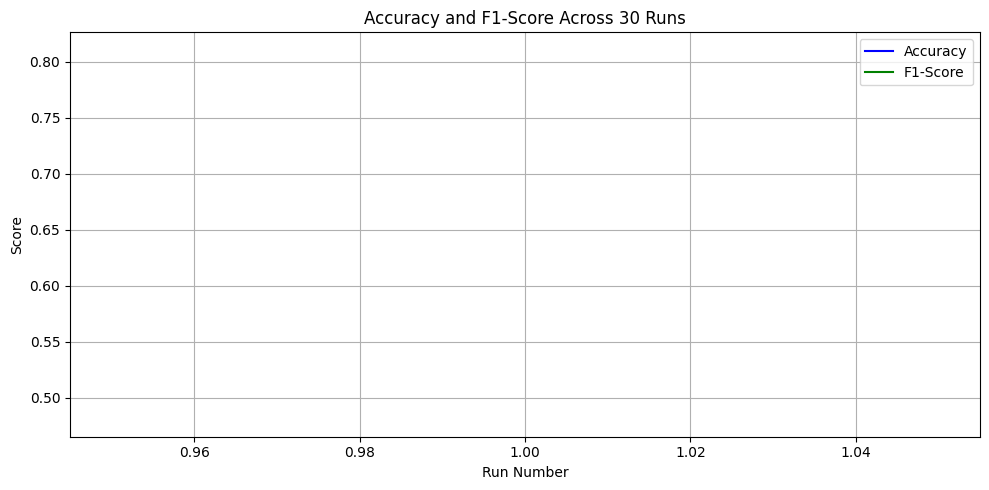

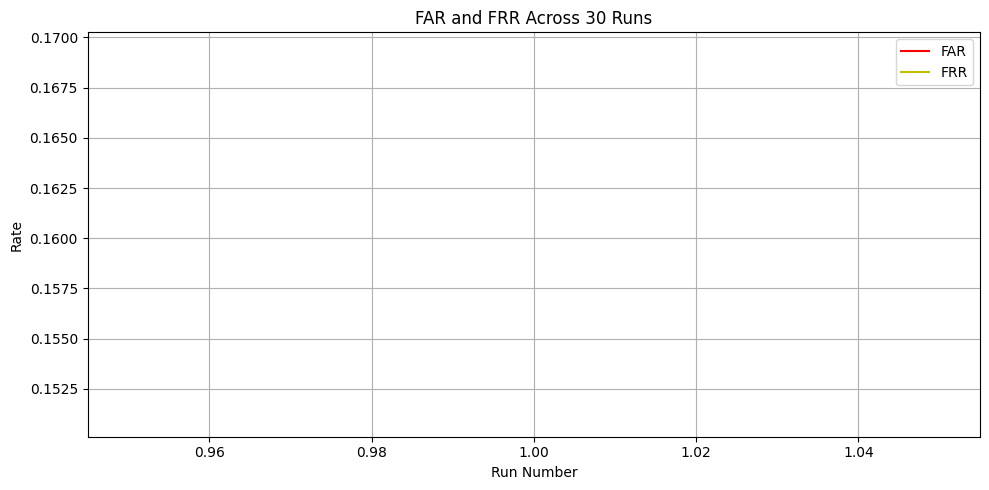


📊 OVERALL AVERAGE METRICS ACROSS ALL RUNS:
  ✅ Average Accuracy:  0.8099
  🎯 Average Precision: 0.3244
  🔁 Average Recall:    0.9350
  📏 Average F1-Score:  0.4815
  ❌ Average FAR:       0.1510
  ❌ Average FRR:       0.1693
  ❗ Average EER:       0.1602


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



# Get unique labels from the dataset
unique_labels = np.unique(new_new_dataset.labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def compute_eer(fpr, tpr):
    fnr = 1 - tpr
    abs_diffs = np.abs(fpr - fnr)
    min_index = np.argmin(abs_diffs)
    eer = (fpr[min_index] + fnr[min_index]) / 2
    return eer

def normalize_batch(x):
    mean = x.mean(dim=(1, 2), keepdim=True)
    std = x.std(dim=(1, 2), keepdim=True) + 1e-6
    return (x - mean) / std

class AdaptiveMSELoss(nn.Module):
    """Adaptive MSE loss that dynamically adjusts weights based on reconstruction difficulty"""
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss(reduction='none')
        
    def forward(self, pred, target):
        # Calculate element-wise MSE
        element_mse = self.mse(pred, target)
        
        # Calculate sample-wise loss (mean across all dimensions except batch)
        sample_mse = element_mse.mean(dim=(1, 2))
        
        # Calculate weights inversely proportional to the loss
        # Higher loss = harder sample = higher weight
        weights = torch.softmax(sample_mse / self.alpha, dim=0)
        
        # Apply weights to individual losses
        weighted_loss = (sample_mse * weights).sum()
        
        return weighted_loss

def train_one_class(label_id, num_epochs=50, batch_size=32, lr=1e-3, train_ratio=0.8, plot=False):
    print(f"\n🚀 Training Autoencoder for label {label_id} (User ID: {label_id})\n{'-'*60}")

    target_indices = [i for i, l in enumerate(new_new_dataset.labels) if l == label_id]
    non_target_indices = [i for i, l in enumerate(new_new_dataset.labels) if l != label_id]

    # Split target indices into training and validation subsets
    train_target_indices, val_target_indices = train_test_split(
        target_indices, train_size=train_ratio, random_state=42
    )

    # Create datasets
    train_data = torch.utils.data.Subset(new_new_dataset, train_target_indices)
    val_target_data = torch.utils.data.Subset(new_new_dataset, val_target_indices)
    val_non_target_data = torch.utils.data.Subset(new_new_dataset, non_target_indices)

    # Print dataset sizes
    print(f"Dataset split for User ID: {label_id}:")
    print(f"  - Training target samples: {len(train_target_indices)}")
    print(f"  - Validation target samples: {len(val_target_indices)}")
    print(f"  - Validation non-target samples: {len(non_target_indices)}")

    # Combine target + non-target for validation
    val_data = torch.utils.data.ConcatDataset([val_target_data, val_non_target_data])

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Use the InertialMFCCFusionAutoencoder model
    model = InertialMFCCLSTMAutoencoder(
        inertial_dim=12, mfcc_dim=13,
        hidden_dim=64
    ).to(device)
    
    # Ensure model parameters are float32
    model = model.float()

    # Use adaptive loss instead of standard MSE
    criterion = AdaptiveMSELoss(alpha=0.1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

    train_loss_history = []
    eval_loss_history = []
    f1_score_history = []

    for epoch in range(num_epochs):
        # === Training ===
        model.train()
        total_loss = 0
        for batch in train_loader:
            # Ensure input tensors are float32
            inertial = normalize_batch(batch['derivative_rms'].float().to(device))
            mfcc = normalize_batch(batch['mfcc'].float().to(device))

            optimizer.zero_grad()
            inertial_pred, mfcc_pred = model(inertial, mfcc)

            # Make sure the sequence lengths match
            if inertial.shape[1] != inertial_pred.shape[1]:
                inertial = torch.nn.functional.interpolate(
                    inertial.transpose(1, 2),
                    size=inertial_pred.shape[1],
                    mode='linear',
                    align_corners=False
                ).transpose(1, 2)
            
            # Make sure the feature dimensions match
            if inertial.shape[2] != inertial_pred.shape[2]:
                min_dim = min(inertial.shape[2], inertial_pred.shape[2])
                inertial = inertial[:, :, :min_dim]
                inertial_pred = inertial_pred[:, :, :min_dim]
            
            # Do the same for MFCC
            if mfcc.shape[1] != mfcc_pred.shape[1]:
                mfcc = torch.nn.functional.interpolate(
                    mfcc.transpose(1, 2),
                    size=mfcc_pred.shape[1],
                    mode='linear',
                    align_corners=False
                ).transpose(1, 2)
            
            if mfcc.shape[2] != mfcc_pred.shape[2]:
                min_dim = min(mfcc.shape[2], mfcc_pred.shape[2])
                mfcc = mfcc[:, :, :min_dim]
                mfcc_pred = mfcc_pred[:, :, :min_dim]

            # Compute loss
            inertial_loss = criterion(inertial_pred, inertial)
            mfcc_loss = criterion(mfcc_pred, mfcc)
            loss = inertial_loss + mfcc_loss
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # === Evaluation ===
        model.eval()
        eval_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                # Ensure input tensors are float32
                inertial = normalize_batch(batch['derivative_rms'].float().to(device))
                mfcc = normalize_batch(batch['mfcc'].float().to(device))
                
                inertial_pred, mfcc_pred = model(inertial, mfcc)

                # Make sure the sequence lengths match
                if inertial.shape[1] != inertial_pred.shape[1]:
                    inertial = torch.nn.functional.interpolate(
                        inertial.transpose(1, 2),
                        size=inertial_pred.shape[1],
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)
                
                # Make sure the feature dimensions match
                if inertial.shape[2] != inertial_pred.shape[2]:
                    # Truncate the larger one to match the smaller one
                    min_dim = min(inertial.shape[2], inertial_pred.shape[2])
                    inertial = inertial[:, :, :min_dim]
                    inertial_pred = inertial_pred[:, :, :min_dim]
                
                # Do the same for MFCC
                if mfcc.shape[1] != mfcc_pred.shape[1]:
                    mfcc = torch.nn.functional.interpolate(
                        mfcc.transpose(1, 2),
                        size=mfcc_pred.shape[1],
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)
                
                # Make sure the feature dimensions match
                if mfcc.shape[2] != mfcc_pred.shape[2]:
                    # Truncate the larger one to match the smaller one
                    min_dim = min(mfcc.shape[2], mfcc_pred.shape[2])
                    mfcc = mfcc[:, :, :min_dim]
                    mfcc_pred = mfcc_pred[:, :, :min_dim]

                inertial_loss = criterion(inertial_pred, inertial)
                mfcc_loss = criterion(mfcc_pred, mfcc)
                loss = inertial_loss + mfcc_loss
                eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(val_loader)
        eval_loss_history.append(avg_eval_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(avg_eval_loss)
        
        # Calculate F1 score for this epoch
        def get_reconstruction_errors(loader):
            errors = []
            with torch.no_grad():
                for batch in loader:
                    inertial = normalize_batch(batch['derivative_rms'].to(device))
                    mfcc = normalize_batch(batch['mfcc'].to(device))
                    inertial_pred, mfcc_pred = model(inertial, mfcc)
                    
                    # Make sure the sequence lengths match
                    if inertial.shape[1] != inertial_pred.shape[1]:
                        inertial = torch.nn.functional.interpolate(
                            inertial.transpose(1, 2),
                            size=inertial_pred.shape[1],
                            mode='linear',
                            align_corners=False
                        ).transpose(1, 2)
                    
                    # Make sure the feature dimensions match
                    if inertial.shape[2] != inertial_pred.shape[2]:
                        # Truncate the larger one to match the smaller one
                        min_dim = min(inertial.shape[2], inertial_pred.shape[2])
                        inertial = inertial[:, :, :min_dim]
                        inertial_pred = inertial_pred[:, :, :min_dim]
                    
                    # Do the same for MFCC
                    if mfcc.shape[1] != mfcc_pred.shape[1]:
                        mfcc = torch.nn.functional.interpolate(
                            mfcc.transpose(1, 2),
                            size=mfcc_pred.shape[1],
                            mode='linear',
                            align_corners=False
                        ).transpose(1, 2)
                    
                    # Make sure the feature dimensions match
                    if mfcc.shape[2] != mfcc_pred.shape[2]:
                        # Truncate the larger one to match the smaller one
                        min_dim = min(mfcc.shape[2], mfcc_pred.shape[2])
                        mfcc = mfcc[:, :, :min_dim]
                        mfcc_pred = mfcc_pred[:, :, :min_dim]
                    
                    # Use standard MSE for error calculation
                    loss = ((inertial_pred - inertial) ** 2).mean(dim=(1, 2)) + \
                           ((mfcc_pred - mfcc) ** 2).mean(dim=(1, 2))
                    errors.extend(loss.cpu().numpy())
            return np.array(errors)

        target_errors = get_reconstruction_errors(
            torch.utils.data.DataLoader(val_target_data, batch_size=batch_size, shuffle=False)
        )
        non_target_errors = get_reconstruction_errors(
            torch.utils.data.DataLoader(val_non_target_data, batch_size=batch_size, shuffle=False)
        )

        # Use adaptive threshold based on distribution of target errors
        threshold = np.percentile(target_errors, 95)
        y_true = np.concatenate([np.ones_like(target_errors), np.zeros_like(non_target_errors)])
        y_scores = np.concatenate([target_errors, non_target_errors])
        y_pred = (y_scores <= threshold).astype(int)
        
        epoch_f1 = f1_score(y_true, y_pred, zero_division=0)
        f1_score_history.append(epoch_f1)

        if plot:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Eval Loss: {avg_eval_loss:.4f} - F1 Score: {epoch_f1:.4f}")

    # Plot training and validation loss
    if plot:
        plt.figure(figsize=(10, 5))
        epochs = range(1, num_epochs + 1)
        plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
        plt.plot(epochs, eval_loss_history, 'r-', label='Validation Loss')
        plt.title(f'Training and Validation Loss for User ID: {label_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Plot F1 score over epochs
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, f1_score_history, 'g-', label='F1 Score')
        plt.title(f'F1 Score Over Epochs for User ID: {label_id}')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # === Final Evaluation for Metrics ===
    def get_reconstruction_errors(loader):
        errors = []
        with torch.no_grad():
            for batch in loader:
                inertial = normalize_batch(batch['derivative_rms'].to(device))
                mfcc = normalize_batch(batch['mfcc'].to(device))
                inertial_pred, mfcc_pred = model(inertial, mfcc)
                
                # Make sure the sequence lengths match
                if inertial.shape[1] != inertial_pred.shape[1]:
                    inertial = torch.nn.functional.interpolate(
                        inertial.transpose(1, 2),
                        size=inertial_pred.shape[1],
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)
                
                # Make sure the feature dimensions match
                if inertial.shape[2] != inertial_pred.shape[2]:
                    # Truncate the larger one to match the smaller one
                    min_dim = min(inertial.shape[2], inertial_pred.shape[2])
                    inertial = inertial[:, :, :min_dim]
                    inertial_pred = inertial_pred[:, :, :min_dim]
                
                # Do the same for MFCC
                if mfcc.shape[1] != mfcc_pred.shape[1]:
                    mfcc = torch.nn.functional.interpolate(
                        mfcc.transpose(1, 2),
                        size=mfcc_pred.shape[1],
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)
                
                # Make sure the feature dimensions match
                if mfcc.shape[2] != mfcc_pred.shape[2]:
                    # Truncate the larger one to match the smaller one
                    min_dim = min(mfcc.shape[2], mfcc_pred.shape[2])
                    mfcc = mfcc[:, :, :min_dim]
                    mfcc_pred = mfcc_pred[:, :, :min_dim]
                
                loss = ((inertial_pred - inertial) ** 2).mean(dim=(1, 2)) + \
                       ((mfcc_pred - mfcc) ** 2).mean(dim=(1, 2))
                errors.extend(loss.cpu().numpy())
        return np.array(errors)

    target_errors = get_reconstruction_errors(
        torch.utils.data.DataLoader(val_target_data, batch_size=batch_size, shuffle=False)
    )
    non_target_errors = get_reconstruction_errors(
        torch.utils.data.DataLoader(val_non_target_data, batch_size=batch_size, shuffle=False)
    )

    threshold = np.percentile(target_errors, 95)
    y_true = np.concatenate([np.ones_like(target_errors), np.zeros_like(non_target_errors)])
    y_scores = np.concatenate([target_errors, non_target_errors])
    y_pred = (y_scores <= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true, -y_scores)
    eer = compute_eer(fpr, tpr)
    far = fpr[np.argmin(np.abs(fpr - (1 - tpr)))]
    frr = 1 - tpr[np.argmin(np.abs(fpr - (1 - tpr)))]

    cm = confusion_matrix(y_true, y_pred)
    print(f"\n📊 Evaluation Results for Label {label_id}:")
    print(f"  ✅ Accuracy:  {acc:.4f}")
    print(f"  🎯 Precision: {precision:.4f}")
    print(f"  🔁 Recall:    {recall:.4f}")
    print(f"  📏 F1-Score:  {f1:.4f}")
    print(f"  ❌ FAR:       {far:.4f}")
    print(f"  ❌ FRR:       {frr:.4f}")
    print(f"  ❗ EER:       {eer:.4f}")
    print("  🔢 Confusion Matrix:")
    print(cm)

    # 📈 Plot ROC Curve
    if plot: 
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f'Label {label_id} (EER: {eer:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate (FAR)')
        plt.ylabel('True Positive Rate (1 - FRR)')
        plt.title(f'ROC Curve for Label {label_id}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return acc, precision, recall, f1, far, frr, eer, train_loss_history, eval_loss_history, f1_score_history

# 🚀 Run training for each label 30 times and track metrics
# === Initialize metrics collection across runs ===
num_runs = 1
run_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'far': [],
    'frr': [],
    'eer': []
}

all_train_losses = {}
all_eval_losses = {}
all_f1_scores = {}

# Run the training 30 times
for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    
    # Collect metrics for this run
    run_all_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'far': [],
        'frr': [],
        'eer': []
    }
    
    for label in unique_labels:
        acc, precision, recall, f1, far, frr, eer, train_loss_history, eval_loss_history, f1_score_history = train_one_class(label, num_epochs=75)
        run_all_metrics['accuracy'].append(acc)
        run_all_metrics['precision'].append(precision)
        run_all_metrics['recall'].append(recall)
        run_all_metrics['f1'].append(f1)
        run_all_metrics['far'].append(far)
        run_all_metrics['frr'].append(frr)
        run_all_metrics['eer'].append(eer)
        
        if run == 0:  # Only store loss histories from first run
            all_train_losses[label] = train_loss_history
            all_eval_losses[label] = eval_loss_history
            all_f1_scores[label] = f1_score_history
    
    # Calculate average metrics for this run
    for metric in run_metrics:
        avg_value = np.mean(run_all_metrics[metric])
        run_metrics[metric].append(avg_value)
    
    # Display average metrics for this run
    print("\n" + "="*60)
    print(f"📊 AVERAGE METRICS FOR RUN {run+1}:")
    print("="*60)
    print(f"  ✅ Average Accuracy:  {np.mean(run_all_metrics['accuracy']):.4f}")
    print(f"  🎯 Average Precision: {np.mean(run_all_metrics['precision']):.4f}")
    print(f"  🔁 Average Recall:    {np.mean(run_all_metrics['recall']):.4f}")
    print(f"  📏 Average F1-Score:  {np.mean(run_all_metrics['f1']):.4f}")
    print(f"  ❌ Average FAR:       {np.mean(run_all_metrics['far']):.4f}")
    print(f"  ❌ Average FRR:       {np.mean(run_all_metrics['frr']):.4f}")
    print(f"  ❗ Average EER:       {np.mean(run_all_metrics['eer']):.4f}")

# Plot Accuracy and F1-Score across runs
plt.figure(figsize=(10, 5))
x = range(1, num_runs + 1)
plt.plot(x, run_metrics['accuracy'], 'b-', label='Accuracy')
plt.plot(x, run_metrics['f1'], 'g-', label='F1-Score')
plt.xlabel('Run Number')
plt.ylabel('Score')
plt.title('Accuracy and F1-Score Across 30 Runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot FAR and FRR across runs
plt.figure(figsize=(10, 5))
plt.plot(x, run_metrics['far'], 'r-', label='FAR')
plt.plot(x, run_metrics['frr'], 'y-', label='FRR')
plt.xlabel('Run Number')
plt.ylabel('Rate')
plt.title('FAR and FRR Across 30 Runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display overall average metrics
print("\n" + "="*60)
print("📊 OVERALL AVERAGE METRICS ACROSS ALL RUNS:")
print("="*60)
print(f"  ✅ Average Accuracy:  {np.mean(run_metrics['accuracy']):.4f}")
print(f"  🎯 Average Precision: {np.mean(run_metrics['precision']):.4f}")
print(f"  🔁 Average Recall:    {np.mean(run_metrics['recall']):.4f}")
print(f"  📏 Average F1-Score:  {np.mean(run_metrics['f1']):.4f}")
print(f"  ❌ Average FAR:       {np.mean(run_metrics['far']):.4f}")
print(f"  ❌ Average FRR:       {np.mean(run_metrics['frr']):.4f}")
print(f"  ❗ Average EER:       {np.mean(run_metrics['eer']):.4f}")
print("="*60)


# Spectrogram + Inetrita 

## Classifer Spectro  

### Model- CNN Trans

In [24]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: [1, max_len, d_model]

        # This makes pe move to the right device with the model
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, time_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class SpectrogramTransformerClassifier(nn.Module):
    def __init__(self, 
                 freq_dim,
                 time_dim,
                 num_classes,
                 d_model=128,
                 nhead=8,
                 num_layers=3,
                 dropout=0.1):
        super().__init__()

        # Convolutional encoder
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, d_model, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(d_model),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Calculate resulting dimensions
        self.freq_encoded = freq_dim // 8
        self.time_encoded = time_dim // 8

        # Linear projection
        self.projection = nn.Linear(d_model * self.freq_encoded, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True  # Important for input shape [B, T, D]
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # Input: [B, 1, F, T]
        batch_size = x.size(0)

        x = self.conv_encoder(x)  # [B, d_model, F', T']
        x = x.permute(0, 3, 1, 2)  # [B, T', d_model, F']
        x = x.reshape(batch_size, self.time_encoded, -1)  # [B, T', d_model * F']

        x = self.projection(x)  # [B, T', d_model]
        x = self.pos_encoder(x)  # [B, T', d_model]
        x = self.transformer_encoder(x)  # [B, T', d_model]
        x = x.mean(dim=1)  # Global average pooling over time

        return self.classifier(x)  # [B, num_classes]


### Model- CNN LSTM

In [57]:
import torch
import torch.nn as nn

class SpectrogramCNNLSTMClassifier(nn.Module):
    def __init__(self, 
                 freq_dim,         # e.g., 257
                 time_dim,         # e.g., 40
                 num_classes,
                 hidden_size=128,
                 lstm_layers=1,
                 dropout=0.1):
        super().__init__()

        # Convolutional encoder
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # F: 257 -> 128

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # F: 128 -> 64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # F: 64 -> 32
        )

        # Compute output shapes after CNN for reshaping
        self.freq_encoded = freq_dim // 8   # 257 -> ~32
        self.time_encoded = time_dim // 8   # 40 -> ~5

        # LSTM input dim = feature dim across frequency after CNN
        self.lstm_input_dim = 128 * self.freq_encoded

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_dim,
            hidden_size=hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        # x: [B, 1, F, T]
        batch_size = x.size(0)

        x = self.conv_encoder(x)  # [B, 128, F', T']
        x = x.permute(0, 3, 1, 2)  # [B, T', C, F']
        x = x.reshape(batch_size, self.time_encoded, -1)  # [B, T', C × F']

        x, _ = self.lstm(x)  # [B, T', 2*hidden]
        x = x.mean(dim=1)    # Temporal average pooling

        return self.classifier(x)  # [B, num_classes]


### Train classifer

In [55]:



def train_spectrogram_classifier(model, train_loader, val_loader, num_epochs=50, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    best_val_acc = 0
    train_losses = []
    val_accuracies = []
    
    # Print model summary and initial batch info
    print(f"Model device: {next(model.parameters()).device}")
    
    # Get a sample batch to check dimensions
    sample_batch = next(iter(train_loader))
    print(f"Sample batch specs shape: {sample_batch['spectrogram'].shape}")
    print(f"Sample batch labels shape: {sample_batch['label'].shape}")
    print(f"Sample batch labels range: {sample_batch['label'].min()} to {sample_batch['label'].max()}")
    print(f"Number of unique labels: {len(torch.unique(sample_batch['label']))}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        for batch_idx, batch in enumerate(train_loader):
            try:
                # Ensure spectrograms are float and labels are long
                spectrograms = batch['spectrogram'].unsqueeze(1).float().to(device)
                labels = batch['label'].long().to(device)
                
                # Debug information for first batch
                if epoch == 0 and batch_idx == 0:
                    print(f"\nFirst batch shapes:")
                    print(f"Spectrograms: {spectrograms.shape}")
                    print(f"Labels: {labels.shape}")
                    print(f"Labels: {labels}")
                
                optimizer.zero_grad()
                outputs = model(spectrograms)
                
                # Debug information for first batch
                if epoch == 0 and batch_idx == 0:
                    print(f"Model output shape: {outputs.shape}")
                    print(f"Model output device: {outputs.device}")
                    print(f"Labels device: {labels.device}")
                
                if not torch.all((labels >= 0) & (labels < outputs.shape[1])):
                    print(f"[ERROR] Invalid label detected in batch {batch_idx}!")
                    print(f"Labels: {labels}")
                    print(f"Output shape: {outputs.shape}")
                    raise ValueError("Label value out of bounds for CrossEntropyLoss.")

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                
            except Exception as e:
                print(f"Error in batch {batch_idx}:")
                print(f"Spectrogram shape: {spectrograms.shape}")
                print(f"Labels shape: {labels.shape}")
                print(f"Unique labels in batch: {torch.unique(labels)}")
                raise e
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        val_loss = 0
        
        with torch.no_grad():
            for batch in val_loader:
                spectrograms = batch['spectrogram'].unsqueeze(1).float().to(device)
                labels = batch['label'].long().to(device)
                
                outputs = model(spectrograms)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        avg_val_loss = val_loss / len(val_loader)
        
        scheduler.step(avg_val_loss)
        
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save({
                'model_state_dict': model.state_dict(),
            }, 'best_spectrogram_classifier.pth')
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        print('-' * 50)
    
    return train_losses, val_accuracies

def prepare_training(dataset,model='cnn_lstm'):
    """
    Prepare the model and data loaders
    """
    # Split dataset
    from torch.utils.data import DataLoader, random_split
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



    # Get spectrogram dimensions
    sample = dataset[0]
    freq_dim = sample['spectrogram'].shape[0]
    time_dim = sample['spectrogram'].shape[1]
    
    # Get unique labels and create a continuous mapping
    all_labels = dataset.labels
    unique_labels = sorted(set(all_labels))
    num_classes = len(unique_labels)
    
    print(f"Dataset statistics:")
    print(f"Frequency dimension: {freq_dim}")
    print(f"Time dimension: {time_dim}")
    print(f"Original unique labels: {unique_labels}")
    print(f"Number of classes: {num_classes}")
    # Create model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if model == 'transformer':  
        model = SpectrogramTransformerClassifier(
            freq_dim=freq_dim,
            time_dim=time_dim,
            num_classes=num_classes,
            d_model=128,
            nhead=8,
            num_layers=3
        ).to(device)
    elif model == 'cnn_lstm':
        model = SpectrogramCNNLSTMClassifier(
            freq_dim=freq_dim,
            time_dim=time_dim,
            num_classes=num_classes,
        ).to(device)
    else:
        raise ValueError(f"Unknown model type: {model}")


    return model, train_loader, val_loader, device

# Usage:
"""
# Make sure your dataset is properly initialized
model, train_loader, val_loader, device = prepare_training(dataset)

# Train the model
train_losses, val_accuracies = train_spectrogram_classifier(
    model, 
    train_loader, 
    val_loader,
    num_epochs=50,
    device=device
)
"""

'\n# Make sure your dataset is properly initialized\nmodel, train_loader, val_loader, device = prepare_training(dataset)\n\n# Train the model\ntrain_losses, val_accuracies = train_spectrogram_classifier(\n    model, \n    train_loader, \n    val_loader,\n    num_epochs=50,\n    device=device\n)\n'

Dataset statistics:
Frequency dimension: 257
Time dimension: 38
Original unique labels: [np.int64(0), np.int64(1), np.int64(2)]
Number of classes: 3
[np.int64(0), np.int64(1), np.int64(2)]
Model device: cuda:0
Sample batch specs shape: torch.Size([32, 257, 38])
Sample batch labels shape: torch.Size([32])
Sample batch labels range: 0 to 2
Number of unique labels: 3

First batch shapes:
Spectrograms: torch.Size([32, 1, 257, 38])
Labels: torch.Size([32])
Labels: tensor([1, 0, 2, 2, 2, 1, 0, 0, 2, 1, 0, 0, 1, 2, 2, 1, 0, 2, 2, 1, 0, 0, 1, 2,
        1, 0, 1, 2, 1, 1, 2, 2], device='cuda:0')
Model output shape: torch.Size([32, 3])
Model output device: cuda:0
Labels device: cuda:0
Epoch [1/55]
Training Loss: 1.1591
Validation Accuracy: 31.11%
--------------------------------------------------
Epoch [2/55]
Training Loss: 1.1291
Validation Accuracy: 31.11%
--------------------------------------------------
Epoch [3/55]
Training Loss: 1.1036
Validation Accuracy: 31.11%
-------------------------

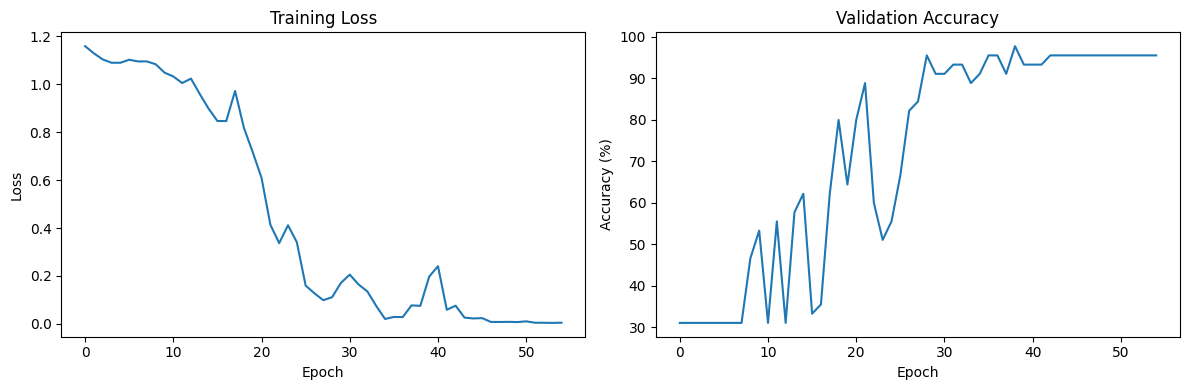

In [27]:
import os
model, train_loader, val_loader, device = prepare_training(new_new_dataset)
all_labels = new_new_dataset.labels
print(sorted(set(all_labels)))  # e.g. [5, 6, 7]


# Train the model
train_losses, val_accuracies = train_spectrogram_classifier(
    model, 
    train_loader, 
    val_loader,
    num_epochs=55,
    device=device
)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()

Dataset statistics:
Frequency dimension: 257
Time dimension: 38
Original unique labels: [np.int64(0), np.int64(1), np.int64(2)]
Number of classes: 3
[np.int64(0), np.int64(1), np.int64(2)]
Model device: cuda:0
Sample batch specs shape: torch.Size([32, 257, 38])
Sample batch labels shape: torch.Size([32])
Sample batch labels range: 0 to 2
Number of unique labels: 3

First batch shapes:
Spectrograms: torch.Size([32, 1, 257, 38])
Labels: torch.Size([32])
Labels: tensor([1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 1, 2, 2, 0, 0, 0, 1,
        0, 0, 1, 2, 2, 0, 1, 1], device='cuda:0')
Model output shape: torch.Size([32, 3])
Model output device: cuda:0
Labels device: cuda:0


c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/55]
Training Loss: 1.0987
Validation Accuracy: 33.33%
--------------------------------------------------
Epoch [2/55]
Training Loss: 1.0352
Validation Accuracy: 35.56%
--------------------------------------------------
Epoch [3/55]
Training Loss: 0.9410
Validation Accuracy: 55.56%
--------------------------------------------------
Epoch [4/55]
Training Loss: 0.8200
Validation Accuracy: 62.22%
--------------------------------------------------
Epoch [5/55]
Training Loss: 0.7003
Validation Accuracy: 60.00%
--------------------------------------------------
Epoch [6/55]
Training Loss: 0.5639
Validation Accuracy: 84.44%
--------------------------------------------------
Epoch [7/55]
Training Loss: 0.3826
Validation Accuracy: 57.78%
--------------------------------------------------
Epoch [8/55]
Training Loss: 0.2838
Validation Accuracy: 88.89%
--------------------------------------------------
Epoch [9/55]
Training Loss: 0.2051
Validation Accuracy: 88.89%
-------------------------

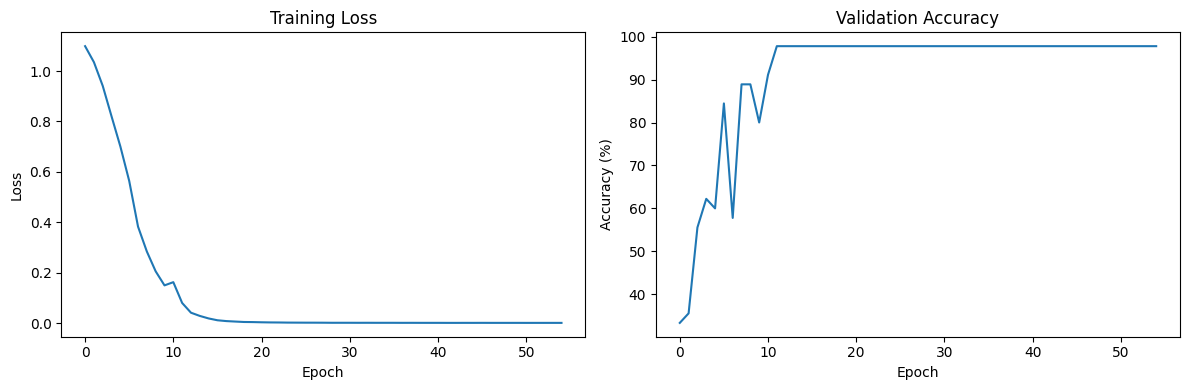

In [58]:
import os
model, train_loader, val_loader, device = prepare_training(new_new_dataset)
all_labels = new_new_dataset.labels
print(sorted(set(all_labels)))  # e.g. [5, 6, 7]


# Train the model
train_losses, val_accuracies = train_spectrogram_classifier(
    model, 
    train_loader, 
    val_loader,
    num_epochs=55,
    device=device
)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()

## Binarcy Class  Inetita + Spec

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MidFusionLSTMClassifier(nn.Module):
    def __init__(self,
                 rms_input_dim=12,             # 12 features per time step
                 rms_seq_len=12,               # 12 time steps
                 spectrogram_shape=(257, 38),  # (freq_bins, time_steps)
                 rms_hidden_size=64,
                 spec_hidden_size=64,
                 fusion_hidden_size=64):
        super(MidFusionLSTMClassifier, self).__init__()

        # LSTM for Derivative RMS features
        self.rms_lstm = nn.LSTM(
            input_size=rms_input_dim,
            hidden_size=rms_hidden_size,
            batch_first=True,
            bidirectional=False
        )

        # LSTM for Spectrogram (treat time as sequence, freq as feature)
        self.spec_lstm = nn.LSTM(
            input_size=spectrogram_shape[0],  # freq_bins = 257
            hidden_size=spec_hidden_size,
            batch_first=True,
            bidirectional=False
        )

        # Fusion + Classifier
        self.fc1 = nn.Linear(rms_hidden_size + spec_hidden_size, fusion_hidden_size)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(fusion_hidden_size, 1)  # Binary classification

    def forward(self, derivative_rms, spectrogram):
        # derivative_rms: (B, 12, 12)
        # spectrogram: (B, 257, 38) → transpose to (B, 38, 257)
        spec_input = spectrogram.permute(0, 2, 1)  # (B, 38, 257)

        # LSTM on derivative RMS
        _, (rms_hn, _) = self.rms_lstm(derivative_rms)  # rms_hn: (1, B, H)
        rms_feat = rms_hn.squeeze(0)  # (B, rms_hidden_size)

        # LSTM on spectrogram
        _, (spec_hn, _) = self.spec_lstm(spec_input)  # spec_hn: (1, B, H)
        spec_feat = spec_hn.squeeze(0)  # (B, spec_hidden_size)

        # Mid-fusion
        fused = torch.cat((rms_feat, spec_feat), dim=1)  # (B, rms_H + spec_H)
        x = F.relu(self.fc1(fused))
        x = self.dropout(x)
        output = torch.sigmoid(self.fc2(x))  # (B, 1)

        return output.squeeze(1)  # (B,)



In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# === Evaluation Metrics ===
def compute_metrics(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fpr - fnr))
    eer = fpr[eer_index]
    acc = accuracy_score(y_true, y_scores >= 0.5)
    return acc, fpr[eer_index], fnr[eer_index], eer

# === Main Training Loop (One model per label, binary setting) ===
def train_binary_classifiers(dataset, batch_size=32, epochs=10, lr=1e-3, train_split_ratio=0.8):


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {}
    all_train_losses = {}
    all_val_losses = {}
    all_val_accuracies = {}
    all_metrics = {"accuracy": [], "far": [], "frr": [], "eer": []}

    unique_labels = np.unique(dataset.labels)

    for label in unique_labels:
        print(f"\nTraining for label {label} (1 vs rest)")

        # Binary label transformation
        def binary_collate_fn(batch):
            rms = torch.tensor([b['derivative_rms'] for b in batch], dtype=torch.float32)
            spec = torch.tensor([b['spectrogram'] for b in batch], dtype=torch.float32)
            lbl = torch.tensor([1.0 if b['label'] == label else 0.0 for b in batch], dtype=torch.float32)
            return rms, spec, lbl

        # === Split dataset ===
        indices = np.arange(len(dataset))
        target_indices = [i for i in indices if dataset[i]['label'] == label]
        non_target_indices = [i for i in indices if dataset[i]['label'] != label]

        def split_indices(class_indices):
            np.random.shuffle(class_indices)
            split = int(len(class_indices) * train_split_ratio)
            return class_indices[:split], class_indices[split:]

        train_target, val_target = split_indices(target_indices)
        train_non_target, val_non_target = split_indices(non_target_indices)

        train_idx = train_target + train_non_target
        val_idx = val_target + val_non_target

        train_ds = Subset(dataset, train_idx)
        val_ds = Subset(dataset, val_idx)

        # === Count samples ===
        print(f"Train samples - Target: {len(train_target)}, Non-target: {len(train_non_target)}")
        print(f"Val   samples - Target: {len(val_target)}, Non-target: {len(val_non_target)}")

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=binary_collate_fn)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=binary_collate_fn)

        model = MidFusionLSTMClassifier().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.BCELoss()

        train_losses = []
        val_losses = []
        val_accuracies = []

        for epoch in range(epochs):
            # === Training ===
            model.train()
            total_train_loss = 0
            for rms, spec, lbl in train_loader:
                rms, spec, lbl = rms.to(device), spec.to(device), lbl.to(device)
                optimizer.zero_grad()
                outputs = model(rms, spec)
                loss = criterion(outputs, lbl)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
            train_losses.append(total_train_loss)

            # === Validation ===
            model.eval()
            total_val_loss = 0
            y_val_true, y_val_pred = [], []
            with torch.no_grad():
                for rms, spec, lbl in val_loader:
                    rms, spec, lbl = rms.to(device), spec.to(device), lbl.to(device)
                    outputs = model(rms, spec)
                    loss = criterion(outputs, lbl)
                    total_val_loss += loss.item()
                    y_val_true.extend(lbl.cpu().numpy())
                    y_val_pred.extend(outputs.cpu().numpy())
            val_losses.append(total_val_loss)
            val_acc = accuracy_score(y_val_true, np.array(y_val_pred) >= 0.5)
            val_accuracies.append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}, Val Acc: {val_acc:.4f}")

        all_train_losses[int(label)] = train_losses
        all_val_losses[int(label)] = val_losses
        all_val_accuracies[int(label)] = val_accuracies

        # === Final Metrics ===
        y_true, y_scores = [], []
        with torch.no_grad():
            for rms, spec, lbl in val_loader:
                rms, spec = rms.to(device), spec.to(device)
                outputs = model(rms, spec).cpu().numpy()
                y_scores.extend(outputs)
                y_true.extend(lbl.numpy())

        y_true_bin = np.array(y_true)
        y_pred_bin = np.array(y_scores) >= 0.5
        conf_matrix = confusion_matrix(y_true_bin, y_pred_bin)
        print(f"Confusion Matrix for label {label}:\n{conf_matrix}")

        acc, far, frr, eer = compute_metrics(y_true_bin, np.array(y_scores))
        print(f"[Label {label}] Accuracy: {acc:.4f}, FAR: {far:.4f}, FRR: {frr:.4f}, EER: {eer:.4f}")
        results[int(label)] = {"accuracy": acc, "far": far, "frr": frr, "eer": eer}
        all_metrics["accuracy"].append(acc)
        all_metrics["far"].append(far)
        all_metrics["frr"].append(frr)
        all_metrics["eer"].append(eer)

    # === Summary Metrics ===
    print("\n=== Average Metrics Across All Labels ===")
    for k in all_metrics:
        avg = np.mean(all_metrics[k])
        print(f"{k.upper()}: {avg:.4f}")

    # === Plot Loss Curves ===
    plt.figure(figsize=(12, 6))
    for label in all_train_losses:
        plt.plot(all_train_losses[label], label=f"Train - Label {label}", linestyle='-')
        plt.plot(all_val_losses[label], label=f"Val - Label {label}", linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss per Label")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot Accuracy Curves ===
    plt.figure(figsize=(10, 5))
    for label in all_val_accuracies:
        plt.plot(all_val_accuracies[label], label=f"Val Accuracy - Label {label}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy per Label over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results



Training for label 0 (1 vs rest)
Train samples - Target: 49, Non-target: 130
Val   samples - Target: 13, Non-target: 33
Epoch 1/60, Train Loss: 3.9131, Val Loss: 1.1659, Val Acc: 0.7174
Epoch 2/60, Train Loss: 3.6313, Val Loss: 1.0898, Val Acc: 0.7174
Epoch 3/60, Train Loss: 3.4537, Val Loss: 1.0370, Val Acc: 0.7174
Epoch 4/60, Train Loss: 3.4828, Val Loss: 1.0030, Val Acc: 0.7174
Epoch 5/60, Train Loss: 3.3543, Val Loss: 0.9740, Val Acc: 0.7174
Epoch 6/60, Train Loss: 3.2645, Val Loss: 0.9246, Val Acc: 0.7174
Epoch 7/60, Train Loss: 3.1006, Val Loss: 0.8583, Val Acc: 0.7826
Epoch 8/60, Train Loss: 2.7495, Val Loss: 0.7831, Val Acc: 0.7391
Epoch 9/60, Train Loss: 2.4014, Val Loss: 0.7129, Val Acc: 0.7391
Epoch 10/60, Train Loss: 2.0628, Val Loss: 0.6425, Val Acc: 0.7391
Epoch 11/60, Train Loss: 2.0347, Val Loss: 0.7547, Val Acc: 0.8043
Epoch 12/60, Train Loss: 3.1065, Val Loss: 0.7880, Val Acc: 0.7609
Epoch 13/60, Train Loss: 2.0132, Val Loss: 0.7809, Val Acc: 0.7391
Epoch 14/60, Trai

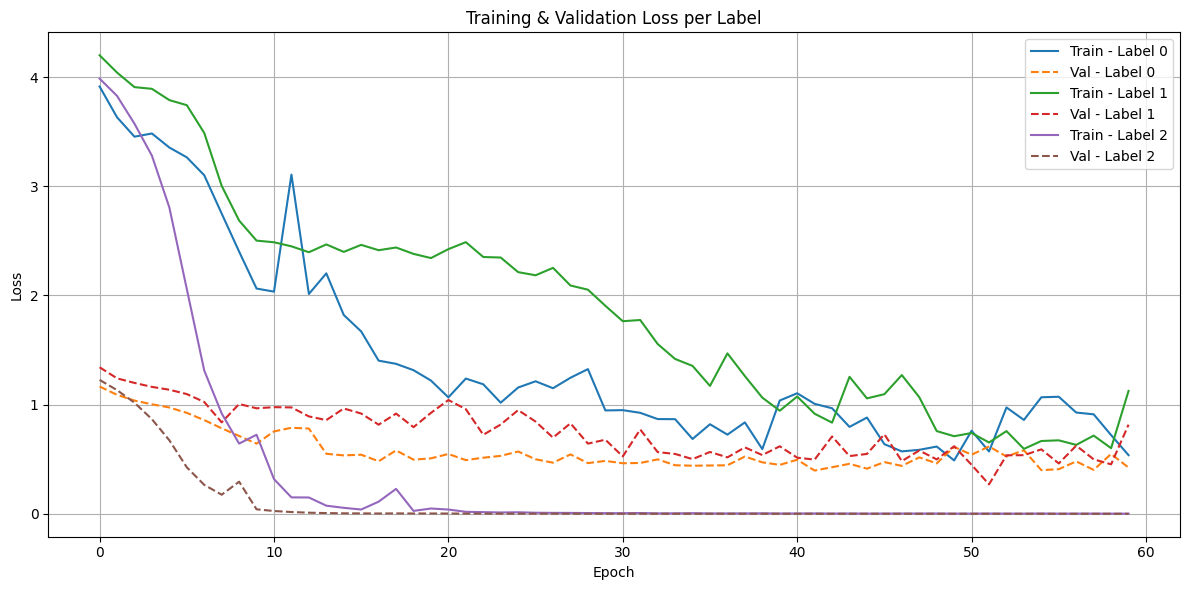

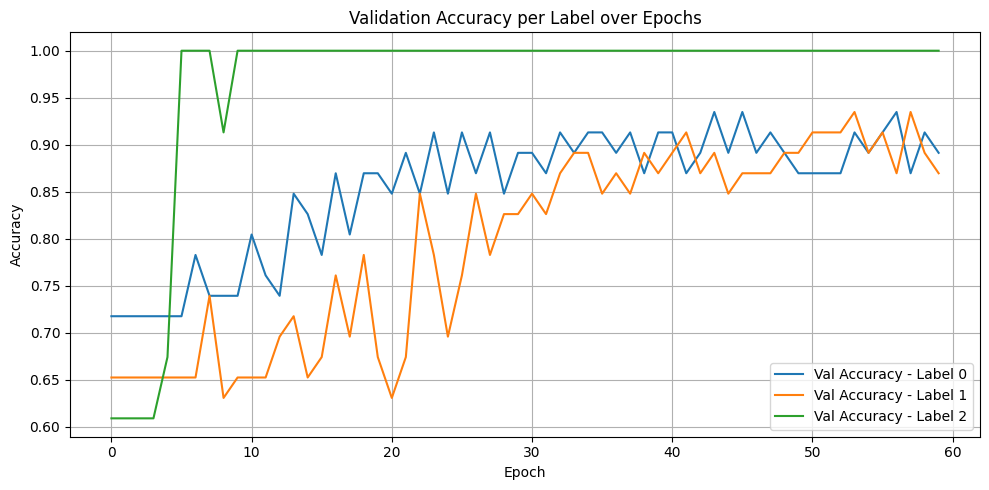

In [68]:
result = train_binary_classifiers(new_new_dataset,epochs=60)

## AE Inerital + SPec

In [236]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MidFusionLSTMAutoencoder(nn.Module):
    def __init__(self,
                 rms_input_dim=12,
                 spec_input_shape=(257, 38),  # (freq_bins, time_steps)
                 d_model=128,
                 hidden_dim=256,
                 num_layers=2,
                 dropout=0.1,
                 num_heads=4,
                 bottleneck_factor=8):  # for multi-head attention and bottleneck compression
        super().__init__()

        self.spec_freq_bins, self.spec_seq_len = spec_input_shape
        self.bottleneck_dim = d_model // bottleneck_factor

        # --------- Embedding layers ---------
        self.rms_embedding = nn.Sequential(
            nn.Linear(rms_input_dim, hidden_dim),
            nn.Linear(hidden_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # Learnable scaling parameter for RMS embedding
        self.rms_scale = nn.Parameter(torch.ones(1))

        self.spec_embedding = nn.Sequential(
            nn.Linear(self.spec_freq_bins, hidden_dim),
            nn.Linear(hidden_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # Learnable scaling parameter for spectrogram embedding
        self.spec_scale = nn.Parameter(torch.ones(1))

        # --------- Modality-specific encoders ---------
        self.rms_encoder = nn.LSTM(
            input_size=d_model,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        self.spec_encoder = nn.LSTM(
            input_size=d_model,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )

        # --------- Projection layers ---------
        self.rms_projection = nn.Linear(hidden_dim * 2, d_model)
        self.spec_projection = nn.Linear(hidden_dim * 2, d_model)

        # --------- Self-Attention Layers ---------
        self.rms_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.spec_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True)
        
        # --------- Modality-Specific Bottlenecks ---------
        self.rms_bottleneck = nn.Sequential(
            nn.Linear(d_model, self.bottleneck_dim),
            nn.LayerNorm(self.bottleneck_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.spec_bottleneck = nn.Sequential(
            nn.Linear(d_model, self.bottleneck_dim),
            nn.LayerNorm(self.bottleneck_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # --------- Fusion Network ---------
        self.fusion_network = nn.Sequential(
            nn.Linear(self.bottleneck_dim * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # --------- Gating Network for Fusion ---------
        self.gate_network = nn.Sequential(
            nn.Linear(self.bottleneck_dim * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Linear(d_model, 2),
            nn.Softmax(dim=-1)
        )
        
        # --------- Expansion layers for decoders ---------
        self.rms_expansion = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.spec_expansion = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # --------- Decoders ---------
        self.rms_decoder = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, rms_input_dim)
        )

        self.spec_decoder = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, self.spec_freq_bins)
        )

    def forward(self, rms_data, spectrogram):
        # rms_data: (B, T1, D)
        # spectrogram: (B, F, T2)

        B = rms_data.size(0)
        T1 = rms_data.size(1)
        T2 = spectrogram.size(2)

        # Transpose spectrogram to (B, T2, F)
        spectrogram = spectrogram.transpose(1, 2)

        # --- Embedding ---
        rms_embed = self.rms_embedding(rms_data)        # (B, T1, D)
        # Apply learnable scaling
        rms_embed = rms_embed * self.rms_scale
        
        spec_embed = self.spec_embedding(spectrogram)   # (B, T2, D)
        # Apply learnable scaling
        spec_embed = spec_embed * self.spec_scale

        # --- Sequence Length Alignment ---
        # Use a common target length for both modalities
        target_len = min(T1, T2)
        
        # Interpolate both sequences to the target length
        rms_aligned = F.interpolate(rms_embed.transpose(1, 2), size=target_len, mode='linear', align_corners=False).transpose(1, 2)
        spec_aligned = F.interpolate(spec_embed.transpose(1, 2), size=target_len, mode='linear', align_corners=False).transpose(1, 2)
        
        # --- Modality-specific encoding ---
        rms_encoded, _ = self.rms_encoder(rms_aligned)  # (B, target_len, hidden_dim*2)
        spec_encoded, _ = self.spec_encoder(spec_aligned)  # (B, target_len, hidden_dim*2)
        
        # --- Projection ---
        rms_projected = self.rms_projection(rms_encoded)  # (B, target_len, d_model)
        spec_projected = self.spec_projection(spec_encoded)  # (B, target_len, d_model)
        
        # --- Modality-Specific Attention ---
        rms_attended, _ = self.rms_attention(rms_projected, rms_projected, rms_projected)
        spec_attended, _ = self.spec_attention(spec_projected, spec_projected, spec_projected)
        
        # --- Modality-Specific Bottlenecks ---
        rms_bottleneck = self.rms_bottleneck(rms_attended)  # (B, target_len, bottleneck_dim)
        spec_bottleneck = self.spec_bottleneck(spec_attended)  # (B, target_len, bottleneck_dim)
        
        # --- Fusion of bottleneck representations ---
        # Concatenate bottleneck features
        concat_bottlenecks = torch.cat([rms_bottleneck, spec_bottleneck], dim=-1)  # (B, target_len, bottleneck_dim*2)
        
        # Compute gating weights
        gates = self.gate_network(concat_bottlenecks)  # (B, target_len, 2)
        
        # Apply gates to each modality's bottleneck
        rms_gate = gates[:, :, 0].unsqueeze(-1)  # (B, target_len, 1)
        spec_gate = gates[:, :, 1].unsqueeze(-1)  # (B, target_len, 1)
        
        # Scale bottlenecks by gates
        rms_gated = rms_bottleneck * rms_gate
        spec_gated = spec_bottleneck * spec_gate
        
        # Concatenate gated bottlenecks and fuse
        fused_representation = self.fusion_network(torch.cat([rms_gated, spec_gated], dim=-1))  # (B, target_len, d_model)
        
        # --- Expansion for decoding ---
        rms_expanded = self.rms_expansion(fused_representation)  # (B, target_len, d_model)
        spec_expanded = self.spec_expansion(fused_representation)  # (B, target_len, d_model)
        
        # --- Decoding ---
        rms_decoded = self.rms_decoder(rms_expanded)  # (B, target_len, rms_input_dim)
        spec_decoded = self.spec_decoder(spec_expanded)  # (B, target_len, spec_freq_bins)
        
        # --- Interpolate back to original dimensions ---
        if target_len != T1:
            rms_recon = F.interpolate(rms_decoded.transpose(1, 2), size=T1, mode='linear', align_corners=False).transpose(1, 2)
        else:
            rms_recon = rms_decoded
            
        if target_len != T2:
            spec_decoded = F.interpolate(spec_decoded.transpose(1, 2), size=T2, mode='linear', align_corners=False).transpose(1, 2)
            
        # Transpose back to match input format (B, F, T2)
        spec_recon = spec_decoded.transpose(1, 2)  # (B, F, T2)

        return rms_recon, spec_recon





In [293]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
            # Removed MaxPool1d to preserve sequence length
        )

    def forward(self, x):
        return self.conv(x)

class ContrastiveMidFusionAutoencoder(nn.Module):
    def __init__(self, rms_input_dim=12, spec_input_shape=(257, 38), d_model=128, hidden_dim=256, num_layers=2, dropout=0.1, num_heads=4, bottleneck_dim=32):
        super().__init__()

        self.spec_freq_bins, self.spec_seq_len = spec_input_shape
        self.bottleneck_dim = bottleneck_dim
        self.rms_input_dim = rms_input_dim

        # CNN blocks (1D over time axis) - keeping same channel dimensions
        self.rms_cnn = ConvBlock1D(rms_input_dim, rms_input_dim)
        self.spec_cnn = ConvBlock1D(self.spec_freq_bins, self.spec_freq_bins)

        self.rms_embedding = nn.Linear(rms_input_dim, d_model)
        self.spec_embedding = nn.Linear(self.spec_freq_bins, d_model)

        self.rms_encoder = nn.LSTM(d_model, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.spec_encoder = nn.LSTM(d_model, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)

        # Temporal attention mechanisms
        self.rms_attn = nn.MultiheadAttention(hidden_dim * 2, num_heads, dropout=dropout, batch_first=True)
        self.spec_attn = nn.MultiheadAttention(hidden_dim * 2, num_heads, dropout=dropout, batch_first=True)

        # Cross-modal attention mechanisms
        self.rms_to_spec_attn = nn.MultiheadAttention(hidden_dim * 2, num_heads, dropout=dropout, batch_first=True)
        self.spec_to_rms_attn = nn.MultiheadAttention(hidden_dim * 2, num_heads, dropout=dropout, batch_first=True)

        # Modality-specific bottlenecks
        self.rms_bottleneck = nn.Sequential(
            nn.Linear(hidden_dim * 2, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, bottleneck_dim)
        )
        
        self.spec_bottleneck = nn.Sequential(
            nn.Linear(hidden_dim * 2, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, bottleneck_dim)
        )

        # Attention-based pooling for bottleneck sequences
        self.rms_pool_attention = nn.Sequential(
            nn.Linear(bottleneck_dim, bottleneck_dim // 2),
            nn.Tanh(),
            nn.Linear(bottleneck_dim // 2, 1)
        )
        
        self.spec_pool_attention = nn.Sequential(
            nn.Linear(bottleneck_dim, bottleneck_dim // 2),
            nn.Tanh(),
            nn.Linear(bottleneck_dim // 2, 1)
        )

        # For contrastive projection head - operates on combined bottleneck
        self.projection_head = nn.Sequential(
            nn.Linear(bottleneck_dim * 2, bottleneck_dim),
            nn.ReLU(),
            nn.Linear(bottleneck_dim, bottleneck_dim)
        )

        # Decoders
        self.decoder_rms = nn.Sequential(
            nn.Linear(bottleneck_dim, d_model),
            nn.ReLU(),
            nn.Linear(d_model, rms_input_dim)
        )
        
        # LSTM-based decoder for spectrogram
        self.spec_decoder_lstm = nn.LSTM(bottleneck_dim, d_model, batch_first=True)
        self.spec_decoder_output = nn.Linear(d_model, self.spec_freq_bins)

    def forward(self, rms, spec):
        batch_size = rms.shape[0]
        rms_seq_len = rms.shape[1]
        
        # Expect spec in format (B, freq_bins, time_steps) = (B, 257, 38)
        spec_seq_len = spec.shape[2]  # time steps is now the 3rd dimension
        
        # (B, T, D) -> (B, D, T) for CNN
        rms = self.rms_cnn(rms.permute(0, 2, 1)).permute(0, 2, 1)  # (B, T, D)
        
        # spec is already in format (B, F, T), so we can directly apply CNN
        # After CNN: (B, F, T) -> transpose -> (B, T, F)
        spec = self.spec_cnn(spec).transpose(1, 2)  # (B, T, F)

        rms_embed = self.rms_embedding(rms)
        spec_embed = self.spec_embedding(spec)

        rms_encoded, _ = self.rms_encoder(rms_embed)
        spec_encoded, _ = self.spec_encoder(spec_embed)

        # Apply temporal attention while preserving time dimension
        rms_attn, _ = self.rms_attn(rms_encoded, rms_encoded, rms_encoded)
        spec_attn, _ = self.spec_attn(spec_encoded, spec_encoded, spec_encoded)

        # Apply cross-modal attention
        rms_cross_attn, _ = self.rms_to_spec_attn(rms_attn, spec_attn, spec_attn)
        spec_cross_attn, _ = self.spec_to_rms_attn(spec_attn, rms_attn, rms_attn)
        
        # Combine self-attention and cross-modal attention
        rms_combined = rms_attn + rms_cross_attn
        spec_combined = spec_attn + spec_cross_attn

        # Apply modality-specific bottlenecks to each time step
        rms_bottleneck_seq = self.rms_bottleneck(rms_combined)  # (B, T, bottleneck_dim)
        spec_bottleneck_seq = self.spec_bottleneck(spec_combined)  # (B, T, bottleneck_dim)
        
        # Attention-based pooling across time dimension for contrastive learning
        rms_attn_weights = self.rms_pool_attention(rms_bottleneck_seq)  # (B, T, 1)
        rms_attn_weights = F.softmax(rms_attn_weights, dim=1)  # (B, T, 1)
        rms_bottleneck_pooled = torch.sum(rms_bottleneck_seq * rms_attn_weights, dim=1)  # (B, bottleneck_dim)
        
        spec_attn_weights = self.spec_pool_attention(spec_bottleneck_seq)  # (B, T, 1)
        spec_attn_weights = F.softmax(spec_attn_weights, dim=1)  # (B, T, 1)
        spec_bottleneck_pooled = torch.sum(spec_bottleneck_seq * spec_attn_weights, dim=1)  # (B, bottleneck_dim)
        
        # Combine bottlenecks for contrastive learning
        combined_bottleneck = torch.cat([rms_bottleneck_pooled, spec_bottleneck_pooled], dim=1)
        embedding = self.projection_head(combined_bottleneck)

        # Reconstruction for RMS using the sequence bottleneck
        rms_recon = self.decoder_rms(rms_bottleneck_seq)  # (B, T, rms_input_dim)
        
        # Reconstruction for spectrogram using LSTM decoder
        spec_decoded, _ = self.spec_decoder_lstm(spec_bottleneck_seq)
        spec_recon = self.spec_decoder_output(spec_decoded)

        # Ensure output dimensions match input dimensions
        # If sequence lengths don't match, interpolate
        if rms_recon.shape[1] != rms_seq_len:
            rms_recon = F.interpolate(rms_recon.transpose(1, 2), size=rms_seq_len, mode='linear', align_corners=False).transpose(1, 2)
            
        if spec_recon.shape[1] != spec_seq_len:
            spec_recon = F.interpolate(spec_recon.transpose(1, 2), size=spec_seq_len, mode='linear', align_corners=False).transpose(1, 2)

        # Ensure output dimensions match input dimensions
        assert rms_recon.shape == (batch_size, rms_seq_len, self.rms_input_dim)
        assert spec_recon.shape == (batch_size, spec_seq_len, self.spec_freq_bins)

        return rms_recon, spec_recon, embedding


In [313]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=16, stride=16, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.stride = stride
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=stride)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = None

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # (B, embed_dim, H', W')
        x = x.flatten(2).transpose(1, 2)  # (B, N, embed_dim)

        if self.pos_embed is None or self.pos_embed.size(1) != x.size(1) + 1:
            self.pos_embed = nn.Parameter(torch.randn(1, x.size(1) + 1, self.embed_dim).to(x.device))

        cls_token = self.cls_token.expand(B, -1, -1).to(x.device)  # (B, 1, D)
        x = torch.cat([cls_token, x], dim=1)  # (B, N+1, D)
        x = x + self.pos_embed[:, :x.size(1)]
        return x


class MidFusionPatchAutoencoder(nn.Module):
    def __init__(self,
                 rms_input_dim=12,
                 spec_input_shape=(1, 256, 256),  # (C, H, W)
                 patch_embed_dim=128,
                 hidden_dim=256,
                 num_layers=2,
                 bottleneck_dim=64,
                 dropout=0.1):
        super().__init__()

        self.patch_size = 16
        self.stride = 16
        self.spec_shape = spec_input_shape
        C, H, W = spec_input_shape
        self.num_patches = (H // self.patch_size) * (W // self.patch_size)

        # -------- RMS Branch --------
        self.rms_embedding = nn.Sequential(
            nn.Linear(rms_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, patch_embed_dim),
            nn.LayerNorm(patch_embed_dim),
            nn.Dropout(dropout)
        )
        self.rms_encoder = nn.LSTM(
            patch_embed_dim, hidden_dim, num_layers=num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)
        self.rms_project = nn.Linear(hidden_dim * 2, patch_embed_dim)

        # -------- Spectrogram Patch Embedding --------
        self.spec_patch_embed = PatchEmbedding(in_channels=C,
                                               patch_size=self.patch_size,
                                               stride=self.stride,
                                               embed_dim=patch_embed_dim)
        self.spec_encoder = nn.LSTM(
            patch_embed_dim, hidden_dim, num_layers=num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)
        self.spec_project = nn.Linear(hidden_dim * 2, patch_embed_dim)

        # -------- Fusion --------
        self.fusion = nn.Sequential(
            nn.Linear(patch_embed_dim * 2, patch_embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # -------- Decoders --------
        self.rms_decoder = nn.Sequential(
            nn.Linear(patch_embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, rms_input_dim)
        )

        self.spec_decoder = nn.Sequential(
            nn.Linear(patch_embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.patch_size * self.patch_size)  # flatten output patch
        )

    def forward(self, rms_data, spectrogram):
        # Input shapes:
        # rms_data: (B, T, D)
        # spectrogram: (B, 1, 256, 256)

        # --- RMS Encoding ---
        rms_embed = self.rms_embedding(rms_data)  # (B, T, D)
        rms_encoded, _ = self.rms_encoder(rms_embed)
        rms_encoded = self.rms_project(rms_encoded)  # (B, T, D)

        # --- Spectrogram Patch Embedding + Encoding ---
        spec_embed = self.spec_patch_embed(spectrogram)  # (B, N+1, D)
        spec_encoded, _ = self.spec_encoder(spec_embed)
        spec_encoded = self.spec_project(spec_encoded)  # (B, N+1, D)
        spec_encoded = spec_encoded[:, 1:, :]  # Remove CLS token: (B, N, D)

        # --- Match Sequence Length ---
        min_len = min(rms_encoded.size(1), spec_encoded.size(1))
        rms_trimmed = rms_encoded[:, :min_len]
        spec_trimmed = spec_encoded[:, :min_len]

        # --- Fusion ---
        fused = torch.cat([rms_trimmed, spec_trimmed], dim=-1)  # (B, min_len, 2D)
        fused = self.fusion(fused)  # (B, min_len, D)
        embedding = fused.mean(dim=1)  # (B, D)

        # --- Decoding ---
        rms_out = self.rms_decoder(fused)  # (B, min_len, rms_input_dim)
        spec_patches = self.spec_decoder(fused)  # (B, min_len, 256)
        B = spec_patches.size(0)

        # --- Reconstruct Spectrogram from Patches ---
        recon_spec = spec_patches.view(B, min_len, 1, self.patch_size, self.patch_size)  # (B, N, C, 16, 16)

        # Get number of patches per row and column
        num_row_patches = self.spec_shape[1] // self.patch_size
        num_col_patches = self.spec_shape[2] // self.patch_size

        # Reshape to grid and merge
        recon_spec = recon_spec.view(B, num_row_patches, num_col_patches, 1, self.patch_size, self.patch_size)
        recon_spec = recon_spec.permute(0, 3, 1, 4, 2, 5)  # (B, 1, rows, ph, cols, pw)
        recon_spec = recon_spec.contiguous().view(B, 1, self.spec_shape[1], self.spec_shape[2])  # (B, 1, H, W)

        return rms_out, recon_spec, embedding


In [294]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import math
from sklearn.manifold import TSNE


def plot_embeddings(embeddings, labels, title="t-SNE of embeddings"):
    embeddings = embeddings.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    tsne = TSNE(n_components=2, perplexity=5)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(6, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.7)
    plt.title(title)
    plt.grid(True)
    plt.show()


class AdaptiveMSELoss(nn.Module):
    def __init__(self, reduction='none'):
        super(AdaptiveMSELoss, self).__init__()
        self.reduction = reduction
        self.mse = nn.MSELoss(reduction=reduction)
        
    def forward(self, output, target):
        # Calculate standard MSE loss
        mse_loss = self.mse(output, target)
        
        # Calculate the importance weights based on target values
        # Higher values in the target get higher weights
        weights = torch.abs(target) + 1.0  # Adding 1 to ensure all samples have some weight
        
        # Apply weights to the MSE loss
        weighted_loss = mse_loss * weights
        
        # Apply reduction if needed
        if self.reduction == 'mean':
            return weighted_loss.mean()
        elif self.reduction == 'sum':
            return weighted_loss.sum()
        else:
            return weighted_loss


class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        
    def forward(self, embeddings, labels):
        # NT-Xent loss (Normalized Temperature-scaled Cross Entropy Loss)
        # as used in SimCLR
        
        # Normalize embeddings to unit length
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Compute similarity matrix
        similarity_matrix = torch.matmul(embeddings, embeddings.t()) / self.temperature
        
        # Create mask for positive pairs (same label)
        labels = labels.view(-1, 1)
        mask_positive = labels == labels.t()
        
        # Remove self-comparisons
        mask_self = torch.eye(labels.size(0), dtype=torch.bool, device=labels.device)
        mask_positive = mask_positive & ~mask_self
        
        # Calculate NT-Xent loss
        loss = 0
        for i in range(len(embeddings)):
            if mask_positive[i].sum() > 0:  # If there are positive pairs for this sample
                # Positive similarities (excluding self)
                pos_sim = similarity_matrix[i][mask_positive[i]]
                
                # All similarities for denominator (excluding self)
                all_sim = similarity_matrix[i][~mask_self[i]]
                
                # NT-Xent loss calculation
                numerator = torch.exp(pos_sim)
                denominator = torch.sum(torch.exp(all_sim))
                
                # Sum over all positive pairs
                loss_i = -torch.log(numerator / denominator).mean()
                loss += loss_i
        
        # Average loss over all samples
        if loss > 0:
            loss = loss / len(embeddings)
            
        return loss


def compute_metrics(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fpr - fnr))
    eer = fpr[eer_index]
    acc = accuracy_score(y_true, y_scores >= 0.5)
    far = fpr[eer_index]
    frr = fnr[eer_index]
    return acc, far, frr, eer


def train_autoencoder_models(dataset, model_class, batch_size=32, epochs=20, lr=1e-3, target_train_ratio=0.8, plot=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {}
    all_labels = dataset.labels
    unique_labels = np.unique(all_labels)

    print(f"Training on device: {device}")
    print(f"Unique labels: {unique_labels}")

    all_user_losses = {}
    all_user_rms_losses = {}
    all_user_spec_losses = {}
    all_user_contrastive_losses = {}
    all_user_val_losses = {}
    all_user_val_rms_losses = {}
    all_user_val_spec_losses = {}
    all_user_val_contrastive_losses = {}
    all_reconstruction_errors = {}
    
    # Store all embeddings and their corresponding labels for final visualization
    final_embeddings = []
    final_labels = []

    for label in unique_labels:
        print(f"\n=== Training Autoencoder for Label {label} ===")
        target_indices = np.where(dataset.labels == label)[0]
        non_target_indices = np.where(dataset.labels != label)[0]
        np.random.shuffle(target_indices)

        split_idx = int(len(target_indices) * target_train_ratio)
        train_indices = target_indices[:split_idx]
        val_target_indices = target_indices[split_idx:]
        val_indices = np.concatenate([val_target_indices, non_target_indices])
        
        # Print sample counts
        print(f"Training samples (target class {label}): {len(train_indices)}")
        print(f"Validation samples (target class {label}): {len(val_target_indices)}")
        print(f"Validation samples (non-target): {len(non_target_indices)}")
        print(f"Total validation samples: {len(val_indices)}")

        def collate_fn(batch):
            rms = torch.tensor([b['derivative_rms'] for b in batch], dtype=torch.float32)
            spec = torch.tensor([b['spectrogram'] for b in batch], dtype=torch.float32)
            labels = torch.tensor([1 if b['label'] == label else 0 for b in batch], dtype=torch.float32)
            return rms, spec, labels

        train_loader = DataLoader(Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(Subset(dataset, val_indices), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

        model = model_class().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        recon_criterion = AdaptiveMSELoss(reduction='none')
        contrastive_criterion = ContrastiveLoss(temperature=0.1)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)

        train_losses = []
        train_rms_losses = []
        train_spec_losses = []
        train_contrastive_losses = []
        val_losses = []
        val_rms_losses = []
        val_spec_losses = []
        val_contrastive_losses = []
        val_metrics = []
        best_eer = float('inf')
        best_model_state = None
        best_y_true = None
        best_y_pred = None

        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            epoch_rms_loss = 0
            epoch_spec_loss = 0
            epoch_contrastive_loss = 0
            for rms, spec, labels in train_loader:
                rms, spec, labels = rms.to(device), spec.to(device), labels.to(device)
                optimizer.zero_grad()
                out_rms, out_spec, embeddings = model(rms, spec)
                
                # Calculate reconstruction loss
                rms_loss = recon_criterion(out_rms, rms).mean()
                
                # Transpose spec to match out_spec shape
                spec = spec.transpose(1, 2)  # From (B, 257, 38) → (B, 38, 257)
                
                # Ensure spec and out_spec have the same dimensions before calculating loss
                spec_loss = recon_criterion(out_spec, spec).mean()
                
                # Calculate contrastive loss
                contrastive_loss = contrastive_criterion(embeddings, labels)
                
                # Combine losses
                loss = rms_loss + spec_loss + contrastive_loss
                
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                epoch_rms_loss += rms_loss.item()
                epoch_spec_loss += spec_loss.item()
                epoch_contrastive_loss += contrastive_loss.item()
                
            train_losses.append(epoch_loss / len(train_loader))
            train_rms_losses.append(epoch_rms_loss / len(train_loader))
            train_spec_losses.append(epoch_spec_loss / len(train_loader))
            train_contrastive_losses.append(epoch_contrastive_loss / len(train_loader))

            model.eval()
            val_loss_total = 0
            val_rms_loss_total = 0
            val_spec_loss_total = 0
            val_contrastive_loss_total = 0
            y_true, y_scores = [], []
            all_embeddings = []
            all_labels = []
            with torch.no_grad():
                for rms, spec, lbl in val_loader:

                    rms, spec, lbl = rms.to(device), spec.to(device), lbl.to(device)
                    out_rms, out_spec, embeddings = model(rms, spec)
                    
                    # Store embeddings and labels for visualization
                    all_embeddings.append(embeddings)
                    all_labels.append(lbl)
                    
                    # Calculate reconstruction error
                    rms_loss = recon_criterion(out_rms, rms).mean(dim=(1, 2))
                    
                    # Transpose spec to match out_spec shape
                    spec = spec.transpose(1, 2)  # From (B, 257, 38) → (B, 38, 257)
                    
                    spec_loss = recon_criterion(out_spec, spec).mean(dim=(1, 2))
                    
                    # Calculate contrastive loss
                    contrastive_loss = contrastive_criterion(embeddings, lbl)
                    
                    # Total loss for anomaly detection
                    total_loss = rms_loss + spec_loss
                    
                    # Track validation losses
                    val_loss_total += (total_loss.mean() + contrastive_loss).item()
                    val_rms_loss_total += rms_loss.mean().item()
                    val_spec_loss_total += spec_loss.mean().item()
                    val_contrastive_loss_total += contrastive_loss.item()
                    
                    y_scores.extend(total_loss.cpu().numpy())
                    y_true.extend(lbl.cpu().numpy())



            val_losses.append(val_loss_total / len(val_loader))
            val_rms_losses.append(val_rms_loss_total / len(val_loader))
            val_spec_losses.append(val_spec_loss_total / len(val_loader))
            val_contrastive_losses.append(val_contrastive_loss_total / len(val_loader))
            
            scores = np.array(y_scores)
            scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)
            scores = 1.0 - scores
            acc, far, frr, eer = compute_metrics(y_true, scores)
            val_metrics.append({'accuracy': acc, 'far': far, 'frr': frr, 'eer': eer})
            scheduler.step(eer)
            
            # Save predictions for best model
            if eer < best_eer:
                best_eer = eer
                best_model_state = model.state_dict().copy()
                best_y_true = np.array(y_true)
                best_y_pred = (scores >= 0.5).astype(int)

            print(f"[Label {label}] Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
                  f"Contrastive Loss: {train_contrastive_losses[-1]:.4f} | Acc: {acc:.4f} | EER: {eer:.4f}")

        model.load_state_dict(best_model_state)
        results[int(label)] = {
            'accuracy': acc, 'far': far, 'frr': frr, 'eer': eer,
            'training_history': {'train_losses': train_losses, 'val_losses': val_losses, 'val_metrics': val_metrics}
        }
        all_user_losses[label] = train_losses
        all_user_rms_losses[label] = train_rms_losses
        all_user_spec_losses[label] = train_spec_losses
        all_user_contrastive_losses[label] = train_contrastive_losses
        all_user_val_losses[label] = val_losses
        all_user_val_rms_losses[label] = val_rms_losses
        all_user_val_spec_losses[label] = val_spec_losses
        all_user_val_contrastive_losses[label] = val_contrastive_losses
        
        # Print and plot confusion matrix
        cm = confusion_matrix(best_y_true, best_y_pred)
        print(f"\nConfusion Matrix for User {label}:")
        print(cm)
        
        # Collect reconstruction errors for target vs non-target
        model.eval()
        target_errors = []
        non_target_errors = []
        
        # Collect embeddings for final visualization
        all_final_embeddings = []
        all_final_labels = []
        
        with torch.no_grad():
            for rms, spec, lbl in val_loader:

                rms, spec = rms.to(device), spec.to(device)
                out_rms, out_spec, embeddings = model(rms, spec)
                
                # Store embeddings and original labels for final visualization
                all_final_embeddings.append(embeddings)
                # Store the actual user label (not just target/non-target)
                for i, is_target in enumerate(lbl.cpu().numpy()):
                    if is_target == 1:
                        all_final_labels.append(label)
                    else:
                        # For non-target samples, we need to get the original label
                        # This is a placeholder - in actual implementation, you'd need to track original labels
                        all_final_labels.append(-1)  # -1 indicates non-target
                
                # Calculate reconstruction error
                rms_loss = recon_criterion(out_rms, rms).mean(dim=(1, 2))
                
                # Transpose spec to match out_spec shape
                spec = spec.transpose(1, 2)  # From (B, 257, 38) → (B, 38, 257)
                
                spec_loss = recon_criterion(out_spec, spec).mean(dim=(1, 2))
                total_loss = rms_loss + spec_loss
                
                for i, is_target in enumerate(lbl.cpu().numpy()):
                    if is_target == 1:
                        target_errors.append(total_loss[i].item())
                    else:
                        non_target_errors.append(total_loss[i].item())
        
        all_reconstruction_errors[label] = {
            'target': target_errors,
            'non_target': non_target_errors
        }
        
        # Add to final embeddings collection
        if len(all_final_embeddings) > 0:
            final_embeddings.append(torch.cat(all_final_embeddings, dim=0))
            final_labels.extend(all_final_labels)

    # Create a figure with 2x3 subplots
    plt.figure(figsize=(18, 12))
    
    # Plot 1: Total Loss (Train vs Validation)
    plt.subplot(2, 3, 1)
    for label in all_user_losses.keys():
        plt.plot(all_user_losses[label], linestyle='-', label=f"User {label} Train")
        plt.plot(all_user_val_losses[label], linestyle='--', label=f"User {label} Val")
    plt.title("Total Loss: Train vs Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot 2: RMS Loss (Train vs Validation)
    plt.subplot(2, 3, 2)
    for label in all_user_rms_losses.keys():
        plt.plot(all_user_rms_losses[label], linestyle='-', label=f"User {label} Train")
        plt.plot(all_user_val_rms_losses[label], linestyle='--', label=f"User {label} Val")
    plt.title("RMS Loss: Train vs Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Spectrogram Loss (Train vs Validation)
    plt.subplot(2, 3, 3)
    for label in all_user_spec_losses.keys():
        plt.plot(all_user_spec_losses[label], linestyle='-', label=f"User {label} Train")
        plt.plot(all_user_val_spec_losses[label], linestyle='--', label=f"User {label} Val")
    plt.title("Spectrogram Loss: Train vs Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot 4: Contrastive Loss (Train vs Validation)
    plt.subplot(2, 3, 4)
    for label in all_user_contrastive_losses.keys():
        plt.plot(all_user_contrastive_losses[label], linestyle='-', label=f"User {label} Train")
        plt.plot(all_user_val_contrastive_losses[label], linestyle='--', label=f"User {label} Val")
    plt.title("Contrastive Loss: Train vs Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot 5: RMS vs Spectrogram Loss (Train only)
    plt.subplot(2, 3, 5)
    for label in all_user_rms_losses.keys():
        plt.plot(all_user_rms_losses[label], linestyle='-', label=f"User {label} RMS")
        plt.plot(all_user_spec_losses[label], linestyle='--', label=f"User {label} Spec")
    plt.title("RMS vs Spectrogram Loss (Train)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot 6: All Loss Components (Train only)
    plt.subplot(2, 3, 6)
    for label in all_user_losses.keys():
        plt.plot(all_user_rms_losses[label], linestyle='-', label=f"User {label} RMS")
        plt.plot(all_user_spec_losses[label], linestyle='--', label=f"User {label} Spec")
        plt.plot(all_user_contrastive_losses[label], linestyle=':', label=f"User {label} Contrastive")
    plt.title("All Loss Components (Train)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics for each model
    print("\n=== Final Metrics for Each Model ===")
    print(f"{'User':<10} {'Accuracy':<10} {'FAR':<10} {'FRR':<10} {'EER':<10}")
    print("-" * 50)
    
    # Calculate averages
    avg_acc = 0
    avg_far = 0
    avg_frr = 0
    avg_eer = 0
    num_models = len(results)
    
    for label, metrics in results.items():
        acc = metrics['accuracy']
        far = metrics['far']
        frr = metrics['frr']
        eer = metrics['eer']
        
        print(f"{label:<10} {acc:.4f}     {far:.4f}     {frr:.4f}     {eer:.4f}")
        
        avg_acc += acc
        avg_far += far
        avg_frr += frr
        avg_eer += eer
    
    # Print average metrics
    print("-" * 50)
    print(f"{'Average':<10} {avg_acc/num_models:.4f}     {avg_far/num_models:.4f}     {avg_frr/num_models:.4f}     {avg_eer/num_models:.4f}")

    # Visualize Reconstruction Errors (Target vs Non-Target)
    plt.figure(figsize=(15, 10))
    for i, (label, errors) in enumerate(all_reconstruction_errors.items()):
        plt.subplot(2, (len(all_reconstruction_errors) + 1) // 2, i + 1)
        
        # Create violin plots for target and non-target errors
        data = [errors['target'], errors['non_target']]
        labels = ['Target', 'Non-Target']
        
        # Plot violin plots
        parts = plt.violinplot(data, showmeans=True, showmedians=True)
        
        # Set colors
        for pc in parts['bodies']:
            pc.set_facecolor('#D43F3A')
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        
        parts['cmeans'].set_color('black')
        parts['cmedians'].set_color('blue')
        
        # Add boxplot inside violin
        plt.boxplot(data, positions=[1, 2], widths=0.15, patch_artist=True,
                   boxprops=dict(facecolor='yellow', color='black'),
                   medianprops=dict(color='black'),
                   whiskerprops=dict(color='black'),
                   capprops=dict(color='black'))
        
        plt.xticks([1, 2], labels)
        plt.title(f'User {label} Reconstruction Errors')
        plt.ylabel('Error')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Add text with mean values
        target_mean = np.mean(errors['target'])
        non_target_mean = np.mean(errors['non_target'])
        plt.text(0.7, max(max(errors['target']), max(errors['non_target'])) * 0.9, 
                f'Target μ: {target_mean:.4f}\nNon-Target μ: {non_target_mean:.4f}')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize all embeddings by different labels
    if len(final_embeddings) > 0:
        # Concatenate all embeddings
        all_embeddings = torch.cat(final_embeddings, dim=0).cpu()
        all_labels = np.array(final_labels)
        
        # Apply t-SNE for dimensionality reduction
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        reduced_embeddings = tsne.fit_transform(all_embeddings)
        
        # Plot the embeddings colored by user label
        plt.figure(figsize=(10, 8))
        unique_labels = np.unique(all_labels)
        
        # Create a colormap with distinct colors
        cmap = plt.cm.get_cmap('tab10', len(unique_labels))
        
        for i, label in enumerate(unique_labels):
            if label == -1:  # Non-target samples
                plt.scatter(
                    reduced_embeddings[all_labels == label, 0],
                    reduced_embeddings[all_labels == label, 1],
                    c='gray', marker='x', alpha=0.5, label='Non-target'
                )
            else:
                plt.scatter(
                    reduced_embeddings[all_labels == label, 0],
                    reduced_embeddings[all_labels == label, 1],
                    c=[cmap(i)], marker='o', alpha=0.7, label=f'User {label}'
                )
        
        plt.title('t-SNE Visualization of Embeddings by User')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    return results


In [325]:
new_dataset_copy = MultiModalDataset(
    inertial_features=new_new_dataset.inertial_features.copy(),
    derivative_rms_features=new_new_dataset.derivative_rms_features.copy(),
    audio_features={
        'audio_segments': new_new_dataset.audio_features['audio_segments'].copy(),
        'peak_segments': new_new_dataset.audio_features['peak_segments'].copy(),
        'spectrograms': new_new_dataset.audio_features['spectrograms'].copy(),
        'mfccs': new_new_dataset.audio_features['mfccs'].copy()
    },
    labels=new_new_dataset.original_labels.copy()
)





# results = train_autoencoder_models(
#     dataset=new_dataset_copy,
#     model_class=MidFusionPatchAutoencoder,
#     batch_size=32,
#     epochs=50,  # Reduced from 100 to 50 based on training patterns
#     lr=1e-3,    # Changed from 1e-1 to 1e-3 for more stable training
#     target_train_ratio=0.8,  # 80% target class for training, 20% + all non-target for validation
#     plot=True   # Enable visualization of training progress
# )


# new_dataset_copy2 = MultiModalDataset(
#     inertial_features=new_new_dataset.inertial_features.copy(),
#     derivative_rms_features=new_new_dataset.derivative_rms_features.copy(),
#     audio_features={
#         'audio_segments': new_new_dataset.audio_features['audio_segments'].copy(),
#         'peak_segments': new_new_dataset.audio_features['peak_segments'].copy(),
#         'spectrograms': new_new_dataset.audio_features['spectrograms'].copy(),
#         'mfccs': new_new_dataset.audio_features['mfccs'].copy()
#     },
#     labels=new_new_dataset.original_labels.copy()
# )

# results2 = train_autoencoder_models(
#     dataset=new_dataset_copy,
#     model_class=MidFusionTransformerAutoencoder,
#     batch_size=32,
#     epochs=50,
#     lr=1e-3,
#     target_train_ratio=0.8,
#     plot=True
# )


## AE Trans Inetial Spec

In [369]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=16, stride=16, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.stride = stride
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=stride)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = None

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # (B, embed_dim, H', W')
        x = x.flatten(2).transpose(1, 2)  # (B, N, embed_dim)

        if self.pos_embed is None or self.pos_embed.size(1) != x.size(1) + 1:
            self.pos_embed = nn.Parameter(torch.randn(1, x.size(1) + 1, self.embed_dim).to(x.device))

        cls_token = self.cls_token.expand(B, -1, -1).to(x.device)  # (B, 1, D)
        x = torch.cat([cls_token, x], dim=1)  # (B, N+1, D)
        x = x + self.pos_embed[:, :x.size(1)]
        return x


class CrossModalAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key_value):
        # query attends to key_value
        attn_output, _ = self.multihead_attn(
            query=self.norm1(query),
            key=self.norm2(key_value),
            value=self.norm2(key_value)
        )
        return query + self.dropout(attn_output)


class MidFusionPatchAutoencoder(nn.Module):
    def __init__(self,
                 rms_input_dim=12,
                 spec_input_shape=(1, 256, 256),  # (C, H, W)
                 patch_embed_dim=128,
                 hidden_dim=256,
                 num_layers=2,
                 bottleneck_dim=64,
                 dropout=0.1):
        super().__init__()

        self.patch_size = 16
        self.stride = 16
        self.spec_shape = spec_input_shape
        C, H, W = spec_input_shape
        self.num_patches = (H // self.patch_size) * (W // self.patch_size)

        # -------- RMS Branch --------
        self.rms_embedding = nn.Sequential(
            nn.Linear(rms_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, patch_embed_dim),
            nn.LayerNorm(patch_embed_dim),
            nn.Dropout(dropout)
        )
        self.rms_encoder = nn.LSTM(
            patch_embed_dim, hidden_dim, num_layers=num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)
        self.rms_project = nn.Linear(hidden_dim * 2, patch_embed_dim)

        # -------- Spectrogram Patch Embedding --------
        self.spec_patch_embed = PatchEmbedding(in_channels=C,
                                               patch_size=self.patch_size,
                                               stride=self.stride,
                                               embed_dim=patch_embed_dim)
        self.spec_encoder = nn.LSTM(
            patch_embed_dim, hidden_dim, num_layers=num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)
        self.spec_project = nn.Linear(hidden_dim * 2, patch_embed_dim)

        # -------- Cross-Modal Attention --------
        self.rms_to_spec_attention = CrossModalAttention(patch_embed_dim, num_heads=4, dropout=dropout)
        self.spec_to_rms_attention = CrossModalAttention(patch_embed_dim, num_heads=4, dropout=dropout)

        # -------- Fusion --------
        self.fusion = nn.Sequential(
            nn.Linear(patch_embed_dim * 2, patch_embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # -------- Decoders --------
        self.rms_decoder = nn.Sequential(
            nn.Linear(patch_embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, rms_input_dim)
        )

        self.spec_decoder = nn.Sequential(
            nn.Linear(patch_embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.patch_size * self.patch_size)  # flatten output patch
        )

    def forward(self, rms_data, spectrogram):
        # Input shapes:
        # rms_data: (B, T, D)
        # spectrogram: (B, 1, 256, 256)

        B = rms_data.size(0)
        original_H, original_W = self.spec_shape[1], self.spec_shape[2]
        num_row_patches = original_H // self.patch_size
        num_col_patches = original_W // self.patch_size
        expected_num_patches = num_row_patches * num_col_patches

        # --- RMS Encoding ---
        rms_embed = self.rms_embedding(rms_data)  # (B, T, D)
        rms_encoded, _ = self.rms_encoder(rms_embed)
        rms_encoded = self.rms_project(rms_encoded)  # (B, T, D)

        # --- Spectrogram Patch Embedding + Encoding ---
        spec_embed = self.spec_patch_embed(spectrogram)  # (B, N+1, D)
        spec_encoded, _ = self.spec_encoder(spec_embed)
        spec_encoded = self.spec_project(spec_encoded)  # (B, N+1, D)
        spec_encoded = spec_encoded[:, 1:, :]  # Remove CLS token: (B, N, D)

        # --- Match Sequence Length ---
        min_len = min(rms_encoded.size(1), spec_encoded.size(1))
        rms_trimmed = rms_encoded[:, :min_len]
        spec_trimmed = spec_encoded[:, :min_len]

        # --- Cross-Modal Attention ---
        rms_attended = self.rms_to_spec_attention(rms_trimmed, spec_trimmed)
        spec_attended = self.spec_to_rms_attention(spec_trimmed, rms_trimmed)

        # --- Fusion ---
        fused = torch.cat([rms_attended, spec_attended], dim=-1)  # (B, min_len, 2D)
        fused = self.fusion(fused)  # (B, min_len, D)
        embedding = fused.mean(dim=1)  # (B, D)

        # --- Decoding ---
        rms_out = self.rms_decoder(fused)  # (B, min_len, rms_input_dim)
        spec_patches = self.spec_decoder(fused)  # (B, min_len, 256)

        # --- Check if we can reshape back ---
        actual_num_patches = min_len
        patch_area = self.patch_size * self.patch_size
        expected_total = B * expected_num_patches * patch_area
        actual_total = B * actual_num_patches * patch_area

        try:
            recon_spec = spec_patches.view(B, actual_num_patches, 1, self.patch_size, self.patch_size)  # (B, N, C, 16, 16)
            # Pad if not enough patches to reshape to grid
            if actual_num_patches < expected_num_patches:
                pad_patches = torch.zeros(
                    B, expected_num_patches - actual_num_patches, 1, self.patch_size, self.patch_size,
                    device=spec_patches.device, dtype=spec_patches.dtype
                )
                recon_spec = torch.cat([recon_spec, pad_patches], dim=1)  # (B, expected_num_patches, 1, 16, 16)
            recon_spec = recon_spec.view(B, num_row_patches, num_col_patches, 1, self.patch_size, self.patch_size)
            recon_spec = recon_spec.permute(0, 3, 1, 4, 2, 5).contiguous()  # (B, 1, rows, ph, cols, pw)
            recon_spec = recon_spec.view(B, 1, original_H, original_W)
        except Exception as e:
            recon_spec = torch.zeros(B, 1, original_H, original_W, device=spec_patches.device)

        return rms_out, recon_spec, embedding


In [367]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def train_model(dataset, batch_size=32, epochs=20, lr=1e-3, target_train_ratio=0.8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_labels = dataset.labels
    unique_labels = np.unique(all_labels)
    results = {}

    print(f"Training on device: {device}")
    print(f"Unique labels: {unique_labels}")

    for label in unique_labels:
        print(f"\n=== Training Model for User {label} ===")
        
        # Split data into train and validation sets
        target_indices = np.where(dataset.labels == label)[0]
        non_target_indices = np.where(dataset.labels != label)[0]
        np.random.shuffle(target_indices)

        split_idx = int(len(target_indices) * target_train_ratio)
        train_indices = target_indices[:split_idx]
        val_target_indices = target_indices[split_idx:]
        val_indices = np.concatenate([val_target_indices, non_target_indices])

        # Resize transform for spectrograms
        resize_transform = T.Resize((256, 256))

        # Create data loaders with spectrogram resizing
        def collate_fn(batch):
            rms = torch.tensor([b['derivative_rms'] for b in batch], dtype=torch.float32)

            specs = []
            for b in batch:
                spec = torch.tensor(b['spectrogram'], dtype=torch.float32)  # [T, F]
                if spec.dim() == 2:
                    spec = spec.unsqueeze(0)  # [1, T, F]
                spec = resize_transform(spec)  # [1, 256, 256]
                specs.append(spec)
            spec = torch.stack(specs, dim=0)  # [B, 1, 256, 256]

            labels = torch.tensor([1 if b['label'] == label else 0 for b in batch], dtype=torch.float32)
            return rms, spec, labels

        train_loader = DataLoader(Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(Subset(dataset, val_indices), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

        # Initialize model and training components
        model = MidFusionPatchAutoencoder().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        best_eer = float('inf')
        best_model_state = None
        best_metrics = None

        # Training loop
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for rms, spec, labels in train_loader:
                rms, spec = rms.to(device), spec.to(device)
                optimizer.zero_grad()
                
                out_rms, out_spec, _ = model(rms, spec)
                rms_loss = criterion(out_rms, rms)
                spec_loss = criterion(out_spec, spec)

                loss = rms_loss + spec_loss
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)

            # Validation loop
            model.eval()
            val_loss = 0
            y_true, y_scores = [], []

            with torch.no_grad():
                for rms, spec, lbl in val_loader:
                    rms, spec = rms.to(device), spec.to(device)
                    out_rms, out_spec, _ = model(rms, spec)
                    # Per-sample error
                    rms_error = F.mse_loss(out_rms, rms, reduction='none').mean(dim=(1, 2))  # [B]
                    spec_error = F.mse_loss(out_spec, spec, reduction='none').mean(dim=(1, 2, 3))  # [B]
                    recon_error = rms_error + spec_error  # [B]

                    val_loss += recon_error.sum().item()
                    y_scores.extend(recon_error.cpu().numpy())
                    y_true.extend(lbl.cpu().numpy())

            avg_val_loss = val_loss / len(val_loader)

            # Normalize and invert scores
            scores = np.array(y_scores)
            scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)
            scores = 1.0 - scores

            acc, far, frr, eer = compute_metrics(y_true, scores)

            if eer < best_eer:
                best_eer = eer
                best_model_state = model.state_dict().copy()
                best_metrics = {
                    'accuracy': acc,
                    'far': far,
                    'frr': frr,
                    'eer': eer,
                    'y_true': y_true,
                    'scores': scores
                }

            print(f"[User {label}] Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
                  f"Acc: {acc:.4f} | EER: {eer:.4f}")

        # Calculate confusion matrix and print FAR/FRR at the end of training
        y_true = np.array(best_metrics['y_true'])
        scores = np.array(best_metrics['scores'])
        
        # Find threshold at EER
        thresholds = np.linspace(0, 1, 100)
        min_diff = float('inf')
        best_threshold = 0
        
        for threshold in thresholds:
            y_pred = (scores >= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
            
            far_t = fp / (fp + tn) if (fp + tn) > 0 else 0
            frr_t = fn / (fn + tp) if (fn + tp) > 0 else 0
            
            if abs(far_t - frr_t) < min_diff:
                min_diff = abs(far_t - frr_t)
                best_threshold = threshold
        
        # Generate predictions using the threshold at EER
        y_pred = (scores >= best_threshold).astype(int)
        
        # Print confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        print(f"\nConfusion Matrix for User {label} (Threshold={best_threshold:.2f}):")
        print("                 Predicted")
        print("                 Non-target  Target")
        print(f"Actual Non-target  {cm[0,0]:<10}  {cm[0,1]:<10}")
        print(f"      Target       {cm[1,0]:<10}  {cm[1,1]:<10}")
        
        # Print FAR/FRR at EER threshold
        tn, fp, fn, tp = cm.ravel()
        far_final = fp / (fp + tn) if (fp + tn) > 0 else 0
        frr_final = fn / (fn + tp) if (fn + tp) > 0 else 0
        
        print(f"\nAt threshold {best_threshold:.4f}:")
        print(f"FAR: {far_final:.4f}")
        print(f"FRR: {frr_final:.4f}")
        print(f"EER: {best_eer:.4f}")
        
        # Plot FAR/FRR curves
        plt.figure(figsize=(10, 5))
        fars, frrs = [], []
        for threshold in thresholds:
            y_pred = (scores >= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
            
            far_t = fp / (fp + tn) if (fp + tn) > 0 else 0
            frr_t = fn / (fn + tp) if (fn + tp) > 0 else 0
            
            fars.append(far_t)
            frrs.append(frr_t)
        
        plt.plot(thresholds, fars, 'r-', label='FAR')
        plt.plot(thresholds, frrs, 'b-', label='FRR')
        plt.axvline(x=best_threshold, color='g', linestyle='--', label=f'EER Threshold={best_threshold:.2f}')
        plt.xlabel('Threshold')
        plt.ylabel('Error Rate')
        plt.title(f'FAR/FRR Curves for User {label}')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Save results
        results[int(label)] = {
            'model_state': best_model_state,
            'metrics': {
                'accuracy': best_metrics['accuracy'],
                'far': best_metrics['far'],
                'frr': best_metrics['frr'],
                'eer': best_metrics['eer']
            }
        }

    # Print final metrics
    print("\n=== Final Results ===")
    print(f"{'User':<10} {'Accuracy':<10} {'EER':<10}")
    print("-" * 30)
    
    avg_acc = 0
    avg_eer = 0
    for label, res in results.items():
        metrics = res['metrics']
        print(f"{label:<10} {metrics['accuracy']:.4f}     {metrics['eer']:.4f}")
        avg_acc += metrics['accuracy']
        avg_eer += metrics['eer']
    
    print("-" * 30)
    print(f"Average    {avg_acc/len(results):.4f}     {avg_eer/len(results):.4f}")

    return results


Training on device: cuda
Unique labels: [0 1 2]

=== Training Model for User 0 ===
[User 0] Epoch 1/20 | Train Loss: 9489.6621 | Val Loss: 274100.7448 | Acc: 0.9034 | EER: 0.5399
[User 0] Epoch 2/20 | Train Loss: 9476.8403 | Val Loss: 274043.9271 | Acc: 0.9034 | EER: 0.5399
[User 0] Epoch 3/20 | Train Loss: 9485.0928 | Val Loss: 273894.2057 | Acc: 0.9034 | EER: 0.5399
[User 0] Epoch 4/20 | Train Loss: 9474.0498 | Val Loss: 273512.8646 | Acc: 0.9034 | EER: 0.5399
[User 0] Epoch 5/20 | Train Loss: 9446.3618 | Val Loss: 272626.4375 | Acc: 0.9034 | EER: 0.5399
[User 0] Epoch 6/20 | Train Loss: 9429.1104 | Val Loss: 271020.3672 | Acc: 0.9034 | EER: 0.5399
[User 0] Epoch 7/20 | Train Loss: 9350.6987 | Val Loss: 268723.5781 | Acc: 0.9034 | EER: 0.5644
[User 0] Epoch 8/20 | Train Loss: 9282.5234 | Val Loss: 266207.5990 | Acc: 0.9091 | EER: 0.5337
[User 0] Epoch 9/20 | Train Loss: 9194.4380 | Val Loss: 265638.5365 | Acc: 0.9091 | EER: 0.5644
[User 0] Epoch 10/20 | Train Loss: 9215.4941 | Val Lo

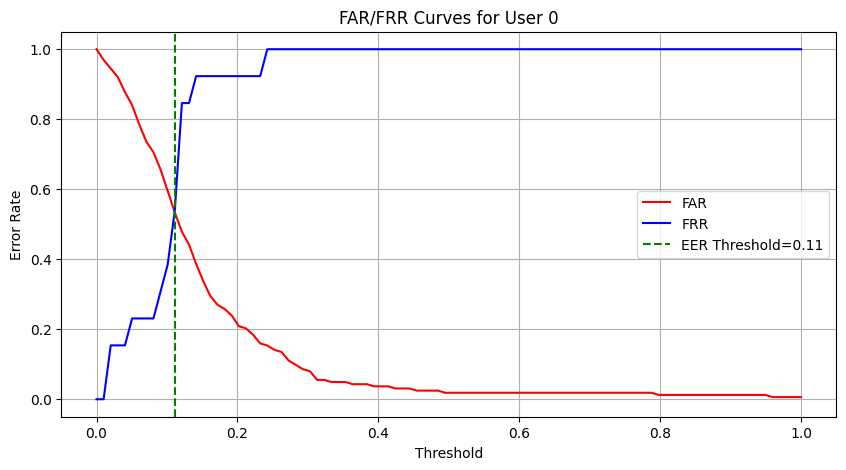


=== Training Model for User 1 ===
[User 1] Epoch 1/20 | Train Loss: 9438.1177 | Val Loss: 255608.1784 | Acc: 0.8841 | EER: 0.6824
[User 1] Epoch 2/20 | Train Loss: 9436.6362 | Val Loss: 255535.6094 | Acc: 0.8841 | EER: 0.6824
[User 1] Epoch 3/20 | Train Loss: 9432.4980 | Val Loss: 255351.5065 | Acc: 0.8841 | EER: 0.6824
[User 1] Epoch 4/20 | Train Loss: 9422.5752 | Val Loss: 254865.1393 | Acc: 0.8841 | EER: 0.6824
[User 1] Epoch 5/20 | Train Loss: 9399.1094 | Val Loss: 253792.1953 | Acc: 0.8841 | EER: 0.6824
[User 1] Epoch 6/20 | Train Loss: 9354.8877 | Val Loss: 251960.0091 | Acc: 0.8841 | EER: 0.6824
[User 1] Epoch 7/20 | Train Loss: 9282.2949 | Val Loss: 249538.3867 | Acc: 0.8841 | EER: 0.6689
[User 1] Epoch 8/20 | Train Loss: 9199.0947 | Val Loss: 247507.4277 | Acc: 0.8841 | EER: 0.6757
[User 1] Epoch 9/20 | Train Loss: 9149.9492 | Val Loss: 248417.4017 | Acc: 0.8841 | EER: 0.6554
[User 1] Epoch 10/20 | Train Loss: 9191.3398 | Val Loss: 248368.2839 | Acc: 0.8841 | EER: 0.6554
[Use

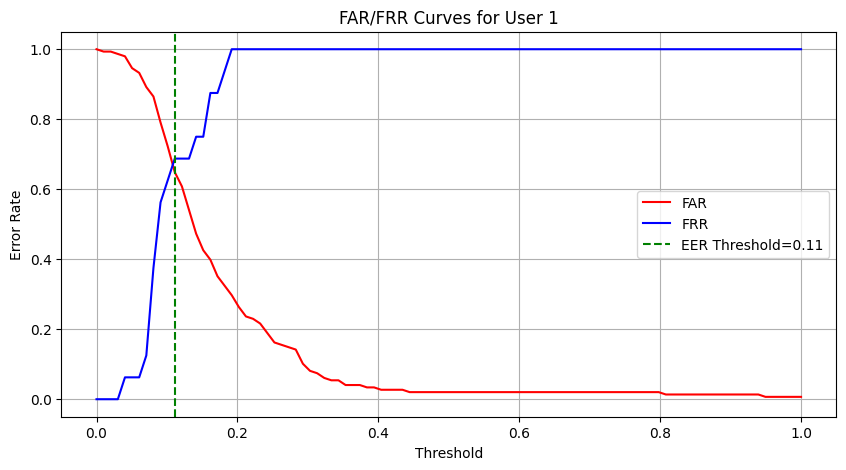


=== Training Model for User 2 ===
[User 2] Epoch 1/20 | Train Loss: 9253.7087 | Val Loss: 296258.0438 | Acc: 0.9045 | EER: 0.3885
[User 2] Epoch 2/20 | Train Loss: 9278.3265 | Val Loss: 295999.5687 | Acc: 0.9045 | EER: 0.3957
[User 2] Epoch 3/20 | Train Loss: 9035.2969 | Val Loss: 295061.1625 | Acc: 0.9045 | EER: 0.3813
[User 2] Epoch 4/20 | Train Loss: 9195.4320 | Val Loss: 292756.6000 | Acc: 0.9108 | EER: 0.3885
[User 2] Epoch 5/20 | Train Loss: 9098.3978 | Val Loss: 288829.3625 | Acc: 0.9108 | EER: 0.3597
[User 2] Epoch 6/20 | Train Loss: 8986.5407 | Val Loss: 287706.7500 | Acc: 0.8917 | EER: 0.3165
[User 2] Epoch 7/20 | Train Loss: 8959.3265 | Val Loss: 288380.3875 | Acc: 0.8917 | EER: 0.2806
[User 2] Epoch 8/20 | Train Loss: 8633.2272 | Val Loss: 286741.1875 | Acc: 0.8917 | EER: 0.3237
[User 2] Epoch 9/20 | Train Loss: 8845.9303 | Val Loss: 287156.7500 | Acc: 0.9045 | EER: 0.3237
[User 2] Epoch 10/20 | Train Loss: 8928.3919 | Val Loss: 287262.7812 | Acc: 0.9045 | EER: 0.3237
[Use

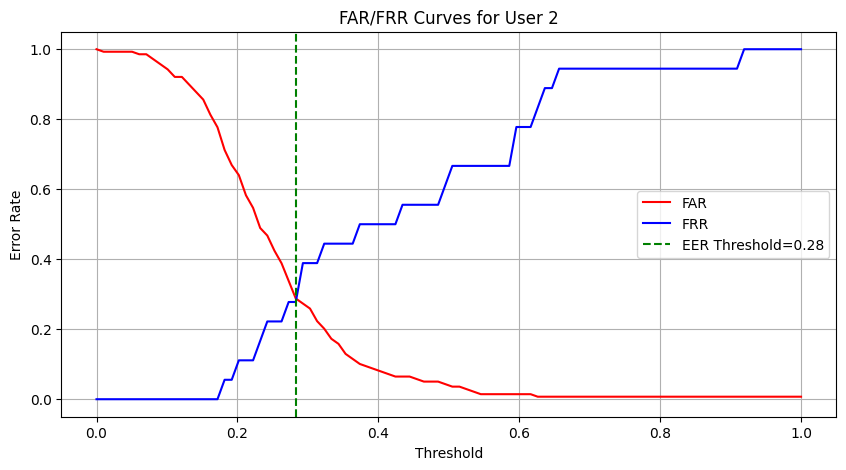


=== Final Results ===
User       Accuracy   EER       
------------------------------
0          0.9091     0.5337
1          0.8841     0.6554
2          0.8917     0.2806
------------------------------
Average    0.8950     0.4899


In [359]:
results = train_model(new_dataset_copy, batch_size=32, epochs=20, lr=1e-3, target_train_ratio=0.8)

Training on device: cuda
Unique labels: [0 1 2]

=== Training Model for User 0 ===
[User 0] Epoch 1/20 | Train Loss: 9466.7017 | Val Loss: 274234.0859 | Acc: 0.9034 | EER: 0.7178
[User 0] Epoch 2/20 | Train Loss: 9474.3999 | Val Loss: 274147.0495 | Acc: 0.9034 | EER: 0.7178
[User 0] Epoch 3/20 | Train Loss: 9461.5913 | Val Loss: 273938.0677 | Acc: 0.9034 | EER: 0.7178
[User 0] Epoch 4/20 | Train Loss: 9443.7261 | Val Loss: 273407.9479 | Acc: 0.9034 | EER: 0.7178
[User 0] Epoch 5/20 | Train Loss: 9419.9424 | Val Loss: 272224.6562 | Acc: 0.9034 | EER: 0.7239
[User 0] Epoch 6/20 | Train Loss: 9381.3882 | Val Loss: 270068.9115 | Acc: 0.9034 | EER: 0.7301
[User 0] Epoch 7/20 | Train Loss: 9316.4341 | Val Loss: 267128.2500 | Acc: 0.9091 | EER: 0.7301
[User 0] Epoch 8/20 | Train Loss: 9201.1040 | Val Loss: 265672.2969 | Acc: 0.9091 | EER: 0.6380
[User 0] Epoch 9/20 | Train Loss: 9193.1348 | Val Loss: 267056.0885 | Acc: 0.9091 | EER: 0.7301
[User 0] Epoch 10/20 | Train Loss: 9215.9854 | Val Lo

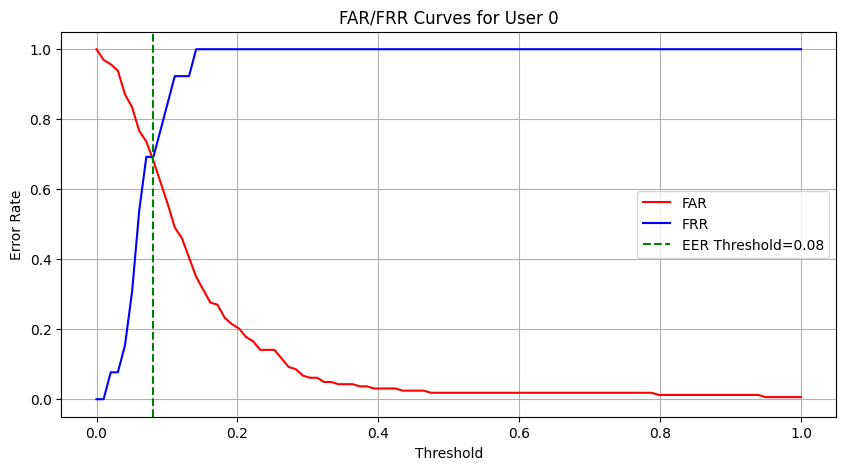


=== Training Model for User 1 ===
[User 1] Epoch 1/20 | Train Loss: 9457.3374 | Val Loss: 255353.6986 | Acc: 0.8841 | EER: 0.5135
[User 1] Epoch 2/20 | Train Loss: 9454.8579 | Val Loss: 255268.4727 | Acc: 0.8841 | EER: 0.5135
[User 1] Epoch 3/20 | Train Loss: 9451.6611 | Val Loss: 255060.2344 | Acc: 0.8841 | EER: 0.5135
[User 1] Epoch 4/20 | Train Loss: 9440.7109 | Val Loss: 254521.6992 | Acc: 0.8841 | EER: 0.5135
[User 1] Epoch 5/20 | Train Loss: 9417.8794 | Val Loss: 253331.8659 | Acc: 0.8841 | EER: 0.5135
[User 1] Epoch 6/20 | Train Loss: 9366.3589 | Val Loss: 251154.9570 | Acc: 0.8841 | EER: 0.5135
[User 1] Epoch 7/20 | Train Loss: 9282.1172 | Val Loss: 248282.5970 | Acc: 0.8841 | EER: 0.5068
[User 1] Epoch 8/20 | Train Loss: 9189.2144 | Val Loss: 247594.6764 | Acc: 0.8841 | EER: 0.4662
[User 1] Epoch 9/20 | Train Loss: 9202.9238 | Val Loss: 248507.7767 | Acc: 0.8841 | EER: 0.4527
[User 1] Epoch 10/20 | Train Loss: 9205.0928 | Val Loss: 247166.4531 | Acc: 0.8841 | EER: 0.4662
[Use

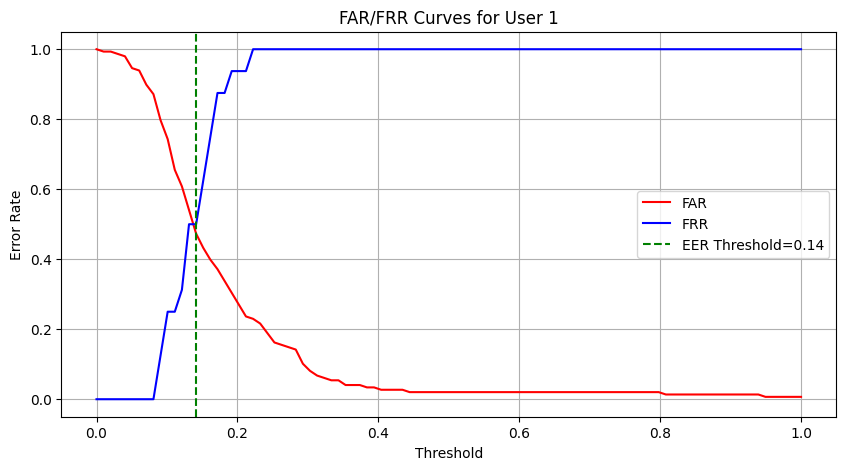


=== Training Model for User 2 ===
[User 2] Epoch 1/20 | Train Loss: 9228.6680 | Val Loss: 295936.4875 | Acc: 0.8854 | EER: 0.2158
[User 2] Epoch 2/20 | Train Loss: 9298.6595 | Val Loss: 295602.0000 | Acc: 0.8854 | EER: 0.2158
[User 2] Epoch 3/20 | Train Loss: 9299.3079 | Val Loss: 294420.4125 | Acc: 0.8854 | EER: 0.2086
[User 2] Epoch 4/20 | Train Loss: 9185.1774 | Val Loss: 291279.5250 | Acc: 0.8854 | EER: 0.2086
[User 2] Epoch 5/20 | Train Loss: 8973.9749 | Val Loss: 286917.9938 | Acc: 0.8854 | EER: 0.2230
[User 2] Epoch 6/20 | Train Loss: 8959.8317 | Val Loss: 288559.5062 | Acc: 0.8854 | EER: 0.2302
[User 2] Epoch 7/20 | Train Loss: 8992.6562 | Val Loss: 286473.7062 | Acc: 0.8854 | EER: 0.2230
[User 2] Epoch 8/20 | Train Loss: 8920.1816 | Val Loss: 287003.8250 | Acc: 0.8854 | EER: 0.2158
[User 2] Epoch 9/20 | Train Loss: 8980.9264 | Val Loss: 287029.9000 | Acc: 0.8854 | EER: 0.2158
[User 2] Epoch 10/20 | Train Loss: 8990.2578 | Val Loss: 286541.8375 | Acc: 0.8854 | EER: 0.2230
[Use

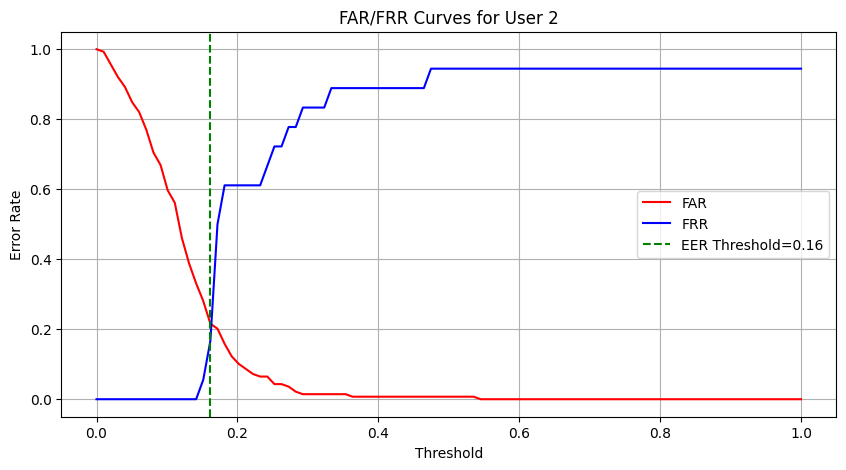


=== Final Results ===
User       Accuracy   EER       
------------------------------
0          0.9091     0.6380
1          0.8841     0.4527
2          0.8854     0.2086
------------------------------
Average    0.8929     0.4331


In [370]:
results = train_model(new_dataset_copy, batch_size=32, epochs=20, lr=1e-3, target_train_ratio=0.8)